In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm.auto import tqdm
import itertools
import joblib

# compound package
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
import pubchempy as pc
from padelpy import from_smiles, padeldescriptor

# protein package
from protlearn.preprocessing import remove_unnatural
from protlearn.features import aac
from protlearn.features import paac
from protlearn.features import aaindex1

# Data Collections

In [11]:
# read interactions data
intera_df = pd.read_csv("dataset/phase3_df.csv")
intera_df

,uniprot_id,isomeric_smiles,class
0,Q9UEE5,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1
1,Q9UEE5,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,1
2,Q9UEE5,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1,1
3,Q9UEE5,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...,1
4,Q9UEE5,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1,1
...,...,...,...
269230,P11309,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...,0
269231,P12931,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...,0
269232,Q9NZQ7,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...,0
269233,Q06187,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...,0


In [6]:
print("Number of unique compound:",intera_df["isomeric_smiles"].nunique())

Number of unique compound: 106981


In [32]:
# read protein fasta data
fasta_df = pd.read_csv("dataset/phase3_fasta.csv")
fasta_df

,protein_name,fasta,uniprot_id
0,NOD2_HUMAN,MGEEGGSASHDEEERASVLLGHSPGCEMCSQEAFQAQRSQLVELLV...,Q9UEE5
1,BRD3_HUMAN,MSTATTVAPAGIPATPGPVNPPPPEVSNPSKPGRKTNQLQYMQNVV...,P36507
2,PSA3_HUMAN,MSSIGTGYDLSASTFSPDGRVFQVEYAMKAVENSSTAIGIRCKDGV...,P25054
3,SIR1_HUMAN,MADEAALALQPGGSPSAAGADREAASSPAGEPLRKRPRRDGPGLER...,P09467
4,AK1C3_HUMAN,MDSKHQCVKLNDGHFMPVLGFGTYAPPEVPRSKALEVTKLAIEAGF...,Q03164
...,...,...,...
545,PPIA_HUMAN,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,P40763
546,PAK2_HUMAN,MSDNGELEDKPPAPPVRMSSTIFSTGGKDPLSANHSLKPLPSVPEE...,P33261
547,ROCK2_HUMAN,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,P21709
548,IMDH1_HUMAN,MADYLISGGTGYVPEDGLTAQQLFASADGLTYNDFLILPGFIDFIA...,P22607


# Compounds Feature Engineering

In [12]:
smiles_list = intera_df["isomeric_smiles"].tolist()

In [11]:
fasta_list = fasta_df["fasta"].tolist()

## Padelpy preps

In [7]:
fp_path = "padelpy/"

xml_files = glob.glob(fp_path+"*.xml")
xml_files.sort()

FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'padelpy/AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'padelpy/AtomPairs2DFingerprinter.xml',
 'EState': 'padelpy/EStateFingerprinter.xml',
 'CDKextended': 'padelpy/ExtendedFingerprinter.xml',
 'CDK': 'padelpy/Fingerprinter.xml',
 'CDKgraphonly': 'padelpy/GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'padelpy/KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'padelpy/KlekotaRothFingerprinter.xml',
 'MACCS': 'padelpy/MACCSFingerprinter.xml',
 'PubChem': 'padelpy/PubchemFingerprinter.xml',
 'SubstructureCount': 'padelpy/SubstructureFingerprintCount.xml',
 'Substructure': 'padelpy/SubstructureFingerprinter.xml'}

# Convert ISO smiles to CAN smiles

In [13]:
# convert isomeric to canonical

def iso_to_can(smiles_list:list):
    
    can_list = []
    
    for smiles in tqdm(set(smiles_list)):
        
        try:
    
            iso = Chem.MolFromSmiles(smiles)

            can = Chem.MolToSmiles(iso, isomericSmiles=False)

            can_list.append(can)
            
        except:
            
            can_list.append(np.NaN)
        
    return can_list

In [14]:
can_list = iso_to_can(smiles_list)

  0%|          | 0/106981 [00:00<?, ?it/s]

RDKit ERROR: [09:06:32] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 
RDKit ERROR: [09:06:33] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [09:06:33] SMILES Parse Error: syntax error while parsing: [Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
RDKit ERROR: [09:06:33] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O' for input: '[Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O'
RDKit ERROR: [09:06:33] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
RDKit ERROR: [09:06:33] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [09:06:33] Explicit valence for atom # 2 N, 4, is greater than permitted
RDK

RDKit ERROR: [09:06:40] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1
RDKit ERROR: [09:06:40] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1'
RDKit ERROR: [09:06:40] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
RDKit ERROR: [09:06:40] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1'
RDKit ERROR: [09:06:40] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:06:40] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:06:40] SMILES Parse Error: Failed parsing SMILES '[#6]-

RDKit ERROR: [09:06:46] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [09:06:46] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [09:06:46] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:06:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:06:46] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 28 30 31
RDKit ERROR: 
RDKit ERROR: [09:06:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
RDKit ERROR: 
RDKit ERROR: [09:06:47] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:06:47] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:06:47] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O

RDKit ERROR: [09:06:53] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:06:53] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:06:53] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [09:06:53] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27
RDKit ERROR: 
RDKit ERROR: [09:06:53] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [09:06:53] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:06:53] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:06:53] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 
RDKit ERROR: [09:06:53] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=S)ccc

RDKit ERROR: [09:07:00] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:07:00] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [09:07:00] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [09:07:00] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [09:07:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [09:07:01] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [09:07:01] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29 30 31
RDKit ERROR: 

RDKit ERROR: [09:07:06] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:07:06] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [09:07:07] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2cccc(c2)C(F)(F)F)cc1
RDKit ERROR: [09:07:07] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2cccc(c2)C(F)(F)F)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2cccc(c2)C(F)(F)F)cc1'
RDKit ERROR: [09:07:07] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [09:07:07] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:07:07] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S(

RDKit ERROR: [09:07:11] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [09:07:11] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [09:07:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:07:12] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1
RDKit ERROR: [09:07:12] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1'
RDKit ERROR: [09:07:12] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1
RDKit ERROR: [09:07:12] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1'
RDKit ERROR: [09:07:12] SMILES Parse Error: syntax error whil

In [127]:
tmp_df = pd.DataFrame({"Name": smiles_list})
tmp_df

,Name
0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...
1,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...
2,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1
3,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...
4,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1
...,...
269230,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...
269231,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...
269232,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...
269233,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...


In [128]:
tmp2_df = pd.DataFrame({
    "Name": list(set(smiles_list)),
    "can_smi": can_list
})
tmp2_df

,Name,can_smi
0,CN(C)C[C@H]1CC[C@@H](CC1)Nc1c(cnc2ccc(nc12)-c1...,CN(C)CC1CCC(Nc2c(C(=O)CO)cnc3ccc(-c4cc(F)c(O)c...
1,CC(C)c1nc(C(N)=O)c(Nc2ccc(cc2)N2CCC(CC2)N2CCN(...,CC(C)c1nc(C(N)=O)c(Nc2ccc(N3CCC(N4CCN(C)CC4)CC...
2,CC(C)(C)OC(=O)N1CCC(CC#N)(CC1)n1cc(C(N)=O)c(Nc...,CC(C)(C)OC(=O)N1CCC(CC#N)(n2cc(C(N)=O)c(Nc3ccc...
3,OC(=O)[C@@H]1CCC[C@H]1C(=O)c1ccc(cc1)-c1ccc(NC...,O=C(Nc1ccccc1)Nc1ccc(-c2ccc(C(=O)C3CCCC3C(=O)O...
4,CN(CCc1ccc(cc1)C(F)(F)F)C1CCN(CC1)C(=O)Cn1cc(N...,CN(CCc1ccc(C(F)(F)F)cc1)C1CCN(C(=O)Cn2cc(NC(=O...
...,...,...
106976,CC(C)(C)N1Cc2cc(Nc3nn(c4cc[nH]c(=O)c34)[C@]3(C...,CC(C)(C)N1Cc2cc(Nc3nn(C4(CC#N)CCOCC4F)c4cc[nH]...
106977,CO[C@H]1\C=C\CCC[S@@](=O)(NC(=O)CCc2ccccn2)=NC...,COC1C=CCCCS(=O)(NC(=O)CCc2ccccn2)=NC(=O)c2ccc3...
106978,FCCn1cc(cn1)-c1cc2c(n[nH]c2cn1)-c1cccc(n1)N1CC...,FCCn1cc(-c2cc3c(-c4cccc(N5CCNCC5)n4)n[nH]c3cn2...
106979,OC(=O)C[C@H](NC(=O)CCCCCc1ccc2CCCNc2n1)c1cnc2c...,O=C(O)CC(NC(=O)CCCCCc1ccc2c(n1)NCCC2)c1cnc2ccc...


## ECFP

In [137]:
def calc_ecfp(list_of_smiles:list)->list:
    
    ecfp = []
    
    for smiles in tqdm(list_of_smiles):
        
        try:
        
            mol = Chem.MolFromSmiles(smiles)

            can = Chem.MolToSmiles(mol, isomericSmiles=False)

            mol = Chem.MolFromSmiles(can)

            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, useFeatures=True)

            ecfp.append([int(x) for x in fp.ToBitString()])
            
        except:
            
            ecfp.append([np.NaN]*1024)
            
            print("error in smiles:", smiles)
        
#     res = np.array([np.array(x) for x in ecfp])
        
    return ecfp

In [138]:
ecfp_result = calc_ecfp(smiles_list)

  0%|          | 0/269235 [00:00<?, ?it/s]

RDKit ERROR: [09:01:08] Explicit valence for atom # 2 N, 4, is greater than permitted


error in smiles: CC1=[N](C)c2cc(cc(c2N1)-c1ccn[nH]1)C(=O)Nc1ccc(OC(F)(F)Cl)cc1


RDKit ERROR: [09:01:09] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [09:01:09] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [09:01:09] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [09:01:09] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[

error in smiles: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]


RDKit ERROR: [09:01:11] SMILES Parse Error: syntax error while parsing: [#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#6])-[#7]-[#6])C([#6])([#6])[#6])-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12)-[#6](=O)-[#7]-1-[#6][Si;v4]([#6])([#6])[#6]-[#6@H]-1-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12
RDKit ERROR: [09:01:11] SMILES Parse Error: Failed parsing SMILES '[#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#6])-[#7]-[#6])C([#6])([#6])[#6])-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12)-[#6](=O)-[#7]-1-[#6][Si;v4]([#6])([#6])[#6]-[#6@H]-1-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12' for input: '[#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#

error in smiles: [#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#6])-[#7]-[#6])C([#6])([#6])[#6])-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12)-[#6](=O)-[#7]-1-[#6][Si;v4]([#6])([#6])[#6]-[#6@H]-1-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12


RDKit ERROR: [09:01:12] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:01:12] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:01:12] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:01:12] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:01:12] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:01:12] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6]

error in smiles: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2-[#8])cc1
error in smiles: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [09:01:13] SMILES Parse Error: syntax error while parsing: [#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1
RDKit ERROR: [09:01:13] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1' for input: '[#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1'
RDKit ERROR: [09:01:13] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
RDKit ERROR: [09:01:13] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1' for input: '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1'
RDKit ERROR: [09:01:13] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
RDKit ERROR: [09:01:13] S

error in smiles: [#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1
error in smiles: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
error in smiles: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2cccc(c2)C(F)(F)F)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles: [#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-

RDKit ERROR: [09:01:13] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:01:13] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:01:13] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:01:13] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:01:13] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:01:13] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:01:13] SMILES Parse Error: syntax error while parsing: [

error in smiles: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1
error in smiles: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#6]-[#6]-[#6]-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccc3ccccc3c2)cc1
error in smiles: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1cc

RDKit ERROR: [09:01:13] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:01:13] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:01:13] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:01:13] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:01:14] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [09:01:14] SMILES Parse Error: Failed 

error in smiles: [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: [#7]-[#6]-[#6]-[#6]-[#6]-[#6@@H](-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6]-[#6]-[#6]-[#6]-[#6]-[#7]-[#6](=O)-[#6]-[#6]-[#6](=O)-[#7]-c1ncc([se;v2]1)-c1ccc(cc1)-[#6](-[#8])=O)-[#6](-[#8])=O


RDKit ERROR: [09:01:17] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
RDKit ERROR: [09:01:17] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]' for input: '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]'
RDKit ERROR: [09:01:17] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
RDKit ERROR: [09:01:17] SMILES P

error in smiles: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
error in smiles: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
error in smiles: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]


RDKit ERROR: [09:01:18] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [09:01:18] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [09:01:18] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
RDKit ERROR: 
RDKit ERROR: [09:01:19] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 


error in smiles: CC(C)c1nnc2CCc3cnc(Nc4ccc(cn4)N4CCNCC4)nc3-c12
error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C


RDKit ERROR: [09:01:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:01:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:01:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:01:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:01:21] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 34 35 36
RDKit ERROR: 
RDKit ERROR: [09:01:21] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [09:01:21] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 31 32 33
RDKit ERROR: 
RDKit ERROR: [09:01:21] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [09:01:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:01:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKi

error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCC(O)CC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N
error in smiles: COCCN(CCOC)Cc1ccc2cc([nH]c2c1)C(=O)C1C=NN(C1N)c1ccc2nc(C)nc2c1
error in smiles: C[C@H]1COCCN1Cc1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: CN1CCC(CC1)c1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: CC1CCC(C)N1Cc1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NCCN4CCOCC4)cccc3[nH]2)c1N
error in smiles: CN1CCN(CC1)C(=O)c1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: COCCNc1cccc2[nH]c(cc12)C(=O

RDKit ERROR: [09:01:22] Explicit valence for atom # 14 N, 4, is greater than permitted


error in smiles: CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl


RDKit ERROR: [09:01:26] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 


error in smiles: OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1


RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 23 24 28
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 20 21 25
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:01:29] Can't kekulize mol.  Unkekulized atoms: 1 2 6


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(c1ccccc1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: COCC(c1ccccc1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O
error in smiles: CCCC(CCC)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCC1)c1ccc(F)cc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1cscn1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1

RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 23 24 27
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDK

error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)S(C)(=N)=O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(O)C[N+]#[C-]
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(CC1CC1)C1CCOCC1)c1cc(ccc21)C(C)(C)O
error in smiles: COCC(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]nn1C)C(C)(C)O
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccc(Cl)cc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1cccc(Cl)c1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1Cl)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(O)C1CC1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)[C@](C)(O)C1CC1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)[C@@](C)(O)C1CC1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1c(F)c(ccc21)C(C)(O

RDKit ERROR: [09:01:31] Explicit valence for atom # 15 C, 5, is greater than permitted


error in smiles: C[C@H](NCc1ccc2n(CC3CCCN3[C](=C)=O)c(NC(=O)c3ccc(Cl)cc3)nc2c1)C(C)(C)C


RDKit ERROR: [09:01:32] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [09:01:32] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:01:32] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [09:01:32] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [09:01:32] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: CCc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [09:01:34] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles: CNC1=CC(Nc2cccn(-c3cccc(C)n3)c2=O)=C[N]2=C(C=NN12)C(=O)NC1CC1


RDKit ERROR: [09:01:36] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [09:01:36] Explicit valence for atom # 30 N, 4, is greater than permitted


error in smiles: CNc1cc(Nc2cccn([C@@H]3CC[C@@H](CC3)[O]3CCOCC3)c2=O)nc2c(cnn12)C(=O)N[C@H]1C[C@H]1F
error in smiles: COc1c(Nc2cc(NC(=O)C3CC3)nc3[nH]n(C)c(=O)c23)cccc1C1=NC(C)=[N](C)N1


RDKit ERROR: [09:01:36] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [09:01:36] Explicit valence for atom # 28 H, 3, is greater than permitted


error in smiles: CNc1cc(Nc2cccn(C3CC(F)(F)C3)c2=O)nc2c(cnn12)C(=O)N[H]1CCC1OC
error in smiles: CNc1cc(Nc2cccn([C@@H]3C[C@@H](C3)OC)c2=O)nc2c(cnn12)C(=O)N[H]1CC[C@@]1(C)OC


RDKit ERROR: [09:01:37] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [09:01:37] Can't kekulize mol.  Unkekulized atoms: 15 16 24 25 26 31 32
RDKit ERROR: 
RDKit ERROR: [09:01:37] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 


error in smiles: CC1(O)CCCN(C1)C1C=C[N](=N1)c1cc(nc2CNC(=O)c12)-c1c(F)cccc1C#N
error in smiles: CO[C@]1(CCOC1)c1cc(C)cc(n1)-n1cc(-c2cnn(C)c2)n2cnc(NC(N)=O)cc12
error in smiles: CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12


RDKit ERROR: [09:01:43] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
RDKit ERROR: 
RDKit ERROR: [09:01:43] Explicit valence for atom # 27 H, 2, is greater than permitted
RDKit ERROR: [09:01:43] Explicit valence for atom # 28 H, 2, is greater than permitted


error in smiles: COc1cc2c(cc1-c1c(C)noc1C)[nH]c1ccnc(-c3c(C)nnc3-c3ccccc3)c21
error in smiles: CC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1
error in smiles: CCC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1


RDKit ERROR: [09:01:44] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [09:01:44] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles: [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [09:01:45] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [09:01:45] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [09:01:45] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [09:01:45] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[

error in smiles: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]


RDKit ERROR: [09:01:51] Explicit valence for atom # 8 N, 4, is greater than permitted


error in smiles: CN(C1CCC(CC1)N(=O)C=C)c1cc(cn2cncc12)-c1ccc(O)cc1


RDKit ERROR: [09:01:52] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: C[N]1=CC(=CN1)c1cc(-c2ccc(nc2)N2CCN(CC2)S(=O)(=O)CC2CC2)c2c(cnn2c1)C#N


RDKit ERROR: [09:01:53] Explicit valence for atom # 11 N, 4, is greater than permitted


error in smiles: COCc1ccc(NC(=O)C2=[N](OC[C@@H]3CCCO3)N(c3ncnc(N)c23)C2(C)CC2)cc1


RDKit ERROR: [09:01:58] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 43 44 45
RDKit ERROR: 
RDKit ERROR: [09:01:58] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44
RDKit ERROR: 


error in smiles: Nc1nc2n(cnc2c(=O)[nH]1)[C@@H]1O[C@@H]2COP(O)(=S)O[C@H]3[C@H]4OC[C@]3(COP(O)(=S)O[C@@H]1[C@H]2F)O[C@H]4n1cnc2c(N)[nH]cnc12
error in smiles: Nc1nc2n(cnc2c(=O)[nH]1)[C@@H]1O[C@@H]2COP(S)(=O)O[C@@H]3[C@@H](COP(S)(=O)O[C@@H]1[C@@H]2F)O[C@H]([C@H]3F)n1cnc2c(N)[nH]cnc12


RDKit ERROR: [09:02:00] Explicit valence for atom # 26 N, 4, is greater than permitted


error in smiles: C[C@](O)(c1ccc(F)cc1)c1cnc(nc1)N1CCN(CC1)C1=NC=N[N]2=CC(C=C12)c1cnn(c1)C1COC1


RDKit ERROR: [09:02:00] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [09:02:00] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [09:02:01] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: C[N]1=CC=[N](C=C1)c1ccc(cc1)-c1nc2c(ncnc2[nH]1)-c1ccc(OC2CCOCC2)c(c1)C#N


RDKit ERROR: [09:02:02] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [09:02:02] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [09:02:02] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [09:02:02] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[

error in smiles: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]


RDKit ERROR: [09:02:12] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [09:02:12] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [09:02:14] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 


error in smiles: OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1


RDKit ERROR: [09:02:23] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [09:02:23] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'
RDKit ERROR: [09:02:23] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31
RDKit ERROR: 


error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
error in smiles: COCCNC(=O)c1ccc2n(cc(C)c2c1)[C@H](C)C(=O)Nc1cc(Cc2cc(C)cn2)ccc1CCCC(O)=O


RDKit ERROR: [09:02:24] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [09:02:24] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [09:02:24] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=O)ccc2c1


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [09:02:24] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=O)ccc2c1' for input: '[#6]-c1ccc2[se;v2]c(=O)ccc2c1'
RDKit ERROR: [09:02:24] SMILES Parse Error: syntax error while parsing: O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
RDKit ERROR: [09:02:24] SMILES Parse Error: Failed parsing SMILES 'O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1' for input: 'O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1'
RDKit ERROR: [09:02:24] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=S)ccc2c1
RDKit ERROR: [09:02:24] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=S)ccc2c1' for input: '[#6]-c1ccc2[se;v2]c(=S)ccc2c1'
RDKit ERROR: [09:02:25] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
RDKit ERROR: [09:02:25] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1' for input: '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1'
RDKit ERROR: [09

error in smiles: [#6]-c1ccc2[se;v2]c(=O)ccc2c1
error in smiles: O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
error in smiles: [#6]-c1ccc2[se;v2]c(=S)ccc2c1
error in smiles: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles: [Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O
error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1
error in smiles: [Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
error in smiles: [Na;v0+].[#6]-[#6]-[#6]-[#7](-[#6]-[#6]-[#6])-[#6](-[#16-])=O
error in smiles: [Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6]-[#6]-[#6])-[#6](-[#16-])=O
error in smiles: [Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#

RDKit ERROR: [09:02:27] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles: [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [09:02:28] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 2

error in smiles: COCC[N]1=C(C)C(=C(C)N1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN(C)C)nc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CC(CN3CCOCC3)C2)cc1
error in smiles: CCN(C1CCN(CC1)S(C)(=O)=O)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCSCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)c(c1)C#N
error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
erro

RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 
RDKit ERROR: [09:02:28] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 


error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1
error in smiles: CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O
error in smiles: CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [09:02:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [09:02:30] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [09:02:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
RDKit ERROR: 


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)c1nnc2CCc3cnc(Nc4ccc(cn4)N4CCNCC4)nc3-c12


RDKit ERROR: [09:02:30] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [09:02:31] Explicit valence for atom # 2 N, 4, is greater than permitted


error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C
error in smiles: CN([N]1=CC(CNc2nc(Nc3ccc(cc3)C(C)(C)O)ncc2C(F)(F)F)=CC=C1)S(C)(=O)=O


RDKit ERROR: [09:02:32] Explicit valence for atom # 19 C, 6, is greater than permitted
RDKit ERROR: [09:02:32] Explicit valence for atom # 4 C, 6, is greater than permitted
RDKit ERROR: [09:02:32] Explicit valence for atom # 8 C, 6, is greater than permitted


error in smiles: CC(C)[C@@H]1N(C)c2cc(ccc2C[C@@H](CO)NC1=O)[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14[B]475%11
error in smiles: CCCC[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14(c1ccc2C[C@@H](CO)NC(=O)[C@H](C(C)C)N(C)c2c1)[B]475%11
error in smiles: CCCCCCCC[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14(c1ccc2C[C@@H](CO)NC(=O)[C@H](C(C)C)N(C)c2c1)[B]475%11


RDKit ERROR: [09:02:33] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [09:02:33] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles: O\[O]=C(\CN1CCN(CC1)c1cnc(NC2Cc3ccccc3C2)nc1)c1ccc2[nH]c(=O)oc2c1
error in smiles: O=C(C[N]1=CC(=NO1)c1cnc(NC2Cc3ccccc3C2)nc1)N1CCc2[nH]nnc2C1


RDKit ERROR: [09:02:38] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [09:02:38] Explicit valence for atom # 13 O, 3, is greater than permitted


error in smiles: Nc1ncnc2n(nc(C(=O)NC3=[O]c4ccc(cc4N3)-c3ccccc3)c12)[C@@H]1CCN(C1)C(=O)C=C
error in smiles: Nc1ncnc2n(nc(C(=O)NC3=[O]c4ccc(cc4N3)C(F)(F)F)c12)[C@@H]1CCN(C1)C(=O)C=C


RDKit ERROR: [09:02:41] Explicit valence for atom # 34 N, 4, is greater than permitted


error in smiles: Nc1nccc2[C@@H](CCc12)NC(=O)C1=CN(Cc2ccc(CN3CC4CCCN4C3=O)cc2)N=[N]1C(F)(F)F


RDKit ERROR: [09:02:42] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [09:02:42] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [09:02:42] Explicit valence for atom # 24 N, 4, is greater than permitted


error in smiles: CC(C)(C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F)N1CCC1
error in smiles: CC(C)(CO)C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F
error in smiles: CN1CCN(CC1)C(C)(C)C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F


RDKit ERROR: [09:02:47] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
RDKit ERROR: [09:02:47] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1' for input: '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1'


error in smiles: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1


RDKit ERROR: [09:02:48] SMILES Parse Error: syntax error while parsing: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]
RDKit ERROR: [09:02:48] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]' for input: '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]'
RDKit ERROR: [09:02:48] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
RDKit ERROR: [09:02:48] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1' for input: '[#6]-[#8]

error in smiles: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]
error in smiles: [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
error in smiles: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1


RDKit ERROR: [09:02:56] Explicit valence for atom # 35 N, 4, is greater than permitted


error in smiles: Cc1ccc(NC(=O)N2CC[C@@H](CC(F)(F)F)C2)cc1-c1cc(nc(c1)N1CCOCC1)C1C=N[N](=C1)C(F)F


RDKit ERROR: [09:02:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 


error in smiles: Cc1nnc(c1C)-c1ccc2sc(NC(=O)Cc3ccc(Oc4ncccc4C(N)=O)c(F)c3)nc2c1


RDKit ERROR: [09:02:59] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27
RDKit ERROR: 


error in smiles: COC[C@@]1(CC[C@@H](CC1)Oc1ccc(cc1)-c1ccc(cn1)-c1nc(C)c(n1)C(F)(F)F)C(O)=O


RDKit ERROR: [09:03:02] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
RDKit ERROR: 
RDKit ERROR: [09:03:02] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [09:03:02] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [09:03:02] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [09:03:02] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 
RDKit ERROR: [09:03:02] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles: CNc1cc(ncn1)-c1cc(C(N)=O)c(n1)-c1cc(Cl)ccc1C
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: C(N1CCC(CC1)c1nnn2cnc3[nH]ccc3c12)C1=C[N]2=C(S1)C=CC=C2


RDKit ERROR: [09:03:02] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [09:03:05] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [09:03:05] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [09:03:05] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [09:03:05] Explicit valence for atom # 14 N, 4, is greater than permitted


error in smiles: Cc1ccc(nc1)C1CCCN1C(=O)c1ccc(N[N]2=CN3C=CC=C(N4CCC(O)(CC4)c4ccc(Cl)cc4)C3=N2)cc1
error in smiles: CC1CCCN(CCNC(=O)c2ccc(N[N]3=CN4C=CC=C(N5CCC(O)(CC5)c5ccc(Cl)cc5)C4=N3)cc2)C1
error in smiles: OC1(CCN(CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NCCc3cccnc3)N=C12)c1ccc(Cl)cc1
error in smiles: OC1(CCN(CC1)c1ccc[nH]\c1=N/[N](=C)Nc1ccc(cc1)C(=O)NC1CCNC1)c1ccc(Cl)cc1


RDKit ERROR: [09:03:05] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [09:03:05] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [09:03:05] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [09:03:05] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [09:03:05] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [09:03:06] Explicit valence for atom # 30 N, 4, is greater than permitted


error in smiles: CCOC(=O)N1CCC(=CC1)c1cccn2nc(Nc3ccc(cc3)C(=O)[N]34CC5COCC(C3)N45)nc12
error in smiles: CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles: CC[N]1(CC)CCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles: FC(F)(F)CCC(=O)N1CCC(=CC1)c1cccn2nc(Nc3ccc(cc3)C(=O)[N]34CC5COCC(C3)N45)nc12


RDKit ERROR: [09:03:14] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 19 20 21
RDKit ERROR: 


error in smiles: C[C@@H](NC(=O)Nc1cc2nnc(-c3cc[n+]([O-])cc3)c2cn1)c1ccccc1


RDKit ERROR: [09:03:15] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles: COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [09:03:16] Explicit valence for atom # 32 N, 4, is greater than permitted


error in smiles: CN1C=C(c2cnc(N)c(n2)-c2ccc(C(=O)NCc3cccc(c3)S(C)(=O)=O)c(F)c2)[N](C)=C1


RDKit ERROR: [09:03:18] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [09:03:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [09:03:18] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [09:03:18] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [09:03:18] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 


error in smiles: ONC(=O)c1ccc(cc1)-c1ccc2ccccc12
error in smiles: Cc1cc2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles: Cc1cc(-c2ccc(cc2)C(=O)NO)c2ccccc12
error in smiles: Cc1c(CN)c2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles: CN1CCN(CCc2cc(-c3ccc(cc3)C(=O)NO)c3ccccc23)CC1
error in smiles: ONC(=O)c1ccc(cc1)-c1cnc2cncnc12


RDKit ERROR: [09:03:18] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [09:03:18] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [09:03:19] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:03:19] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:03:19] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:03:19] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:03:19] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:03:19] SMILES Parse Error: Failed par

error in smiles: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
error in smiles: [#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2-[#8])cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2]C#N)cc1
error in smiles: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1
error in smiles: [#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]C#C[#6][Se;v2]c1ccc

RDKit ERROR: [09:03:20] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:03:20] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:03:20] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:03:20] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:03:20] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:03:20] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1

[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1
error in smiles: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles: [#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc

RDKit ERROR: [09:03:22] Explicit valence for atom # 29 F, 4, is greater than permitted


error in smiles: CC(O)[C@H]1COC(=O)N1c1nc(N[C@@H](C)C2CCN(CC2)c2ccc(Cl)c(c2)C#[F][O](F)F)ncc1F


RDKit ERROR: [09:03:24] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles: C[C@@H](Oc1nc(cc2nn(C)c(C)c12)C1=CN[N](=C1)C(C)(C)C)[C@H]1CNC(=O)C1


RDKit ERROR: [09:03:24] Explicit valence for atom # 26 N, 4, is greater than permitted


error in smiles: C[C@](O)(c1ccc(F)cc1)c1cnc(nc1)N1CCN(CC1)C1=NC=N[N]2=CC(C=C12)c1cnn(c1)C1COC1


RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
RDKit ERROR: 
RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:03:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR

error in smiles: Cc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: CCc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: CCc1ccc(cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: CNc1cc(ncn1)-c1cc(C(N)=O)c(n1)-c1cc(Cl)ccc1C
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1)C(F)(F)F
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(NC)ncn1)C(F)(F)F
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [09:03:27] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [09:03:27] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [09:03:27] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [09:03:27] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [09:03:27] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles: OC1(CCN(CC1)c1ccc[nH]\c1=N/[N](=C)Nc1ccc(cc1)C(=O)NC1CCNC1)c1ccc(Cl)cc1
error in smiles: CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles: CC[N]1(CC)CCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12


RDKit ERROR: [09:03:32] Explicit valence for atom # 1 B, 6, is greater than permitted
RDKit ERROR: [09:03:32] Explicit valence for atom # 1 B, 6, is greater than permitted
RDKit ERROR: [09:03:32] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [09:03:32] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [09:03:32] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [09:03:32] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [09:03:32] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [09:03:32] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [09:03:32] Explicit valence for atom # 7 C, 6, is greater than permitted


error in smiles: C[B]1234[B]567[B]89%10[B]55%11[B]88%12[B]%13%14%15[B]11([B]2%132[B]365[C]%118%142c2ccc(O)cc2)[B]9%12%15=[C]47%101
error in smiles: C[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]15([B]2%141[B]%11%152=[C]311(CO)[B]8%122[B]4691)[C]7%10%13%16c1ccc(O)cc1
error in smiles: N[C]12=34[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]=3%12%16[B]475%13)[C]%10%11%14%17c1ccc(O)cc1
error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]%11%11%17[B]8%128[B]159[C]2%118[B]3%14%17[B]46%15[C]7%10%13%16
error in smiles: Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]3%12%16[B]475%13)[C]%10%11%14%17
error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]55%11[B]161[B]556[B]211[B]323[B]478[B]922[C]%10%115[C]6132
error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[C]2%129[B]38%14[C]475%11
error in smiles: Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]88%12[B]99%1

RDKit ERROR: [09:03:34] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [09:03:34] Explicit valence for atom # 1 F, 2, is greater than permitted
RDKit ERROR: [09:03:34] Explicit valence for atom # 20 H, 2, is greater than permitted


error in smiles: CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)C1=CCC(=O)[N](CCO)=C1
error in smiles: C[F]c1nc2ccccc2n1-c1nc(cc(n1)N1CCOC[C@H]1C)N=S(C)(C)=O
error in smiles: C[C@@H]1COCCN1c1cc(N=S(C)(C)=O)nc(n1)-n1c([H]C(F)F)nc2ccccc12


RDKit ERROR: [09:03:34] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 12 14 15 16
RDKit ERROR: 


error in smiles: C[C@]1(CCc2cc(F)c3cn(Cl)c(N)nc3c2)C[C@H]([C@H](O)[C@@H]1O)n1ccc2c(N)ncnc12


RDKit ERROR: [09:03:35] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [09:03:35] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [09:03:36] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [09:03:36] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles: CC1Cc2cc(ccc2C(N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles: C[C@@H]1Cc2cc(ccc2[C@H](N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [09:03:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:36] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [09:03:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:36] Can't k

error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCC(O)CC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCNCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(F)c(Br)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N
error in smiles: C[C@H]1COCCN1Cc1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(I)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(OCC4CC4)ccc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)-c2ccc(F)cn2)c1N
error in smiles: CN1CCC(CC1)c1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[n

RDKit ERROR: [09:03:36] Explicit valence for atom # 1 F, 2, is greater than permitted
RDKit ERROR: [09:03:36] Explicit valence for atom # 20 H, 2, is greater than permitted


error in smiles: C[F]c1nc2ccccc2n1-c1nc(cc(n1)N1CCOC[C@H]1C)N=S(C)(C)=O
error in smiles: C[C@@H]1COCCN1c1cc(N=S(C)(C)=O)nc(n1)-n1c([H]C(F)F)nc2ccccc12


RDKit ERROR: [09:03:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29 30 31
RDKit ERROR: 
RDKit ERROR: [09:03:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 23 24 25
RDKit ERROR: 
RDKit ERROR: [09:03:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 24 25
RDKit ERROR: 
RDKit ERROR: [09:03:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 28 30 31
RDKit ERROR: 
RDKit ERROR: [09:03:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 30 31
RDKit ERROR: 
RDKit ERROR: [09:03:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 
RDKit ERROR: [09:03:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 
RDKit ERROR: [09:03:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 31 32
RDKit ERROR: 
RDKit ERROR: [09:03:37] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26
RDKit ERROR: 


error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Oc3ncccn3)cc2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Br)cc2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(c(C)c2nc1=O)-c1ccccc1F
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(-c3ccccc3)c(C)c2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3F)c2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3)c2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3cnn(C)c3)c2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(Cc3ccccc3C)c2nc1=O
error in smiles: CCOc1cc(ccc1OC(F)F)C(CS(C)(=O)=O)n1c2ncc(cc2nc1=O)-c1ccccc1F


RDKit ERROR: [09:03:42] Explicit valence for atom # 27 N, 4, is greater than permitted


error in smiles: CC(C)n1c(Nc2ccccc2)nc2cnc(Nc3ccc(cc3)C(=O)N[N]3=CCN(C)CC3)nc12


RDKit ERROR: [09:03:43] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [09:03:43] Explicit valence for atom # 31 C, 5, is greater than permitted
RDKit ERROR: [09:03:43] Explicit valence for atom # 0 N, 4, is greater than permitted


error in smiles: CC(C)(C)CNc1c(cnc2c(cc(N[C@H](C3=CN(NN3)C3(CC3)C(F)F)C3=CC=C[N]4=[C]3=CC=N4)cc12)C#N)C#N
error in smiles: Cc1nc(F)ccc1[C@H](Nc1cc(C#N)c2ncc(C#N)c(NCC(C)(C)C)c2c1)C1=[C](=O)N(NN1)C1(CC1)C(F)(F)F
error in smiles: [H][N]1=[C](=O)c2cccc([C@H](Nc3cc(Cl)c4ncc(C#N)c(NCC(C)(C)C)c4c3)C3=CN(NN3)C3(CC3)C(F)(F)F)c2C=C1


RDKit ERROR: [09:03:43] Explicit valence for atom # 19 H, 2, is greater than permitted


error in smiles: CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [09:03:46] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [09:03:46] Explicit valence for atom # 27 N, 4, is greater than permitted


error in smiles: COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles: COc1ccc(F)cc1-c1noc(n1)-c1ccc(N2CCCCC2C)c(c1)N([O-])=O


RDKit ERROR: [09:03:47] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [09:03:47] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [09:03:50] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O
RDKit ERROR: [09:03:50] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O' for input: '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O'


error in smiles: [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O


RDKit ERROR: [09:03:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:51] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [09:03:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:51] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [09:03:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N
error in smiles: C[C@H]1COCCN1Cc1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)N2CCOCC2)c1N
error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N


RDKit ERROR: [09:03:52] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 


error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [09:03:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:03:53] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1


RDKit ERROR: [09:03:53] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1Cl)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:03:54] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:03:54] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [09:03:54] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C
error in smiles: COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [09:03:55] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:03:55] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles: [#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:03:56] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O
RDKit ERROR: [09:03:56] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O' for input: '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O'
RDKit ERROR: [09:03:56] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O
RDKit ERROR: [09:03:56] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O'
RDKit ERROR: [09:03:56] SMILES Parse Error: syntax error while parsing: [#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1
RDKit ERROR: [09:03:56] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cc(-

error in smiles: [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O
error in smiles: [Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O
error in smiles: [#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1


RDKit ERROR: [09:03:56] Explicit valence for atom # 19 H, 2, is greater than permitted


error in smiles: CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [09:03:57] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [09:03:57] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
RDKit ERROR: [09:03:57] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1'


error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1


RDKit ERROR: [09:03:57] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:03:57] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:03:57] Can't kekulize mol.  Unkekulized atoms: 31 32 34
RDKit ERROR: 


error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: CCOc1cc(cc2n(C(C3CCC(F)(F)CC3)c3ccccc3)c3cc(cnc3c12)-c1c(C)n[nH]n1C)S(C)(=O)=O


RDKit ERROR: [09:03:57] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [09:03:57] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'
RDKit ERROR: [09:03:57] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [09:03:59] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:03:59] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:03:59] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: [#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(CCC(F)(F)F)CCC(F)(F)F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:03:59] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [09:03:59] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [09:03:59] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:04:00] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [09:04:00] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'


error in smiles: OC1(CCN(CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NCCc3cccnc3)N=C12)c1ccc(Cl)cc1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)[C@](C)(O)C1CC1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1


RDKit ERROR: [09:04:00] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1
RDKit ERROR: [09:04:00] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1'


error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1


RDKit ERROR: [09:04:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1cc2ccccc2c1-c1ccc(cc1)C(=O)NO


RDKit ERROR: [09:04:01] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:04:01] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [09:04:01] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1cc(c(F)cc21)C(C)(O)C1CC1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1


RDKit ERROR: [09:04:01] Explicit valence for atom # 7 C, 6, is greater than permitted


error in smiles: Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14[B]475%11


RDKit ERROR: [09:04:02] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [09:04:02] Can't kekulize mol.  Unkekulized atoms: 30 31 33
RDKit ERROR: 


error in smiles: CC(C)n1c(Nc2ccccc2)nc2cnc(Nc3ccc(cc3)C(=O)N[N]3=CCN(C)CC3)nc12
error in smiles: COc1nc(cc2n(C(C3CCC(F)(F)CC3)c3ccccc3)c3cc(cnc3c12)-c1c(C)n[nH]n1C)C(C)(C)O


RDKit ERROR: [09:04:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N


RDKit ERROR: [09:04:04] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:04:04] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:04:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)-c2ccc(F)cn2)c1N


RDKit ERROR: [09:04:04] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:04:04] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:04:04] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [09:04:04] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [09:04:04] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 


error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [09:04:05] SMILES Parse Error: syntax error while parsing: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1
RDKit ERROR: [09:04:05] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1' for input: '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1'


error in smiles: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1


RDKit ERROR: [09:04:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles: Cc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [09:04:06] Explicit valence for atom # 30 N, 4, is greater than permitted


error in smiles: COc1c(Nc2cc(NC(=O)C3CC3)nc3[nH]n(C)c(=O)c23)cccc1C1=NC(C)=[N](C)N1


RDKit ERROR: [09:04:07] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:04:07] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:04:08] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:04:08] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:04:08] Explicit valence for atom # 16 N, 4, is greater than permitted


error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: CC1CCCN(CCNC(=O)c2ccc(N[N]3=CN4C=CC=C(N5CCC(O)(CC5)c5ccc(Cl)cc5)C4=N3)cc2)C1


RDKit ERROR: [09:04:08] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: C[N]1=CC=[N](C=C1)c1ccc(cc1)-c1nc2c(ncnc2[nH]1)-c1ccc(OC2CCOCC2)c(c1)C#N


RDKit ERROR: [09:04:09] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [09:04:09] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [09:04:09] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [09:04:09] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles: CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [09:04:10] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:04:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1cccc(F)c1F)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [09:04:10] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
RDKit ERROR: [09:04:10] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O' for input: '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O'
RDKit ERROR: [09:04:10] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
RDKit ERROR: [09:04:10] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1'
RDKit ERROR: [09:04:10] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se

error in smiles: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1


RDKit ERROR: [09:04:11] Explicit valence for atom # 28 H, 2, is greater than permitted
RDKit ERROR: [09:04:11] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [09:04:11] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'


error in smiles: CCC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1


RDKit ERROR: [09:04:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [09:04:12] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 


error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1


RDKit ERROR: [09:04:12] Explicit valence for atom # 11 N, 4, is greater than permitted


error in smiles: COCc1ccc(NC(=O)C2=[N](OC[C@@H]3CCCO3)N(c3ncnc(N)c23)C2(C)CC2)cc1


RDKit ERROR: [09:04:13] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [09:04:13] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)C1=CCC(=O)[N](CCO)=C1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:04:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N


RDKit ERROR: [09:04:14] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [09:04:14] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [09:04:14] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [09:04:14] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
RDKit ERROR: [09:04:14] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1' for input: '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1'


error in smiles: Cc1c(CN)c2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1


RDKit ERROR: [09:04:14] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [09:04:14] Explicit valence for atom # 34 N, 4, is greater than permitted


error in smiles: Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: Nc1nccc2[C@@H](CCc12)NC(=O)C1=CN(Cc2ccc(CN3CC4CCCN4C3=O)cc2)N=[N]1C(F)(F)F


RDKit ERROR: [09:04:15] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=O)ccc2c1
RDKit ERROR: [09:04:15] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=O)ccc2c1' for input: '[#6]-c1ccc2[se;v2]c(=O)ccc2c1'


error in smiles: [#6]-c1ccc2[se;v2]c(=O)ccc2c1


RDKit ERROR: [09:04:16] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [09:04:16] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'
RDKit ERROR: [09:04:16] Explicit valence for atom # 34 N, 4, is greater than permitted


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: Nc1nccc2[C@@H](CCc12)NC(=O)C1=CN(Cc2ccc(CN3CC4CCCN4C3=O)cc2)N=[N]1C(F)(F)F


RDKit ERROR: [09:04:17] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:04:17] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:04:17] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:04:18] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:04:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1c(F)cccc1F)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [09:04:18] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [09:04:18] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'
RDKit ERROR: [09:04:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:04:19] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [09:04:19] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(cc(F)c21)S(C)(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1


RDKit ERROR: [09:04:19] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
RDKit ERROR: 


error in smiles: COc1cc2c(cc1-c1c(C)noc1C)[nH]c1ccnc(-c3c(C)nnc3-c3ccccc3)c21


RDKit ERROR: [09:04:20] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:04:20] Can't kekulize mol.  Unkekulized atoms: 20 21 25
RDKit ERROR: 
RDKit ERROR: [09:04:20] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [09:04:20] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(ccc21)S(C)(=O)=O
error in smiles: CCCC(CCC)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [09:04:21] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:04:21] Can't kekulize mol.  Unkekulized atoms: 2 4 7
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1cc(ccc21)N1CCC(CC1)C(F)(F)F
error in smiles: COc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C(C)(O)C1CC1


RDKit ERROR: [09:04:23] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:04:23] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(ccc21)S(C)(=O)=O
error in smiles: COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [09:04:23] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1
RDKit ERROR: [09:04:23] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1'


error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1


RDKit ERROR: [09:04:24] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
RDKit ERROR: [09:04:24] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]' for input: '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]'
RDKit ERROR: [09:04:24] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:04:25] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O
RDKit ERROR: [09:04:25] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O'


error in smiles: [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: [Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O


RDKit ERROR: [09:04:25] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:04:25] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:04:25] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
RDKit ERROR: [09:04:25] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1'
RDKit ERROR: [09:04:25] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
RDKit ERROR: [09:04:25] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1' for in

error in smiles: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1


RDKit ERROR: [09:04:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [09:04:26] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [09:04:26] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'
RDKit ERROR: [09:04:26] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:04:26] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:04:26] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1
RDKit ERROR: [09:04:26] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1'


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1c(cncc21)S(C)(=O)=O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cc(F)ccc1F)c1cc(ccc21)C(C)(C)O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1


RDKit ERROR: [09:04:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:04:28] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)N2CCOCC2)c1N
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [09:04:28] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [09:04:28] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
RDKit ERROR: [09:04:28] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1' for input: '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1'
RDKit ERROR: [09:04:28] Explicit valence for atom # 30 N, 4, is greater than permitted


error in smiles: COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
error in smiles: COc1c(Nc2cc(NC(=O)C3CC3)nc3[nH]n(C)c(=O)c23)cccc1C1=NC(C)=[N](C)N1


RDKit ERROR: [09:04:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:04:29] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:04:29] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:04:29] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:04:30] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
RDKit ERROR: [09:04:30] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O' for input: '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7

error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1cc(F)cc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles: [#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1c(ccc(OCC(C)(F)F)c21)S(C)(=O)=O


RDKit ERROR: [09:04:32] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 
RDKit ERROR: [09:04:32] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 


error in smiles: CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O
error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C


RDKit ERROR: [09:04:32] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:04:32] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles: [#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:04:33] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [09:04:33] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:04:33] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:04:36] Explicit valence for atom # 28 H, 2, is greater than permitted


error in smiles: COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: CCC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1


RDKit ERROR: [09:04:38] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCCN(C)CC2)cc1


RDKit ERROR: [09:04:39] Can't kekulize mol.  Unkekulized atoms: 30 31 33
RDKit ERROR: 


error in smiles: COc1nc(cc2n(C(C3CCC(F)(F)CC3)c3ccccc3)c3cc(cnc3c12)-c1c(C)n[nH]n1C)C(C)(C)O


RDKit ERROR: [09:04:40] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
RDKit ERROR: [09:04:40] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1'
RDKit ERROR: [09:04:40] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:04:40] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:04:40] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [09:04:40] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [09:04:40] SMILES Parse Error: syntax error while parsing: [Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
RDKit ERROR: [09:04:40] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O' for input: '[Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O'


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles: [Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O


RDKit ERROR: [09:04:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc4OCCOc4cc3[nH]2)c1N


RDKit ERROR: [09:04:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCOCC2)c1N


RDKit ERROR: [09:04:43] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:04:44] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [09:04:45] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O
RDKit ERROR: [09:04:45] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O'
RDKit ERROR: [09:04:45] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:04:45] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles: [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O
error in smiles: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:04:46] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cccc(F)c1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:04:46] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12


RDKit ERROR: [09:04:47] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 
RDKit ERROR: [09:04:47] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [09:04:47] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [09:04:47] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'
RDKit ERROR: [09:04:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: [H][N]1=[C](=O)c2cccc([C@H](Nc3cc(Cl)c4ncc(C#N)c(NCC(C)(C)C)c4c3)C3=CN(NN3)C3(CC3)C(F)(F)F)c2C=C1
error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N


RDKit ERROR: [09:04:48] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44
RDKit ERROR: 


error in smiles: Nc1nc2n(cnc2c(=O)[nH]1)[C@@H]1O[C@@H]2COP(S)(=O)O[C@@H]3[C@@H](COP(S)(=O)O[C@@H]1[C@@H]2F)O[C@H]([C@H]3F)n1cnc2c(N)[nH]cnc12


RDKit ERROR: [09:04:49] Explicit valence for atom # 19 H, 2, is greater than permitted


error in smiles: CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [09:04:50] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [09:04:51] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [09:04:51] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]55%11[B]161[B]556[B]211[B]323[B]478[B]922[C]%10%115[C]6132
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12


RDKit ERROR: [09:04:51] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:04:52] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CC(CN3CCOCC3)C2)cc1
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [09:04:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:04:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:04:53] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [09:04:53] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:04:53] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)-c2ccc(F)cn2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N
error in smiles: C[C@@H]1Cc2cc(ccc2[C@H](N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:04:53] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O
RDKit ERROR: [09:04:53] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O'


error in smiles: [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O


RDKit ERROR: [09:04:53] Explicit valence for atom # 7 C, 6, is greater than permitted


error in smiles: Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14[B]475%11


RDKit ERROR: [09:04:55] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:04:55] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:04:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [09:04:55] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 
RDKit ERROR: [09:04:56] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3)c2nc1=O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1c(cncc21)S(C)(=O)=O


RDKit ERROR: [09:04:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [09:04:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:04:57] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc4OCCOc4cc3[nH]2)c1N
error in smiles: CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12


RDKit ERROR: [09:04:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:04:58] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 
RDKit ERROR: [09:04:58] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:04:58] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles: CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:04:59] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: C[N]1=CC(=CN1)c1cc(-c2ccc(nc2)N2CCN(CC2)S(=O)(=O)CC2CC2)c2c(cnn2c1)C#N


RDKit ERROR: [09:04:59] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles: C(N1CCC(CC1)c1nnn2cnc3[nH]ccc3c12)C1=C[N]2=C(S1)C=CC=C2


RDKit ERROR: [09:04:59] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 
RDKit ERROR: [09:04:59] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [09:04:59] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [09:04:59] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:04:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cccc(F)c1F)c1cc(cc(F)c21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(F)c(Br)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(I)cc3[nH]2)c1N


RDKit ERROR: [09:05:00] SMILES Parse Error: syntax error while parsing: O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
RDKit ERROR: [09:05:00] SMILES Parse Error: Failed parsing SMILES 'O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1' for input: 'O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1'
RDKit ERROR: [09:05:00] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 23 24 25
RDKit ERROR: 
RDKit ERROR: [09:05:00] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [09:05:00] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 


error in smiles: O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Br)cc2nc1=O
error in smiles: CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [09:05:01] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
RDKit ERROR: [09:05:01] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1'
RDKit ERROR: [09:05:01] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
RDKit ERROR: [09:05:01] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1'
RDKit ERROR: [09:05:01] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [09:05:01] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [09:05:01] SMILES Parse Error: Failed parsing SMILES '[#7]S

error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1


RDKit ERROR: [09:05:01] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [09:05:02] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [09:05:02] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 
RDKit ERROR: [09:05:02] Explicit valence for atom # 24 N, 4, is greater than permitted


error in smiles: Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: CC1=[N](C)c2cc(cc(c2N1)-c1ccn[nH]1)C(=O)Nc1ccc(OC(F)(F)Cl)cc1
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1
error in smiles: CN1CCN(CC1)C(C)(C)C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F


RDKit ERROR: [09:05:02] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [09:05:02] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'
RDKit ERROR: [09:05:02] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [09:05:02] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 
RDKit ERROR: [09:05:02] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:05:02] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:05:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:05:03] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [09:05:03] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: CC(C)(C)CNc1c(cnc2c(cc(N[C@H](C3=CN(NN3)C3(CC3)C(F)F)C3=CC=C[N]4=[C]3=CC=N4)cc12)C#N)C#N
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [09:05:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N


RDKit ERROR: [09:05:04] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [09:05:04] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'
RDKit ERROR: [09:05:04] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
RDKit ERROR: [09:05:04] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1'
RDKit ERROR: [09:05:04] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1
RDKit ERROR: [09:05:04] SMILES Parse Error: Failed

error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1


RDKit ERROR: [09:05:05] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
RDKit ERROR: [09:05:05] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1' for input: '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1'
RDKit ERROR: [09:05:05] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1


RDKit ERROR: [09:05:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:06] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCC1)c1ccc(F)cc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:05:06] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [09:05:06] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [09:05:07] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:05:07] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 27 28 29
RDKit ERROR: 


error in smiles: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCCN(C)CC2)cc1
error in smiles: COc1cc2[nH]c(cc2cc1Cl)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1


RDKit ERROR: [09:05:07] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1Cl)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:05:08] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCCN(C)CC2)cc1


RDKit ERROR: [09:05:08] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [09:05:08] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [09:05:09] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:05:09] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:05:10] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 


error in smiles: OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1


RDKit ERROR: [09:05:11] Can't kekulize mol.  Unkekulized atoms: 23 24 28
RDKit ERROR: 


error in smiles: COCC(c1ccccc1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O


RDKit ERROR: [09:05:12] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [09:05:12] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles: CN1CCN(CCc2cc(-c3ccc(cc3)C(=O)NO)c3ccccc23)CC1
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12

RDKit ERROR: [09:05:13] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 



error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [09:05:13] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:05:13] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [09:05:13] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [09:05:13] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: COCc1ccc(NC(=O)C2=[N](OC[C@@H]3CCCO3)N(c3ncnc(N)c23)C2(C)CC2)cc1
error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [09:05:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:14] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:05:14] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(F)c(Br)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:05:16] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [09:05:16] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:05:16] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:05:16] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: CC1Cc2cc(ccc2C(N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1)c1cc(c(F)cc21)C(C)(C)O


RDKit ERROR: [09:05:17] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles: C(N1CCC(CC1)c1nnn2cnc3[nH]ccc3c12)C1=C[N]2=C(S1)C=CC=C2


RDKit ERROR: [09:05:17] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [09:05:17] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'
RDKit ERROR: [09:05:18] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1
RDKit ERROR: [09:05:18] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1'
RDKit ERROR: [09:05:18] Explicit valence for atom # 14 N, 4, is greater than permitted


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1
error in smiles: CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl


RDKit ERROR: [09:05:18] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
RDKit ERROR: [09:05:18] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [09:05:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:18] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:05:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:18] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)N2CCOCC2)c1N
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N
error in smiles: CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12


RDKit ERROR: [09:05:19] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1
RDKit ERROR: [09:05:19] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1'
RDKit ERROR: [09:05:20] Can't kekulize mol.  Unkekulized atoms: 28 29 31
RDKit ERROR: 
RDKit ERROR: [09:05:20] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1
error in smiles: COc1ccc(cc1)C(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)n[nH]n1C)C(C)(C)O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:05:20] SMILES Parse Error: syntax error while parsing: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:05:20] SMILES Parse Error: Failed parsing SMILES '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:05:20] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [09:05:20] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:05:21] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(NC)ncn1)C(F)(F)F
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [09:05:22] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [09:05:22] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [09:05:22] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1cc(ccc21)N1CCC(CC1)S(C)(=O)=O


RDKit ERROR: [09:05:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:24] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C(C)(C)O


RDKit ERROR: [09:05:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N


RDKit ERROR: [09:05:26] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [09:05:26] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:05:26] Explicit valence for atom # 30 N, 4, is greater than permitted


error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles: FC(F)(F)CCC(=O)N1CCC(=CC1)c1cccn2nc(Nc3ccc(cc3)C(=O)[N]34CC5COCC(C3)N45)nc12


RDKit ERROR: [09:05:27] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [09:05:27] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1
RDKit ERROR: [09:05:27] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1' for input: '[#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1'


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: [#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1


RDKit ERROR: [09:05:27] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 33 34 35
RDKit ERROR: 
RDKit ERROR: [09:05:27] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: CN1CCN(CC1)C(=O)c1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(O)C[N+]#[C-]


RDKit ERROR: [09:05:28] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:05:28] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1


RDKit ERROR: [09:05:29] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [09:05:29] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 


error in smiles: C[C@H](NCc1ccc2n(CC3CCCN3[C](=C)=O)c(NC(=O)c3ccc(Cl)cc3)nc2c1)C(C)(C)C
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3)c2nc1=O


RDKit ERROR: [09:05:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:29] Explicit valence for atom # 1 B, 6, is greater than permitted


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N
error in smiles: C[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]15([B]2%141[B]%11%152=[C]311(CO)[B]8%122[B]4691)[C]7%10%13%16c1ccc(O)cc1


RDKit ERROR: [09:05:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:05:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1cc(c(F)cc21)C(C)(O)C1CC1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:05:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C1(C)COC(=O)N1


RDKit ERROR: [09:05:31] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29 30 31
RDKit ERROR: 
RDKit ERROR: [09:05:31] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 33 34 35
RDKit ERROR: 
RDKit ERROR: [09:05:31] Can't kekulize mol.  Unkekulized atoms: 20 21 23
RDKit ERROR: 


error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Oc3ncccn3)cc2nc1=O
error in smiles: CN1CCN(CC1)C(=O)c1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: CCCC(CCC)n1c2cc(ccc2c2ncc(cc12)-c1c(C)n[nH]n1C)C(C)(C)O


RDKit ERROR: [09:05:32] SMILES Parse Error: syntax error while parsing: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:05:32] SMILES Parse Error: Failed parsing SMILES '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:05:32] Explicit valence for atom # 1 O, 3, is greater than permitted


error in smiles: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: O\[O]=C(\CN1CCN(CC1)c1cnc(NC2Cc3ccccc3C2)nc1)c1ccc2[nH]c(=O)oc2c1


RDKit ERROR: [09:05:33] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1
RDKit ERROR: [09:05:33] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1'


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1


RDKit ERROR: [09:05:33] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1
RDKit ERROR: [09:05:33] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1' for input: '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1'
RDKit ERROR: [09:05:34] Explicit valence for atom # 7 B, 6, is greater than permitted


error in smiles: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1
error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]%11%11%17[B]8%128[B]159[C]2%118[B]3%14%17[B]46%15[C]7%10%13%16


RDKit ERROR: [09:05:34] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=S)ccc2c1
RDKit ERROR: [09:05:34] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=S)ccc2c1' for input: '[#6]-c1ccc2[se;v2]c(=S)ccc2c1'
RDKit ERROR: [09:05:34] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:05:34] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles: [#6]-c1ccc2[se;v2]c(=S)ccc2c1
error in smiles: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:05:35] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [09:05:35] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:05:35] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:05:35] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [09:05:35] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [09:05:35] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [09:05:35] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [09:05:37] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [09:05:37] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C
error in smiles: CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1


RDKit ERROR: [09:05:38] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [09:05:39] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 28 30 31
RDKit ERROR: 


error in smiles: CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(-c3ccccc3)c(C)c2nc1=O


RDKit ERROR: [09:05:39] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [09:05:39] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [09:05:39] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [09:05:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(Cl)cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [09:05:40] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
RDKit ERROR: [09:05:40] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1' for input: '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1'
RDKit ERROR: [09:05:40] SMILES Parse Error: syntax error while parsing: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:05:40] SMILES Parse Error: Failed parsing SMILES '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:05:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:40] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
error in smiles: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(OCC4CC4)ccc3[nH]2)c1N
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:05:41] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:05:41] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [09:05:41] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:05:41] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [09:05:41] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1ccc(NC(=O)N2CC[C@@H](CC(F)(F)F)C2)cc1-c1cc(nc(c1)N1CCOCC1)C1C=N[N](=C1)C(F)F
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C1(C)COC(=O)N1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1


RDKit ERROR: [09:05:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:42] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 29 30 31
RDKit ERROR: 
RDKit ERROR: [09:05:42] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(I)cc3[nH]2)c1N
error in smiles: COCCNc1cccc2[nH]c(cc12)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [09:05:43] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 


error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [09:05:44] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:05:44] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:05:44] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [09:05:44] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
RDKit ERROR: [09:05:44] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]' for input: '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-

error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1cccc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles: [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles: CCc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccccc3[nH]2)c1N


RDKit ERROR: [09:05:45] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1
RDKit ERROR: [09:05:45] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1'
RDKit ERROR: [09:05:46] SMILES Parse Error: syntax error while parsing: [#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:05:46] SMILES Parse Error: Failed parsing SMILES '[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:05:46] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1
error in smiles: [#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: COCCNc1cccc2[nH]c(cc12)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1


RDKit ERROR: [09:05:46] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 29 30 31
RDKit ERROR: 
RDKit ERROR: [09:05:46] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cccc(F)c1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [09:05:48] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
RDKit ERROR: [09:05:48] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1' for input: '[#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1'
RDKit ERROR: [09:05:48] Explicit valence for atom # 29 F, 4, is greater than permitted
RDKit ERROR: [09:05:48] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
RDKit ERROR: 


error in smiles: [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
error in smiles: CC(O)[C@H]1COC(=O)N1c1nc(N[C@@H](C)C2CCN(CC2)c2ccc(Cl)c(c2)C#[F][O](F)F)ncc1F
error in smiles: Cc1c(CN)c2ccccc2c1-c1ccc(cc1)C(=O)NO


RDKit ERROR: [09:05:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N


RDKit ERROR: [09:05:50] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:05:50] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:05:50] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [09:05:50] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1
RDKit ERROR: [09:05:50] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1'


error in smiles: [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C
error in smiles: [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1


RDKit ERROR: [09:05:50] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [09:05:50] Explicit valence for atom # 8 C, 6, is greater than permitted
RDKit ERROR: [09:05:51] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles: CCCCCCCC[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14(c1ccc2C[C@@H](CO)NC(=O)[C@H](C(C)C)N(C)c2c1)[B]475%11
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1c(F)c(ccc21)C(C)(O)C1CC1


RDKit ERROR: [09:05:52] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [09:05:52] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [09:05:52] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles: CNc1cc(Nc2cccn(C3CC(F)(F)C3)c2=O)nc2c(cnn12)C(=O)N[H]1CCC1OC
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [09:05:53] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:05:53] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [09:05:53] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1c(F)c(ccc21)[C@@](C)(O)C1CC1
error in smiles: C[C@](O)(c1ccc(F)cc1)c1cnc(nc1)N1CCN(CC1)C1=NC=N[N]2=CC(C=C12)c1cnn(c1)C1COC1
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:05:54] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:05:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:05:55] SMILES Parse Error: syntax error while parsing: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:05:55] SMILES Parse Error: Failed parsing SMILES '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccc(Cl)cc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N
error in smiles: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:05:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N


RDKit ERROR: [09:05:57] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 


error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [09:05:58] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:05:58] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1cc(F)cc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles: ONC(=O)c1ccc(cc1)-c1ccc2ccccc12


RDKit ERROR: [09:05:58] Explicit valence for atom # 26 N, 4, is greater than permitted


error in smiles: CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)C1=CCC(=O)[N](CCO)=C1


RDKit ERROR: [09:05:59] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [09:05:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]3%12%16[B]475%13)[C]%10%11%14%17
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N


RDKit ERROR: [09:06:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N


RDKit ERROR: [09:06:00] SMILES Parse Error: syntax error while parsing: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:06:00] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:06:01] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [09:06:01] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:06:01] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:06:01] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 
RDKit ERROR: [09:06:01] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:06:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:06:01] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [09:06:01] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'


error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1


RDKit ERROR: [09:06:02] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:06:02] SMILES Parse Error: syntax error while parsing: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:06:02] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(ccc21)S(C)(=O)=O
error in smiles: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:06:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:06:03] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:06:03] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1c(cncc21)S(C)(=O)=O
error in smiles: [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:06:03] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:06:03] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:06:03] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 


error in smiles: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: CC1Cc2cc(ccc2C(N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1


RDKit ERROR: [09:06:04] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [09:06:04] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [09:06:04] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [09:06:04] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6

error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1


RDKit ERROR: [09:06:05] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26
RDKit ERROR: 
RDKit ERROR: [09:06:05] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: CCOc1cc(ccc1OC(F)F)C(CS(C)(=O)=O)n1c2ncc(cc2nc1=O)-c1ccccc1F
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [09:06:05] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:06:05] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 12 14 15 16
RDKit ERROR: 
RDKit ERROR: [09:06:06] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1)c1cc(c(F)cc21)C(C)(C)O
error in smiles: C[C@]1(CCc2cc(F)c3cn(Cl)c(N)nc3c2)C[C@H]([C@H](O)[C@@H]1O)n1ccc2c(N)ncnc12
error in smiles: CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O


RDKit ERROR: [09:06:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:06:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:06:07] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCOCC2)c1N
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(O)C[N+]#[C-]


RDKit ERROR: [09:06:07] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26
RDKit ERROR: 
RDKit ERROR: [09:06:07] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:06:07] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: CCOc1cc(ccc1OC(F)F)C(CS(C)(=O)=O)n1c2ncc(cc2nc1=O)-c1ccccc1F
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: C[N]1=CC(=CN1)c1cc(-c2ccc(nc2)N2CCN(CC2)S(=O)(=O)CC2CC2)c2c(cnn2c1)C#N


RDKit ERROR: [09:06:08] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 
RDKit ERROR: [09:06:08] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles: CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12


RDKit ERROR: [09:06:08] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [09:06:09] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1c(ccc(OCC(F)F)c21)S(C)(=O)=O


RDKit ERROR: [09:06:10] Can't kekulize mol.  Unkekulized atoms: 23 24 27
RDKit ERROR: 


error in smiles: COCC(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]nn1C)C(C)(C)O


RDKit ERROR: [09:06:11] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 


error in smiles: CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [09:06:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:06:11] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [09:06:12] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:06:12] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:06:12] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:06:12] Explicit valence for atom # 7 B, 6, is greater than permitted


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(O)C[N+]#[C-]
error in smiles: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[C]2%129[B]38%14[C]475%11


RDKit ERROR: [09:06:12] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [09:06:12] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1


RDKit ERROR: [09:06:13] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [09:06:13] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles: CN([N]1=CC(CNc2nc(Nc3ccc(cc3)C(C)(C)O)ncc2C(F)(F)F)=CC=C1)S(C)(=O)=O
error in smiles: CNC1=CC(Nc2cccn(-c3cccc(C)n3)c2=O)=C[N]2=C(C=NN12)C(=O)NC1CC1


RDKit ERROR: [09:06:14] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [09:06:14] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:06:14] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:06:14] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:06:15] Explicit valence for atom # 26 N, 4, is greater than permitted


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O


RDKit ERROR: [09:06:15] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:06:15] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:06:16] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [09:06:16] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [09:06:16] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 
RDKit ERROR: [09:06:16] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [09:06:16] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'


error in smiles: COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(CC1CC1)C1CCOCC1)c1cc(ccc21)C(C)(C)O
error in smiles: CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O
error in smiles: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]


RDKit ERROR: [09:06:16] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 
RDKit ERROR: [09:06:17] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CC(CN3CCOCC3)C2)cc1


RDKit ERROR: [09:06:17] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:06:17] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(NC)ncn1)C(F)(F)F


RDKit ERROR: [09:06:18] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
RDKit ERROR: 


error in smiles: CN1CCN(CCc2cc(-c3ccc(cc3)C(=O)NO)c3ccccc23)CC1


RDKit ERROR: [09:06:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:06:19] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:06:19] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:06:19] SMILES Parse Error: syntax error while parsing: [Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
RDKit ERROR: [09:06:19] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O' for input: '[Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O'
RDKit ERROR: [09:06:20] Explicit valence for atom # 32 N, 4, is greater than permitted


error in smiles: [Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
error in smiles: CN1C=C(c2cnc(N)c(n2)-c2ccc(C(=O)NCc3cccc(c3)S(C)(=O)=O)c(F)c2)[N](C)=C1


RDKit ERROR: [09:06:20] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1
RDKit ERROR: [09:06:20] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1'
RDKit ERROR: [09:06:20] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1
error in smiles: Cc1cc(-c2ccc(cc2)C(=O)NO)c2ccccc12


RDKit ERROR: [09:06:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCOCC2)c1N


RDKit ERROR: [09:06:22] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [09:06:22] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [09:06:22] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [09:06:22] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
RDKit ERROR: [09:06:22] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1' for input: '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1'


error in smiles: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1


RDKit ERROR: [09:06:23] Can't kekulize mol.  Unkekulized atoms: 23 24 27
RDKit ERROR: 
RDKit ERROR: [09:06:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:06:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: COCC(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]nn1C)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3=CC(F)C(CN4CCOCC4)C=c3[nH]2)c1N


RDKit ERROR: [09:06:24] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [09:06:24] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [09:06:24] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:06:24] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:06:25] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
RDKit ERROR: [09:06:25] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]' for input: '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]'
RDKit ERROR: [09:06:25] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [09:06:25] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [09:06:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 


error in smiles: [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
error in smiles: CC1CCCN(CCNC(=O)c2ccc(N[N]3=CN4C=CC=C(N5CCC(O)(CC5)c5ccc(Cl)cc5)C4=N3)cc2)C1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1


RDKit ERROR: [09:06:25] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1
RDKit ERROR: [09:06:25] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1'


error in smiles: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1


RDKit ERROR: [09:06:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [09:06:26] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
RDKit ERROR: [09:06:26] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1'
RDKit ERROR: [09:06:27] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
RDKit ERROR: [09:06:27] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1'


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1


RDKit ERROR: [09:06:27] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [09:06:27] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
RDKit ERROR: [09:06:27] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1' for input: '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1'


error in smiles: CC(C)(C)CNc1c(cnc2c(cc(N[C@H](C3=CN(NN3)C3(CC3)C(F)F)C3=CC=C[N]4=[C]3=CC=N4)cc12)C#N)C#N
error in smiles: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1


RDKit ERROR: [09:06:28] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 
RDKit ERROR: [09:06:28] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1
error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [09:06:28] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [09:06:28] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [09:06:28] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1


RDKit ERROR: [09:06:29] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [09:06:29] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [09:06:29] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1
error in smiles: CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12


RDKit ERROR: [09:06:30] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [09:06:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
RDKit ERROR: 


error in smiles: CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CC(C)c1nnc2CCc3cnc(Nc4ccc(cn4)N4CCNCC4)nc3-c12


RDKit ERROR: [09:06:30] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [09:06:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:06:31] SMILES Parse Error: syntax error while parsing: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:06:31] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(c1ccccc1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [09:06:32] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1


RDKit ERROR: [09:06:32] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [09:06:32] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 


error in smiles: CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl
error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [09:06:33] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [09:06:33] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [09:06:33] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
RDKit ERROR: [09:06:33] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1'
RDKit ERROR: [09:06:33] Explicit valence for atom # 4 N, 4, is greater than permitted


error in smiles: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles: CC1N=N[N](C)=C1c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)-c1c(C)nnn1C


RDKit ERROR: [09:06:33] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [09:06:33] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [09:06:34] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
RDKit ERROR: [09:06:34] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1'
RDKit ERROR: [09:06:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
error in smiles: Cc1nnc(c1C)-c1ccc2sc(NC(=O)Cc3ccc(Oc4ncccc4C(N)=O)c(F)c3)nc2c1


RDKit ERROR: [09:06:35] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [09:06:35] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]
RDKit ERROR: [09:06:35] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]' for input: '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]'
RDKit ERROR: [09:06:35] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
RDKit ERROR: 


error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(Cl)cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C
error in smiles: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]
error in smiles: CNc1cc(ncn1)-c1cc(C(N)=O)c(n1)-c1cc(Cl)ccc1C


RDKit ERROR: [09:06:36] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 


error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [09:06:37] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [09:06:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: [H][N]1=[C](=O)c2cccc([C@H](Nc3cc(Cl)c4ncc(C#N)c(NCC(C)(C)C)c4c3)C3=CN(NN3)C3(CC3)C(F)(F)F)c2C=C1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [09:06:38] Explicit valence for atom # 35 N, 4, is greater than permitted


error in smiles: Cc1ccc(NC(=O)N2CC[C@@H](CC(F)(F)F)C2)cc1-c1cc(nc(c1)N1CCOCC1)C1C=N[N](=C1)C(F)F


RDKit ERROR: [09:06:39] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:06:39] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [09:06:39] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1cccc(F)c1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:06:39] Explicit valence for atom # 19 H, 2, is greater than permitted


error in smiles: CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [09:06:40] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 
RDKit ERROR: [09:06:40] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [09:06:41] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
RDKit ERROR: [09:06:41] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1'
RDKit ERROR: [09:06:41] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccn1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:06:42] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [09:06:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [09:06:44] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:06:44] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: Cc1cc2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:06:47] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles: COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [09:06:48] Explicit valence for atom # 7 B, 6, is greater than permitted


error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[C]2%129[B]38%14[C]475%11


RDKit ERROR: [09:06:48] Explicit valence for atom # 1 C, 7, is greater than permitted


error in smiles: N[C]12=34[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]=3%12%16[B]475%13)[C]%10%11%14%17c1ccc(O)cc1


RDKit ERROR: [09:06:49] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [09:06:49] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:06:49] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:06:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCC(O)CC4)cc3[nH]2)c1N
error in smiles: [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [09:06:51] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [09:06:51] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1'


In [139]:
res = np.array([np.array(x) for x in ecfp_result])
res

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [140]:
ecfp_df = pd.DataFrame(res)
ecfp_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269230,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269231,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269232,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
269233,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [141]:
ecfp_df.to_csv("dataset/phase3_ecfp.csv", index=False)

In [142]:
ecfp_df.isna().sum()

0       888
1       888
2       888
3       888
4       888
       ... 
1019    888
1020    888
1021    888
1022    888
1023    888
Length: 1024, dtype: int64

## Morgan

In [26]:
def calc_morgan(list_of_smiles:list)->list:
    
    morgan = []
    
    for smiles in tqdm(list_of_smiles):
        
        try:
        
            mol = Chem.MolFromSmiles(smiles)

            can = Chem.MolToSmiles(mol, isomericSmiles=False)

            mol = Chem.MolFromSmiles(can)

            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)

            morgan.append([int(x) for x in fp.ToBitString()])
            
        except:
            
            morgan.append([np.NaN]*1024)
            
            print("error in smiles:", smiles)
        
    res = np.array([np.array(x) for x in morgan])
        
    return res

In [27]:
res_morgan = calc_morgan(smiles_list)

  0%|          | 0/269235 [00:00<?, ?it/s]

RDKit ERROR: [10:32:35] Explicit valence for atom # 2 N, 4, is greater than permitted


error in smiles: CC1=[N](C)c2cc(cc(c2N1)-c1ccn[nH]1)C(=O)Nc1ccc(OC(F)(F)Cl)cc1


RDKit ERROR: [10:32:36] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:32:36] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:32:36] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:32:36] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[

error in smiles: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]


RDKit ERROR: [10:32:37] SMILES Parse Error: syntax error while parsing: [#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#6])-[#7]-[#6])C([#6])([#6])[#6])-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12)-[#6](=O)-[#7]-1-[#6][Si;v4]([#6])([#6])[#6]-[#6@H]-1-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12
RDKit ERROR: [10:32:37] SMILES Parse Error: Failed parsing SMILES '[#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#6])-[#7]-[#6])C([#6])([#6])[#6])-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12)-[#6](=O)-[#7]-1-[#6][Si;v4]([#6])([#6])[#6]-[#6@H]-1-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12' for input: '[#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#

error in smiles: [#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#6])-[#7]-[#6])C([#6])([#6])[#6])-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12)-[#6](=O)-[#7]-1-[#6][Si;v4]([#6])([#6])[#6]-[#6@H]-1-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12


RDKit ERROR: [10:32:38] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:32:38] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:32:38] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:32:38] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:32:38] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:32:38] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6]

error in smiles: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2-[#8])cc1
error in smiles: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [10:32:39] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1' for input: '[#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1'
RDKit ERROR: [10:32:39] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
RDKit ERROR: [10:32:39] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1' for input: '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1'
RDKit ERROR: [10:32:39] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
RDKit ERROR: [10:32:39] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)c

error in smiles: [#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1
error in smiles: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
error in smiles: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2cccc(c2)C(F)(F)F)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles: [#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-

RDKit ERROR: [10:32:39] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
RDKit ERROR: [10:32:39] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1'
RDKit ERROR: [10:32:39] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1
RDKit ERROR: [10:32:39] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1'
RDKit ERROR: [10:32:39] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [10:32:39] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for in

error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
error in smiles: [#6]-[#6](-[#8])-[#6]-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles: [#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles: [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=

RDKit ERROR: [10:32:40] SMILES Parse Error: syntax error while parsing: [#7]-[#6]-[#6]-[#6]-[#6]-[#6@@H](-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6]-[#6]-[#6]-[#6]-[#6]-[#7]-[#6](=O)-[#6]-[#6]-[#6](=O)-[#7]-c1ncc([se;v2]1)-c1ccc(cc1)-[#6](-[#8])=O)-[#6](-[#8])=O
RDKit ERROR: [10:32:40] SMILES Parse Error: Failed parsing SMILES '[#7]-[#6]-[#6]-[#6]-[#6]-[#6@@H](-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6]-[#6]-[#6]-[#6]-[#6]-[#7]-[#6](=O)-[#6]-[#6]-[#6](=O)-[#7]-c1ncc([se;v2]1)-c1ccc(cc1)-[#6](-[#8])=O)-[#6](-[#8])=O' for input:

error in smiles: [#7]-[#6]-[#6]-[#6]-[#6]-[#6@@H](-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6]-[#6]-[#6]-[#6]-[#6]-[#7]-[#6](=O)-[#6]-[#6]-[#6](=O)-[#7]-c1ncc([se;v2]1)-c1ccc(cc1)-[#6](-[#8])=O)-[#6](-[#8])=O


RDKit ERROR: [10:32:42] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
RDKit ERROR: [10:32:42] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]' for input: '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]'
RDKit ERROR: [10:32:42] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
RDKit ERROR: [10:32:42] SMILES P

error in smiles: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
error in smiles: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
error in smiles: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]


RDKit ERROR: [10:32:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:32:42] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:32:43] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
RDKit ERROR: 
RDKit ERROR: [10:32:43] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)c1nnc2CCc3cnc(Nc4ccc(cn4)N4CCNCC4)nc3-c12
error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C


RDKit ERROR: [10:32:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:32:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:32:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:32:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:32:44] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 34 35 36
RDKit ERROR: 
RDKit ERROR: [10:32:44] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:32:44] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:32:44] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:32:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:32:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKi

error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCC(O)CC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N
error in smiles: COCCN(CCOC)Cc1ccc2cc([nH]c2c1)C(=O)C1C=NN(C1N)c1ccc2nc(C)nc2c1
error in smiles: C[C@H]1COCCN1Cc1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: CN1CCC(CC1)c1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: CC1CCC(C)N1Cc1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NCCN4CCOCC4)cccc3[nH]2)c1N
error in smiles: CN1CCN(CC1)C(=O)c1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: COCCNc1cccc2[nH]c(cc12)C(=O

RDKit ERROR: [10:32:45] Explicit valence for atom # 14 N, 4, is greater than permitted


error in smiles: CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl


RDKit ERROR: [10:32:49] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 


error in smiles: OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1


RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 23 24 28
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 20 21 25
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 2 6


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(c1ccccc1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: COCC(c1ccccc1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O
error in smiles: CCCC(CCC)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCC1)c1ccc(F)cc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1cscn1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1

RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 2 4 7
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:32:51] Explicit valence for atom # 3 F, 3, is greater than permitted
RDKit ERROR: [10:32:51] Can't kekulize mol.  Unkekulized atoms: 34 35 38
RDKit ERROR: 
RDKit ERROR: [10:32:51] Explicit valence for atom # 4 N, 4, is greater 

Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1Cl)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(O)C1CC1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)[C@](C)(O)C1CC1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)[C@@](C)(O)C1CC1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1c(F)c(ccc21)C(C)(O)C1CC1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1c(F)c(ccc21)[C@@](C)(O)C1CC1
error in smiles: COc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C(C)(O)C1CC1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(c(F)cc21)C(C)(O)C1CC1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1cc(c(F)cc21)C(C)(O)C1CC1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(c(F)cc21)C(C)(O)C1CC1
error in smiles: CN1N=[F]C(C)=C1c1cnc2c(c1

RDKit ERROR: [10:32:52] Explicit valence for atom # 15 C, 5, is greater than permitted


error in smiles: C[C@H](NCc1ccc2n(CC3CCCN3[C](=C)=O)c(NC(=O)c3ccc(Cl)cc3)nc2c1)C(C)(C)C


RDKit ERROR: [10:32:53] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:32:53] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:32:53] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:32:53] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [10:32:53] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: CCc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [10:32:55] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles: CNC1=CC(Nc2cccn(-c3cccc(C)n3)c2=O)=C[N]2=C(C=NN12)C(=O)NC1CC1


RDKit ERROR: [10:32:56] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [10:32:56] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [10:32:56] Explicit valence for atom # 28 H, 3, is greater than permitted


error in smiles: CNc1cc(Nc2cccn([C@@H]3CC[C@@H](CC3)[O]3CCOCC3)c2=O)nc2c(cnn12)C(=O)N[C@H]1C[C@H]1F
error in smiles: COc1c(Nc2cc(NC(=O)C3CC3)nc3[nH]n(C)c(=O)c23)cccc1C1=NC(C)=[N](C)N1
error in smiles: CNc1cc(Nc2cccn(C3CC(F)(F)C3)c2=O)nc2c(cnn12)C(=O)N[H]1CCC1OC


RDKit ERROR: [10:32:56] Explicit valence for atom # 28 H, 3, is greater than permitted


error in smiles: CNc1cc(Nc2cccn([C@@H]3C[C@@H](C3)OC)c2=O)nc2c(cnn12)C(=O)N[H]1CC[C@@]1(C)OC


RDKit ERROR: [10:32:57] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [10:32:57] Can't kekulize mol.  Unkekulized atoms: 15 16 24 25 26 31 32
RDKit ERROR: 
RDKit ERROR: [10:32:57] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 


error in smiles: CC1(O)CCCN(C1)C1C=C[N](=N1)c1cc(nc2CNC(=O)c12)-c1c(F)cccc1C#N
error in smiles: CO[C@]1(CCOC1)c1cc(C)cc(n1)-n1cc(-c2cnn(C)c2)n2cnc(NC(N)=O)cc12
error in smiles: CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12


RDKit ERROR: [10:33:02] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
RDKit ERROR: 
RDKit ERROR: [10:33:02] Explicit valence for atom # 27 H, 2, is greater than permitted
RDKit ERROR: [10:33:02] Explicit valence for atom # 28 H, 2, is greater than permitted
RDKit ERROR: [10:33:02] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: COc1cc2c(cc1-c1c(C)noc1C)[nH]c1ccnc(-c3c(C)nnc3-c3ccccc3)c21
error in smiles: CC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1
error in smiles: CCC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1
error in smiles: [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12


RDKit ERROR: [10:33:02] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [10:33:04] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:33:04] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:33:04] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:33:04] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[

error in smiles: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]


RDKit ERROR: [10:33:08] Explicit valence for atom # 8 N, 4, is greater than permitted


error in smiles: CN(C1CCC(CC1)N(=O)C=C)c1cc(cn2cncc12)-c1ccc(O)cc1


RDKit ERROR: [10:33:09] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: C[N]1=CC(=CN1)c1cc(-c2ccc(nc2)N2CCN(CC2)S(=O)(=O)CC2CC2)c2c(cnn2c1)C#N


RDKit ERROR: [10:33:09] Explicit valence for atom # 11 N, 4, is greater than permitted


error in smiles: COCc1ccc(NC(=O)C2=[N](OC[C@@H]3CCCO3)N(c3ncnc(N)c23)C2(C)CC2)cc1


RDKit ERROR: [10:33:15] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 43 44 45
RDKit ERROR: 
RDKit ERROR: [10:33:15] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44
RDKit ERROR: 


error in smiles: Nc1nc2n(cnc2c(=O)[nH]1)[C@@H]1O[C@@H]2COP(O)(=S)O[C@H]3[C@H]4OC[C@]3(COP(O)(=S)O[C@@H]1[C@H]2F)O[C@H]4n1cnc2c(N)[nH]cnc12
error in smiles: Nc1nc2n(cnc2c(=O)[nH]1)[C@@H]1O[C@@H]2COP(S)(=O)O[C@@H]3[C@@H](COP(S)(=O)O[C@@H]1[C@@H]2F)O[C@H]([C@H]3F)n1cnc2c(N)[nH]cnc12


RDKit ERROR: [10:33:16] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:33:16] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:33:16] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles: C[C@](O)(c1ccc(F)cc1)c1cnc(nc1)N1CCN(CC1)C1=NC=N[N]2=CC(C=C12)c1cnn(c1)C1COC1
error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:33:17] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:33:17] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:33:17] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:33:17] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:33:17] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c

error in smiles: C[N]1=CC=[N](C=C1)c1ccc(cc1)-c1nc2c(ncnc2[nH]1)-c1ccc(OC2CCOCC2)c(c1)C#N
error in smiles: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]


RDKit ERROR: [10:33:25] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:33:25] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [10:33:27] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 


error in smiles: OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1


RDKit ERROR: [10:33:33] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:33:33] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'
RDKit ERROR: [10:33:33] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31
RDKit ERROR: 


error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
error in smiles: COCCNC(=O)c1ccc2n(cc(C)c2c1)[C@H](C)C(=O)Nc1cc(Cc2cc(C)cn2)ccc1CCCC(O)=O


RDKit ERROR: [10:33:34] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:33:34] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [10:33:34] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=O)ccc2c1
RDKit ERROR: [10:33:34] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=O)ccc2c1' for input: '[#6]-c1ccc2[se;v2]c(=O)ccc2c1'
RDKit ERROR: [10:33:34] SMILES Parse Error: syntax error while parsing: O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
RDKit ERROR: [10:33:34] SMILES Parse Error: Failed parsing SMILES 'O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1' for input: 'O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1'
RDKit ERROR: [10:33:34] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=S)ccc2c1
RDKit ERROR: [10:33:34] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=S)ccc2c1' for input: '[#6]-c1ccc2[se;v2

error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles: [#6]-c1ccc2[se;v2]c(=O)ccc2c1
error in smiles: O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
error in smiles: [#6]-c1ccc2[se;v2]c(=S)ccc2c1


RDKit ERROR: [10:33:34] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
RDKit ERROR: [10:33:34] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1' for input: '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1'
RDKit ERROR: [10:33:34] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:33:34] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [10:33:34] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=

error in smiles: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles: [Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O
error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1
error in smiles: [Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
error in smiles: [Na;v0+].[#6]-[#6]-[#6]-[#7](-[#6]-[#6]-[#6])-[#6](-[#16-])=O
error in smiles: [Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6]-[#6]-[#6])-[#6](-[#16-])=O
error in smiles: [Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
error in smiles: [Na;v0+].[#6]-[#8]-c1ccc(-[

RDKit ERROR: [10:33:36] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 
RDKit ERROR: [10:33:37] Explicit valence for atom # 4 N, 4, is greater than permitted


error in smiles: [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1
error in smiles: COCC[N]1=C(C)C(=C(C)N1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12


RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:33:37] Can't kekulize mol.  Unkekulized atoms: 18 19 

error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN(C)C)nc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CC(CN3CCOCC3)C2)cc1
error in smiles: CCN(C1CCN(CC1)S(C)(=O)=O)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCSCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)c(c1)C#N
error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2

RDKit ERROR: [10:33:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:33:38] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:33:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
RDKit ERROR: 
RDKit ERROR: [10:33:39] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)c1nnc2CCc3cnc(Nc4ccc(cn4)N4CCNCC4)nc3-c12
error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C


RDKit ERROR: [10:33:39] Explicit valence for atom # 2 N, 4, is greater than permitted


error in smiles: CN([N]1=CC(CNc2nc(Nc3ccc(cc3)C(C)(C)O)ncc2C(F)(F)F)=CC=C1)S(C)(=O)=O


RDKit ERROR: [10:33:40] Explicit valence for atom # 19 C, 6, is greater than permitted
RDKit ERROR: [10:33:40] Explicit valence for atom # 4 C, 6, is greater than permitted
RDKit ERROR: [10:33:40] Explicit valence for atom # 8 C, 6, is greater than permitted


error in smiles: CC(C)[C@@H]1N(C)c2cc(ccc2C[C@@H](CO)NC1=O)[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14[B]475%11
error in smiles: CCCC[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14(c1ccc2C[C@@H](CO)NC(=O)[C@H](C(C)C)N(C)c2c1)[B]475%11
error in smiles: CCCCCCCC[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14(c1ccc2C[C@@H](CO)NC(=O)[C@H](C(C)C)N(C)c2c1)[B]475%11


RDKit ERROR: [10:33:41] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:33:41] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles: O\[O]=C(\CN1CCN(CC1)c1cnc(NC2Cc3ccccc3C2)nc1)c1ccc2[nH]c(=O)oc2c1
error in smiles: O=C(C[N]1=CC(=NO1)c1cnc(NC2Cc3ccccc3C2)nc1)N1CCc2[nH]nnc2C1


RDKit ERROR: [10:33:44] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [10:33:44] Explicit valence for atom # 13 O, 3, is greater than permitted


error in smiles: Nc1ncnc2n(nc(C(=O)NC3=[O]c4ccc(cc4N3)-c3ccccc3)c12)[C@@H]1CCN(C1)C(=O)C=C
error in smiles: Nc1ncnc2n(nc(C(=O)NC3=[O]c4ccc(cc4N3)C(F)(F)F)c12)[C@@H]1CCN(C1)C(=O)C=C


RDKit ERROR: [10:33:45] Explicit valence for atom # 34 N, 4, is greater than permitted


error in smiles: Nc1nccc2[C@@H](CCc12)NC(=O)C1=CN(Cc2ccc(CN3CC4CCCN4C3=O)cc2)N=[N]1C(F)(F)F


RDKit ERROR: [10:33:46] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:33:46] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:33:46] Explicit valence for atom # 24 N, 4, is greater than permitted


error in smiles: CC(C)(C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F)N1CCC1
error in smiles: CC(C)(CO)C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F
error in smiles: CN1CCN(CC1)C(C)(C)C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F


RDKit ERROR: [10:33:50] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
RDKit ERROR: [10:33:50] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1' for input: '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1'


error in smiles: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1


RDKit ERROR: [10:33:51] SMILES Parse Error: syntax error while parsing: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]
RDKit ERROR: [10:33:51] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]' for input: '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]'
RDKit ERROR: [10:33:51] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
RDKit ERROR: [10:33:51] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1' for input: '[#6]-[#8]

error in smiles: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]
error in smiles: [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
error in smiles: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1


RDKit ERROR: [10:33:57] Explicit valence for atom # 35 N, 4, is greater than permitted


error in smiles: Cc1ccc(NC(=O)N2CC[C@@H](CC(F)(F)F)C2)cc1-c1cc(nc(c1)N1CCOCC1)C1C=N[N](=C1)C(F)F


RDKit ERROR: [10:33:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 


error in smiles: Cc1nnc(c1C)-c1ccc2sc(NC(=O)Cc3ccc(Oc4ncccc4C(N)=O)c(F)c3)nc2c1


RDKit ERROR: [10:33:59] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27
RDKit ERROR: 


error in smiles: COC[C@@]1(CC[C@@H](CC1)Oc1ccc(cc1)-c1ccc(cn1)-c1nc(C)c(n1)C(F)(F)F)C(O)=O


RDKit ERROR: [10:34:01] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
RDKit ERROR: 
RDKit ERROR: [10:34:01] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:34:01] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:34:01] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [10:34:01] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 
RDKit ERROR: [10:34:01] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [10:34:01] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: CNc1cc(ncn1)-c1cc(C(N)=O)c(n1)-c1cc(Cl)ccc1C
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: C(N1CCC(CC1)c1nnn2cnc3[nH]ccc3c12)C1=C[N]2=C(S1)C=CC=C2
error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [10:34:03] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:34:03] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [10:34:03] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [10:34:04] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:34:04] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [10:34:04] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles: Cc1ccc(nc1)C1CCCN1C(=O)c1ccc(N[N]2=CN3C=CC=C(N4CCC(O)(CC4)c4ccc(Cl)cc4)C3=N2)cc1
error in smiles: CC1CCCN(CCNC(=O)c2ccc(N[N]3=CN4C=CC=C(N5CCC(O)(CC5)c5ccc(Cl)cc5)C4=N3)cc2)C1
error in smiles: OC1(CCN(CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NCCc3cccnc3)N=C12)c1ccc(Cl)cc1
error in smiles: OC1(CCN(CC1)c1ccc[nH]\c1=N/[N](=C)Nc1ccc(cc1)C(=O)NC1CCNC1)c1ccc(Cl)cc1
error in smiles: CCOC(=O)N1CCC(=CC1)c1cccn2nc(Nc3ccc(cc3)C(=O)[N]34CC5COCC(C3)N45)nc12
error in smiles: CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1


RDKit ERROR: [10:34:04] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:34:04] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:34:04] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:34:04] Explicit valence for atom # 30 N, 4, is greater than permitted


error in smiles: CC[N]1(CC)CCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles: FC(F)(F)CCC(=O)N1CCC(=CC1)c1cccn2nc(Nc3ccc(cc3)C(=O)[N]34CC5COCC(C3)N45)nc12


RDKit ERROR: [10:34:11] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 19 20 21
RDKit ERROR: 


error in smiles: C[C@@H](NC(=O)Nc1cc2nnc(-c3cc[n+]([O-])cc3)c2cn1)c1ccccc1


RDKit ERROR: [10:34:12] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:34:12] Explicit valence for atom # 32 N, 4, is greater than permitted


error in smiles: COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12
error in smiles: CN1C=C(c2cnc(N)c(n2)-c2ccc(C(=O)NCc3cccc(c3)S(C)(=O)=O)c(F)c2)[N](C)=C1


RDKit ERROR: [10:34:13] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [10:34:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [10:34:13] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [10:34:13] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [10:34:13] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 


error in smiles: ONC(=O)c1ccc(cc1)-c1ccc2ccccc12
error in smiles: Cc1cc2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles: Cc1cc(-c2ccc(cc2)C(=O)NO)c2ccccc12
error in smiles: Cc1c(CN)c2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles: CN1CCN(CCc2cc(-c3ccc(cc3)C(=O)NO)c3ccccc23)CC1
error in smiles: ONC(=O)c1ccc(cc1)-c1cnc2cncnc12


RDKit ERROR: [10:34:14] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:34:14] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [10:34:15] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:34:15] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:34:15] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:34:15] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:34:15] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:34:15] SMILES Parse Error: Failed par

error in smiles: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
error in smiles: [#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2-[#8])cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2]C#N)cc1
error in smiles: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1
error in smiles: [#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]C#C[#6][Se;v2]c1ccc

RDKit ERROR: [10:34:17] Explicit valence for atom # 29 F, 4, is greater than permitted


[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: CC(O)[C@H]1COC(=O)N1c1nc(N[C@@H](C)C2CCN(CC2)c2ccc(Cl)c(c2)C#[F][O](F)F)ncc1F


RDKit ERROR: [10:34:18] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:34:18] Explicit valence for atom # 26 N, 4, is greater than permitted


error in smiles: C[C@@H](Oc1nc(cc2nn(C)c(C)c12)C1=CN[N](=C1)C(C)(C)C)[C@H]1CNC(=O)C1
error in smiles: C[C@](O)(c1ccc(F)cc1)c1cnc(nc1)N1CCN(CC1)C1=NC=N[N]2=CC(C=C12)c1cnn(c1)C1COC1


RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
RDKit ERROR: 
RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:34:19] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR

error in smiles: Cc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: CCc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: CCc1ccc(cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: CNc1cc(ncn1)-c1cc(C(N)=O)c(n1)-c1cc(Cl)ccc1C
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1)C(F)(F)F
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(NC)ncn1)C(F)(F)F
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [10:34:21] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:34:21] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:34:21] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:34:21] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:34:21] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles: OC1(CCN(CC1)c1ccc[nH]\c1=N/[N](=C)Nc1ccc(cc1)C(=O)NC1CCNC1)c1ccc(Cl)cc1
error in smiles: CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles: CC[N]1(CC)CCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12


RDKit ERROR: [10:34:25] Explicit valence for atom # 1 B, 6, is greater than permitted
RDKit ERROR: [10:34:25] Explicit valence for atom # 1 B, 6, is greater than permitted
RDKit ERROR: [10:34:25] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [10:34:25] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [10:34:25] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [10:34:25] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [10:34:25] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [10:34:25] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [10:34:25] Explicit valence for atom # 7 C, 6, is greater than permitted


error in smiles: C[B]1234[B]567[B]89%10[B]55%11[B]88%12[B]%13%14%15[B]11([B]2%132[B]365[C]%118%142c2ccc(O)cc2)[B]9%12%15=[C]47%101
error in smiles: C[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]15([B]2%141[B]%11%152=[C]311(CO)[B]8%122[B]4691)[C]7%10%13%16c1ccc(O)cc1
error in smiles: N[C]12=34[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]=3%12%16[B]475%13)[C]%10%11%14%17c1ccc(O)cc1
error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]%11%11%17[B]8%128[B]159[C]2%118[B]3%14%17[B]46%15[C]7%10%13%16
error in smiles: Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]3%12%16[B]475%13)[C]%10%11%14%17
error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]55%11[B]161[B]556[B]211[B]323[B]478[B]922[C]%10%115[C]6132
error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[C]2%129[B]38%14[C]475%11
error in smiles: Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]88%12[B]99%1

RDKit ERROR: [10:34:26] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:34:26] Explicit valence for atom # 1 F, 2, is greater than permitted
RDKit ERROR: [10:34:26] Explicit valence for atom # 20 H, 2, is greater than permitted


error in smiles: CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)C1=CCC(=O)[N](CCO)=C1
error in smiles: C[F]c1nc2ccccc2n1-c1nc(cc(n1)N1CCOC[C@H]1C)N=S(C)(C)=O
error in smiles: C[C@@H]1COCCN1c1cc(N=S(C)(C)=O)nc(n1)-n1c([H]C(F)F)nc2ccccc12


RDKit ERROR: [10:34:26] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 12 14 15 16
RDKit ERROR: 
RDKit ERROR: [10:34:27] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:34:27] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 


error in smiles: C[C@]1(CCc2cc(F)c3cn(Cl)c(N)nc3c2)C[C@H]([C@H](O)[C@@H]1O)n1ccc2c(N)ncnc12
error in smiles: CC1Cc2cc(ccc2C(N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles: C[C@@H]1Cc2cc(ccc2[C@H](N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1


RDKit ERROR: [10:34:27] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:34:27] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit 

error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCC(O)CC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCNCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(F)c(Br)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N
error in smiles: C[C@H]1COCCN1Cc1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(I)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(OCC4CC4)ccc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)-c2ccc(F)cn2)c1N
error in smiles: CN1CCC(CC1)c1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2

RDKit ERROR: [10:34:28] Explicit valence for atom # 1 F, 2, is greater than permitted
RDKit ERROR: [10:34:28] Explicit valence for atom # 20 H, 2, is greater than permitted
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29 30 31
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 23 24 25
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 24 25
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 28 30 31
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 30 31
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 31 32
RDKit ERROR: 
RDKit ERROR: [10:34:28] Can't kekul

error in smiles: C[F]c1nc2ccccc2n1-c1nc(cc(n1)N1CCOC[C@H]1C)N=S(C)(C)=O
error in smiles: C[C@@H]1COCCN1c1cc(N=S(C)(C)=O)nc(n1)-n1c([H]C(F)F)nc2ccccc12
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Oc3ncccn3)cc2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Br)cc2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(c(C)c2nc1=O)-c1ccccc1F
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(-c3ccccc3)c(C)c2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3F)c2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3)c2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3cnn(C)c3)c2nc1=O
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(Cc3ccccc3C)c2nc1=O
error in smiles: CCOc1cc(ccc1OC(F)F)C(CS(C)(=O)=O)n1c2ncc(cc2nc1=O)-c1ccccc1F


RDKit ERROR: [10:34:32] Explicit valence for atom # 27 N, 4, is greater than permitted


error in smiles: CC(C)n1c(Nc2ccccc2)nc2cnc(Nc3ccc(cc3)C(=O)N[N]3=CCN(C)CC3)nc12


RDKit ERROR: [10:34:33] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [10:34:33] Explicit valence for atom # 31 C, 5, is greater than permitted
RDKit ERROR: [10:34:33] Explicit valence for atom # 0 N, 4, is greater than permitted


error in smiles: CC(C)(C)CNc1c(cnc2c(cc(N[C@H](C3=CN(NN3)C3(CC3)C(F)F)C3=CC=C[N]4=[C]3=CC=N4)cc12)C#N)C#N
error in smiles: Cc1nc(F)ccc1[C@H](Nc1cc(C#N)c2ncc(C#N)c(NCC(C)(C)C)c2c1)C1=[C](=O)N(NN1)C1(CC1)C(F)(F)F
error in smiles: [H][N]1=[C](=O)c2cccc([C@H](Nc3cc(Cl)c4ncc(C#N)c(NCC(C)(C)C)c4c3)C3=CN(NN3)C3(CC3)C(F)(F)F)c2C=C1


RDKit ERROR: [10:34:33] Explicit valence for atom # 19 H, 2, is greater than permitted


error in smiles: CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [10:34:36] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:34:36] Explicit valence for atom # 27 N, 4, is greater than permitted


error in smiles: COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles: COc1ccc(F)cc1-c1noc(n1)-c1ccc(N2CCCCC2C)c(c1)N([O-])=O


RDKit ERROR: [10:34:37] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:34:37] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:34:39] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O
RDKit ERROR: [10:34:39] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O' for input: '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O'


error in smiles: [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O


RDKit ERROR: [10:34:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:39] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:34:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:39] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:34:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N
error in smiles: C[C@H]1COCCN1Cc1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)N2CCOCC2)c1N
error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N


RDKit ERROR: [10:34:40] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 


error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [10:34:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:41] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1


RDKit ERROR: [10:34:42] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:34:42] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1Cl)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:34:43] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [10:34:43] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C
error in smiles: COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [10:34:43] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:34:43] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:34:46] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O
RDKit ERROR: [10:34:46] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O' for input: '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O'
RDKit ERROR: [10:34:46] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O
RDKit ERROR: [10:34:46] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6

error in smiles: [#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O
error in smiles: [Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O
error in smiles: [#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1


RDKit ERROR: [10:34:46] Explicit valence for atom # 19 H, 2, is greater than permitted
RDKit ERROR: [10:34:46] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:34:46] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
RDKit ERROR: [10:34:46] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1'
RDKit ERROR: [10:34:47] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:34:47] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:34:47] Can't kekulize mol.  Unkekulized atoms: 31 32 34
RDKit ERROR: 


error in smiles: CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N
error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: CCOc1cc(cc2n(C(C3CCC(F)(F)CC3)c3ccccc3)c3cc(cnc3c12)-c1c(C)n[nH]n1C)S(C)(=O)=O


RDKit ERROR: [10:34:47] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [10:34:47] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'
RDKit ERROR: [10:34:47] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [10:34:48] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:34:48] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:34:48] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:34:48] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: [#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(CCC(F)(F)F)CCC(F)(F)F)c1cc(ccc21)C(C)(C)O
error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [10:34:49] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [10:34:49] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:34:49] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [10:34:49] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'
RDKit ERROR: [10:34:49] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1
RDKit ERROR: [10:34:49] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1'
RDKit ERROR: [10:34:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: OC1(CCN(CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NCCc3cccnc3)N=C12)c1ccc(Cl)cc1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)[C@](C)(O)C1CC1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1
error in smiles: Cc1cc2ccccc2c1-c1ccc(cc1)C(=O)NO


RDKit ERROR: [10:34:50] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:34:50] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [10:34:50] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'
RDKit ERROR: [10:34:50] Explicit valence for atom # 7 C, 6, is greater than permitted


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1cc(c(F)cc21)C(C)(O)C1CC1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14[B]475%11


RDKit ERROR: [10:34:51] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [10:34:51] Can't kekulize mol.  Unkekulized atoms: 30 31 33
RDKit ERROR: 
RDKit ERROR: [10:34:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: CC(C)n1c(Nc2ccccc2)nc2cnc(Nc3ccc(cc3)C(=O)N[N]3=CCN(C)CC3)nc12
error in smiles: COc1nc(cc2n(C(C3CCC(F)(F)CC3)c3ccccc3)c3cc(cnc3c12)-c1c(C)n[nH]n1C)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N


RDKit ERROR: [10:34:52] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:34:52] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:34:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:52] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:34:52] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:34:53] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])

error in smiles: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)-c2ccc(F)cn2)c1N
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [10:34:53] SMILES Parse Error: syntax error while parsing: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1
RDKit ERROR: [10:34:53] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1' for input: '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1'


error in smiles: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1


RDKit ERROR: [10:34:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:34:54] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [10:34:55] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:34:55] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: Cc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: COc1c(Nc2cc(NC(=O)C3CC3)nc3[nH]n(C)c(=O)c23)cccc1C1=NC(C)=[N](C)N1
error in smiles: [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:34:55] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:34:55] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:34:56] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [10:34:56] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: CC1CCCN(CCNC(=O)c2ccc(N[N]3=CN4C=CC=C(N5CCC(O)(CC5)c5ccc(Cl)cc5)C4=N3)cc2)C1
error in smiles: C[N]1=CC=[N](C=C1)c1ccc(cc1)-c1nc2c(ncnc2[nH]1)-c1ccc(OC2CCOCC2)c(c1)C#N


RDKit ERROR: [10:34:56] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:34:56] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [10:34:57] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:34:57] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O
error in smiles: CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [10:34:57] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:34:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:34:57] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
RDKit ERROR: [10:34:57] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O' for input: '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O'
RDKit ERROR: [10:34:58] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
RDKit ERROR: [10:34:58] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc

error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1cccc(F)c1F)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles: CCC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1


RDKit ERROR: [10:34:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [10:34:59] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:34:59] Explicit valence for atom # 11 N, 4, is greater than permitted


error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles: COCc1ccc(NC(=O)C2=[N](OC[C@@H]3CCCO3)N(c3ncnc(N)c23)C2(C)CC2)cc1


RDKit ERROR: [10:34:59] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:35:00] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)C1=CCC(=O)[N](CCO)=C1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N


RDKit ERROR: [10:35:00] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [10:35:00] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:35:00] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [10:35:00] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
RDKit ERROR: [10:35:00] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1' for input: '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1'
RDKit ERROR: [10:35:01] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [10:35:01] Explicit valence for atom # 34 N, 4, is greater than per

error in smiles: Cc1c(CN)c2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
error in smiles: Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: Nc1nccc2[C@@H](CCc12)NC(=O)C1=CN(Cc2ccc(CN3CC4CCCN4C3=O)cc2)N=[N]1C(F)(F)F


RDKit ERROR: [10:35:01] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=O)ccc2c1
RDKit ERROR: [10:35:01] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=O)ccc2c1' for input: '[#6]-c1ccc2[se;v2]c(=O)ccc2c1'


error in smiles: [#6]-c1ccc2[se;v2]c(=O)ccc2c1


RDKit ERROR: [10:35:02] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [10:35:02] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'
RDKit ERROR: [10:35:02] Explicit valence for atom # 34 N, 4, is greater than permitted


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: Nc1nccc2[C@@H](CCc12)NC(=O)C1=CN(Cc2ccc(CN3CC4CCCN4C3=O)cc2)N=[N]1C(F)(F)F


RDKit ERROR: [10:35:03] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:35:03] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:35:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:35:03] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:04] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [10:35:04] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1c(F)cccc1F)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1


RDKit ERROR: [10:35:04] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:04] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:35:04] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(cc(F)c21)S(C)(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1


RDKit ERROR: [10:35:05] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
RDKit ERROR: 
RDKit ERROR: [10:35:05] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:35:05] Can't kekulize mol.  Unkekulized atoms: 20 21 25
RDKit ERROR: 
RDKit ERROR: [10:35:05] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:35:05] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles: COc1cc2c(cc1-c1c(C)noc1C)[nH]c1ccnc(-c3c(C)nnc3-c3ccccc3)c21
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(ccc21)S(C)(=O)=O
error in smiles: CCCC(CCC)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [10:35:06] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:06] Can't kekulize mol.  Unkekulized atoms: 2 4 7
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1cc(ccc21)N1CCC(CC1)C(F)(F)F
error in smiles: COc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C(C)(O)C1CC1


RDKit ERROR: [10:35:07] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:35:08] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(ccc21)S(C)(=O)=O
error in smiles: COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [10:35:08] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1
RDKit ERROR: [10:35:08] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1'


error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1


RDKit ERROR: [10:35:09] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
RDKit ERROR: [10:35:09] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]' for input: '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]'
RDKit ERROR: [10:35:09] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:35:09] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O
RDKit ERROR: [10:35:09] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O'


error in smiles: [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: [Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O


RDKit ERROR: [10:35:09] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:35:09] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:35:09] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
RDKit ERROR: [10:35:09] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1'
RDKit ERROR: [10:35:10] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
RDKit ERROR: [10:35:10] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1' for in

error in smiles: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1c(cncc21)S(C)(=O)=O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cc(F)ccc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:35:10] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:10] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1
RDKit ERROR: [10:35:10] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1'


error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)N2CCOCC2)c1N


RDKit ERROR: [10:35:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:11] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:12] Explicit valence for atom # 26 N, 4, is greater than permitted


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O
error in smiles: COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
error in smiles: COc1c(Nc2cc(NC(=O)C3CC3)nc3[nH]n(C)c(=O)c23)cccc1C1=NC(C)=[N](C)N1


RDKit ERROR: [10:35:12] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
RDKit ERROR: [10:35:12] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1' for input: '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1'
RDKit ERROR: [10:35:12] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [10:35:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:13] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1cc(F)cc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles: [#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1c(ccc(OCC(C)(F)F)c21)S(C)(=O)=O


RDKit ERROR: [10:35:13] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:35:13] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:35:13] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
RDKit ERROR: [10:35:13] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O' for input: '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O'
RDKit ERROR: [10:35:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKi

error in smiles: CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O
error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C


RDKit ERROR: [10:35:15] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:35:15] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles: [#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:35:16] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:35:16] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:35:16] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:35:16] Explicit valence for atom # 28 H, 2, is greater than permitted


error in smiles: COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: CCC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1


RDKit ERROR: [10:35:17] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCCN(C)CC2)cc1


RDKit ERROR: [10:35:18] Can't kekulize mol.  Unkekulized atoms: 30 31 33
RDKit ERROR: 


error in smiles: COc1nc(cc2n(C(C3CCC(F)(F)CC3)c3ccccc3)c3cc(cnc3c12)-c1c(C)n[nH]n1C)C(C)(C)O


RDKit ERROR: [10:35:19] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
RDKit ERROR: [10:35:19] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1'
RDKit ERROR: [10:35:19] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:35:19] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:35:19] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:35:19] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [10:35:19] SMILES Par

error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles: [Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O


RDKit ERROR: [10:35:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc4OCCOc4cc3[nH]2)c1N


RDKit ERROR: [10:35:20] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCOCC2)c1N


RDKit ERROR: [10:35:21] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:35:22] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:23] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O
RDKit ERROR: [10:35:23] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O'


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O
error in smiles: [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O


RDKit ERROR: [10:35:23] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:35:23] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:35:23] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:24] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cccc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12


RDKit ERROR: [10:35:24] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 
RDKit ERROR: [10:35:24] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:35:25] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:35:25] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'
RDKit ERROR: [10:35:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: [H][N]1=[C](=O)c2cccc([C@H](Nc3cc(Cl)c4ncc(C#N)c(NCC(C)(C)C)c4c3)C3=CN(NN3)C3(CC3)C(F)(F)F)c2C=C1
error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N


RDKit ERROR: [10:35:25] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44
RDKit ERROR: 


error in smiles: Nc1nc2n(cnc2c(=O)[nH]1)[C@@H]1O[C@@H]2COP(S)(=O)O[C@@H]3[C@@H](COP(S)(=O)O[C@@H]1[C@@H]2F)O[C@H]([C@H]3F)n1cnc2c(N)[nH]cnc12


RDKit ERROR: [10:35:26] Explicit valence for atom # 19 H, 2, is greater than permitted


error in smiles: CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [10:35:27] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:35:27] Explicit valence for atom # 7 B, 6, is greater than permitted


error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]55%11[B]161[B]556[B]211[B]323[B]478[B]922[C]%10%115[C]6132


RDKit ERROR: [10:35:28] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:35:28] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:35:28] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CC(CN3CCOCC3)C2)cc1
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [10:35:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:29] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:35:29] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:35:29] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:35:29] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O
RDKit ERROR: [10:35:29] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O'


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)-c2ccc(F)cn2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N
error in smiles: C[C@@H]1Cc2cc(ccc2[C@H](N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O


RDKit ERROR: [10:35:29] Explicit valence for atom # 7 C, 6, is greater than permitted


error in smiles: Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14[B]475%11


RDKit ERROR: [10:35:30] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:35:30] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:35:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:35:31] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 
RDKit ERROR: [10:35:31] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3)c2nc1=O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1c(cncc21)S(C)(=O)=O
error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:35:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:32] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc4OCCOc4cc3[nH]2)c1N
error in smiles: CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12


RDKit ERROR: [10:35:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:33] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 
RDKit ERROR: [10:35:33] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:35:33] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles: CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:35:33] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:35:34] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles: C[N]1=CC(=CN1)c1cc(-c2ccc(nc2)N2CCN(CC2)S(=O)(=O)CC2CC2)c2c(cnn2c1)C#N
error in smiles: C(N1CCC(CC1)c1nnn2cnc3[nH]ccc3c12)C1=C[N]2=C(S1)C=CC=C2


RDKit ERROR: [10:35:34] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 
RDKit ERROR: [10:35:34] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:35:34] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [10:35:34] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:34] SMILES Parse Error: syntax error while parsing: O=[#6]-1[T

error in smiles: OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cccc(F)c1F)c1cc(cc(F)c21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(F)c(Br)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(I)cc3[nH]2)c1N
error in smiles: O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Br)cc2nc1=O
error in smiles: CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1


RDKit ERROR: [10:35:35] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:35:35] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
RDKit ERROR: [10:35:35] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1'
RDKit ERROR: [10:35:35] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
RDKit ERROR: [10:35:35] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1'
RDKit ERROR: [10:35:35] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:35:35] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]

error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: CC1=[N](C)c2cc(cc(c2N1)-c1ccn[nH]1)C(=O)Nc1ccc(OC(F)(F)Cl)cc1
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [10:35:36] Explicit valence for atom # 24 N, 4, is greater than permitted
RDKit ERROR: [10:35:36] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [10:35:36] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'
RDKit ERROR: [10:35:36] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [10:35:36] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 
RDKit ERROR: [10:35:36] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:35:36] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(

error in smiles: CN1CCN(CC1)C(C)(C)C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:35:37] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:35:37] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [10:35:37] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: CC(C)(C)CNc1c(cnc2c(cc(N[C@H](C3=CN(NN3)C3(CC3)C(F)F)C3=CC=C[N]4=[C]3=CC=N4)cc12)C#N)C#N
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [10:35:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:38] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [10:35:38] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'
RDKit ERROR: [10:35:38] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
RDKit ERROR: [10:35:38] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1'
RDKit ERROR: [10:35:38] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2

error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1
error in smiles: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1


RDKit ERROR: [10:35:38] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:35:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:39] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCC1)c1ccc(F)cc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:35:39] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:35:39] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:35:39] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:35:39] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 27 28 29
RDKit ERROR: 
RDKit ERROR: [10:35:40] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCCN(C)CC2)cc1
error in smiles: COc1cc2[nH]c(cc2cc1Cl)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1Cl)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:35:40] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:35:41] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:35:41] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCCN(C)CC2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1


RDKit ERROR: [10:35:41] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:35:41] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:35:42] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 
RDKit ERROR: [10:35:43] Can't kekulize mol.  Unkekulized atoms: 23 24 28
RDKit ERROR: 


error in smiles: OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1
error in smiles: COCC(c1ccccc1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O


RDKit ERROR: [10:35:43] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [10:35:44] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles: CN1CCN(CCc2cc(-c3ccc(cc3)C(=O)NO)c3ccccc23)CC1
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12


RDKit ERROR: [10:35:44] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:35:45] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:35:45] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [10:35:45] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:35:45] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: COCc1ccc(NC(=O)C2=[N](OC[C@@H]3CCCO3)N(c3ncnc(N)c23)C2(C)CC2)cc1
error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [10:35:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:45] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:35:45] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(F)c(Br)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:35:47] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:35:47] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:35:47] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: CC1Cc2cc(ccc2C(N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:35:47] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1)c1cc(c(F)cc21)C(C)(C)O


RDKit ERROR: [10:35:48] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [10:35:48] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [10:35:48] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'


error in smiles: C(N1CCC(CC1)c1nnn2cnc3[nH]ccc3c12)C1=C[N]2=C(S1)C=CC=C2
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1


RDKit ERROR: [10:35:48] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1
RDKit ERROR: [10:35:48] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1'
RDKit ERROR: [10:35:48] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:35:48] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:35:48] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [10:35:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:49] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:35:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit 

error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1
error in smiles: CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)N2CCOCC2)c1N
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N
error in smiles: CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12


RDKit ERROR: [10:35:49] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1
RDKit ERROR: [10:35:49] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1'
RDKit ERROR: [10:35:50] Can't kekulize mol.  Unkekulized atoms: 28 29 31
RDKit ERROR: 
RDKit ERROR: [10:35:50] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:50] SMILES Parse Error: syntax error while parsing: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:35:50] SMILES Parse Error: Failed parsing SMILES '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1
error in smiles: COc1ccc(cc1)C(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)n[nH]n1C)C(C)(C)O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(ccc21)C(C)(C)O
error in smiles: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:35:50] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:35:50] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:35:50] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(NC)ncn1)C(F)(F)F
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:35:51] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:35:51] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [10:35:51] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1cc(ccc21)N1CCC(CC1)S(C)(=O)=O


RDKit ERROR: [10:35:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:53] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C(C)(C)O


RDKit ERROR: [10:35:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F


RDKit ERROR: [10:35:54] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:35:55] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [10:35:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles: FC(F)(F)CCC(=O)N1CCC(=CC1)c1cccn2nc(Nc3ccc(cc3)C(=O)[N]34CC5COCC(C3)N45)nc12
error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:35:55] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1
RDKit ERROR: [10:35:55] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1' for input: '[#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1'
RDKit ERROR: [10:35:55] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 33 34 35
RDKit ERROR: 
RDKit ERROR: [10:35:56] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: [#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1
error in smiles: CN1CCN(CC1)C(=O)c1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(O)C[N+]#[C-]


RDKit ERROR: [10:35:56] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:35:57] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:35:57] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [10:35:57] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles: C[C@H](NCc1ccc2n(CC3CCCN3[C](=C)=O)c(NC(=O)c3ccc(Cl)cc3)nc2c1)C(C)(C)C
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3)c2nc1=O


RDKit ERROR: [10:35:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:35:57] Explicit valence for atom # 1 B, 6, is greater than permitted
RDKit ERROR: [10:35:58] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N
error in smiles: C[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]15([B]2%141[B]%11%152=[C]311(CO)[B]8%122[B]4691)[C]7%10%13%16c1ccc(O)cc1
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1cc(c(F)cc21)C(C)(O)C1CC1


RDKit ERROR: [10:35:58] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:58] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:35:58] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29 30 31
RDKit ERROR: 
RDKit ERROR: [10:35:58] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 33 34 35
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C1(C)COC(=O)N1
error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Oc3ncccn3)cc2nc1=O
error in smiles: CN1CCN(CC1)C(=O)c1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1


RDKit ERROR: [10:35:59] Can't kekulize mol.  Unkekulized atoms: 20 21 23
RDKit ERROR: 
RDKit ERROR: [10:35:59] SMILES Parse Error: syntax error while parsing: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:35:59] SMILES Parse Error: Failed parsing SMILES '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:35:59] Explicit valence for atom # 1 O, 3, is greater than permitted


error in smiles: CCCC(CCC)n1c2cc(ccc2c2ncc(cc12)-c1c(C)n[nH]n1C)C(C)(C)O
error in smiles: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: O\[O]=C(\CN1CCN(CC1)c1cnc(NC2Cc3ccccc3C2)nc1)c1ccc2[nH]c(=O)oc2c1


RDKit ERROR: [10:36:00] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1
RDKit ERROR: [10:36:00] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1'
RDKit ERROR: [10:36:00] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1
RDKit ERROR: [10:36:00] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1' for input: '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1'


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1
error in smiles: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1


RDKit ERROR: [10:36:01] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [10:36:01] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=S)ccc2c1
RDKit ERROR: [10:36:01] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=S)ccc2c1' for input: '[#6]-c1ccc2[se;v2]c(=S)ccc2c1'
RDKit ERROR: [10:36:01] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:01] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:36:01] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:36:01] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:36:01] SMILES Pars

error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]%11%11%17[B]8%128[B]159[C]2%118[B]3%14%17[B]46%15[C]7%10%13%16
error in smiles: [#6]-c1ccc2[se;v2]c(=S)ccc2c1
error in smiles: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12


RDKit ERROR: [10:36:02] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 
RDKit ERROR: [10:36:02] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:36:02] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [10:36:03] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [10:36:03] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:36:04] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 


error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C
error in smiles: CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles: CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:36:04] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 28 30 31
RDKit ERROR: 
RDKit ERROR: [10:36:05] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:36:05] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'


error in smiles: CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(-c3ccccc3)c(C)c2nc1=O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1


RDKit ERROR: [10:36:05] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [10:36:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:05] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
RDKit ERROR: [10:36:05] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1' for input: '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1'
RDKit ERROR: [10:36:05] SMILES Parse Error: syntax error while parsing: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:36:05] SMILES Parse Error: Failed parsing SMILES '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]-c1ccc([Se;v2][#6]-c2c

error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(Cl)cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
error in smiles: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(OCC4CC4)ccc3[nH]2)c1N
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:36:06] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:36:06] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [10:36:06] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:36:06] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [10:36:06] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1ccc(NC(=O)N2CC[C@@H](CC(F)(F)F)C2)cc1-c1cc(nc(c1)N1CCOCC1)C1C=N[N](=C1)C(F)F
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C1(C)COC(=O)N1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1


RDKit ERROR: [10:36:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:07] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 29 30 31
RDKit ERROR: 
RDKit ERROR: [10:36:07] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(I)cc3[nH]2)c1N
error in smiles: COCCNc1cccc2[nH]c(cc12)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [10:36:08] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 


error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [10:36:09] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:36:09] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:36:09] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:36:09] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
RDKit ERROR: [10:36:09] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]' for input: '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-

error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1cccc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles: [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles: CCc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccccc3[nH]2)c1N
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1


RDKit ERROR: [10:36:10] SMILES Parse Error: syntax error while parsing: [#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:10] SMILES Parse Error: Failed parsing SMILES '[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:36:10] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [10:36:10] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 29 30 31
RDKit ERROR: 
RDKit ERROR: [10:36:11] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: [#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles: COCCNc1cccc2[nH]c(cc12)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cccc(F)c1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [10:36:12] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
RDKit ERROR: [10:36:12] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1' for input: '[#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1'
RDKit ERROR: [10:36:12] Explicit valence for atom # 29 F, 4, is greater than permitted
RDKit ERROR: [10:36:12] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
RDKit ERROR: 


error in smiles: [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
error in smiles: CC(O)[C@H]1COC(=O)N1c1nc(N[C@@H](C)C2CCN(CC2)c2ccc(Cl)c(c2)C#[F][O](F)F)ncc1F
error in smiles: Cc1c(CN)c2ccccc2c1-c1ccc(cc1)C(=O)NO


RDKit ERROR: [10:36:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N


RDKit ERROR: [10:36:13] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:13] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:36:13] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [10:36:13] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1
RDKit ERROR: [10:36:13] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1'
RDKit ERROR: [10:36:14] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:36:14] Explicit valence for atom # 8 C, 6, is greater than permitted


error in smiles: [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C
error in smiles: [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles: CCCCCCCC[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14(c1ccc2C[C@@H](CO)NC(=O)[C@H](C(C)C)N(C)c2c1)[B]475%11


RDKit ERROR: [10:36:14] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1c(F)c(ccc21)C(C)(O)C1CC1


RDKit ERROR: [10:36:15] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [10:36:15] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:36:15] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles: CNc1cc(Nc2cccn(C3CC(F)(F)C3)c2=O)nc2c(cnn12)C(=O)N[H]1CCC1OC
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [10:36:16] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:36:16] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:36:16] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1c(F)c(ccc21)[C@@](C)(O)C1CC1
error in smiles: C[C@](O)(c1ccc(F)cc1)c1cnc(nc1)N1CCN(CC1)C1=NC=N[N]2=CC(C=C12)c1cnn(c1)C1COC1
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:36:17] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:36:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:20] SMILES Parse Error: syntax error while parsing: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:36:20] SMILES Parse Error: Failed parsing SMILES '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccc(Cl)cc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N
error in smiles: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:36:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N


RDKit ERROR: [10:36:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:36:22] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:36:22] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 


error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1cc(F)cc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles: ONC(=O)c1ccc(cc1)-c1ccc2ccccc12


RDKit ERROR: [10:36:22] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:36:23] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [10:36:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)C1=CCC(=O)[N](CCO)=C1
error in smiles: Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]3%12%16[B]475%13)[C]%10%11%14%17
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N


RDKit ERROR: [10:36:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:24] SMILES Parse Error: syntax error while parsing: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:24] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N
error in smiles: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:36:24] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:36:24] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:36:24] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:36:25] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 
RDKit ERROR: [10:36:25] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:36:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:25] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:36:25] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]

error in smiles: CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1


RDKit ERROR: [10:36:25] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:36:25] SMILES Parse Error: syntax error while parsing: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:25] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:36:26] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:36:26] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:36:26] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(ccc21)S(C)(=O)=O
error in smiles: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1c(cncc21)S(C)(=O)=O
error in smiles: [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:36:26] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:26] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:36:26] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:36:27] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:36:27] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[

error in smiles: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: CC1Cc2cc(ccc2C(N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1


RDKit ERROR: [10:36:27] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:36:27] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [10:36:27] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:36:27] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6

error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles: CCOc1cc(ccc1OC(F)F)C(CS(C)(=O)=O)n1c2ncc(cc2nc1=O)-c1ccccc1F
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:36:28] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:36:28] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 12 14 15 16
RDKit ERROR: 
RDKit ERROR: [10:36:28] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1)c1cc(c(F)cc21)C(C)(C)O
error in smiles: C[C@]1(CCc2cc(F)c3cn(Cl)c(N)nc3c2)C[C@H]([C@H](O)[C@@H]1O)n1ccc2c(N)ncnc12
error in smiles: CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O


RDKit ERROR: [10:36:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:29] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:36:29] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26
RDKit ERROR: 
RDKit ERROR: [10:36:29] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCOCC2)c1N
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(O)C[N+]#[C-]
error in smiles: CCOc1cc(ccc1OC(F)F)C(CS(C)(=O)=O)n1c2ncc(cc2nc1=O)-c1ccccc1F
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:36:29] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:36:29] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 
RDKit ERROR: [10:36:30] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:36:30] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles: C[N]1=CC(=CN1)c1cc(-c2ccc(nc2)N2CCN(CC2)S(=O)(=O)CC2CC2)c2c(cnn2c1)C#N
error in smiles: CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [10:36:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:36:31] Can't kekulize mol.  Unkekulized atoms: 23 24 27
RDKit ERROR: 


error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1c(ccc(OCC(F)F)c21)S(C)(=O)=O
error in smiles: COCC(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]nn1C)C(C)(C)O


RDKit ERROR: [10:36:32] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 
RDKit ERROR: [10:36:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:32] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles: CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles: COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [10:36:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:36:33] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:33] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:36:33] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [10:36:33] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [10:36:33] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(O)C[N+]#[C-]
error in smiles: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[C]2%129[B]38%14[C]475%11
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1


RDKit ERROR: [10:36:33] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:36:34] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles: CN([N]1=CC(CNc2nc(Nc3ccc(cc3)C(C)(C)O)ncc2C(F)(F)F)=CC=C1)S(C)(=O)=O
error in smiles: CNC1=CC(Nc2cccn(-c3cccc(C)n3)c2=O)=C[N]2=C(C=NN12)C(=O)NC1CC1


RDKit ERROR: [10:36:34] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [10:36:34] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:34] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:36:34] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:36:35] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:36:35] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:36:35] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:36:36] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:36:36] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:36:36] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 


error in smiles: COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12
error in smiles: Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(CC1CC1)C1CCOCC1)c1cc(ccc21)C(C)(C)O
error in smiles: CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O


RDKit ERROR: [10:36:36] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:36:36] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:36:36] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 
RDKit ERROR: [10:36:36] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CC(CN3CCOCC3)C2)cc1


RDKit ERROR: [10:36:37] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:36:37] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O
error in smiles: CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(NC)ncn1)C(F)(F)F


RDKit ERROR: [10:36:37] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [10:36:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:38] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:38] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:36:38] SMILES Parse Error: syntax error while parsing: [Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
RDKit ERROR: [10:36:38] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O' for input: '[Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O'
RDKit ERROR: [10:36:38] Explicit valence for atom # 32 N, 

error in smiles: CN1CCN(CCc2cc(-c3ccc(cc3)C(=O)NO)c3ccccc23)CC1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
error in smiles: CN1C=C(c2cnc(N)c(n2)-c2ccc(C(=O)NCc3cccc(c3)S(C)(=O)=O)c(F)c2)[N](C)=C1


RDKit ERROR: [10:36:39] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1
RDKit ERROR: [10:36:39] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1'
RDKit ERROR: [10:36:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [10:36:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1
error in smiles: Cc1cc(-c2ccc(cc2)C(=O)NO)c2ccccc12
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCOCC2)c1N


RDKit ERROR: [10:36:40] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [10:36:40] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:36:40] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [10:36:40] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
RDKit ERROR: [10:36:40] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1' for input: '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1'


error in smiles: Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1


RDKit ERROR: [10:36:41] Can't kekulize mol.  Unkekulized atoms: 23 24 27
RDKit ERROR: 
RDKit ERROR: [10:36:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: COCC(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]nn1C)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3=CC(F)C(CN4CCOCC4)C=c3[nH]2)c1N


RDKit ERROR: [10:36:42] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:36:42] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [10:36:42] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:42] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:36:42] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
RDKit ERROR: [10:36:42] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]' for input: '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]'
R

error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
error in smiles: [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
error in smiles: CC1CCCN(CCNC(=O)c2ccc(N[N]3=CN4C=CC=C(N5CCC(O)(CC5)c5ccc(Cl)cc5)C4=N3)cc2)C1
error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:36:43] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:36:43] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1
RDKit ERROR: [10:36:43] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1'


error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1
error in smiles: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1


RDKit ERROR: [10:36:43] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:36:44] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
RDKit ERROR: [10:36:44] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1'
RDKit ERROR: [10:36:44] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:36:44] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1'


error in smiles: CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1


RDKit ERROR: [10:36:44] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [10:36:45] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
RDKit ERROR: [10:36:45] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1' for input: '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1'
RDKit ERROR: [10:36:45] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 
RDKit ERROR: [10:36:45] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles: CC(C)(C)CNc1c(cnc2c(cc(N[C@H](C3=CN(NN3)C3(CC3)C(F)F)C3=CC=C[N]4=[C]3=CC=N4)cc12)C#N)C#N
error in smiles: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
error in smiles: OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1
error in smiles: [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [10:36:45] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:36:45] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [10:36:45] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:36:46] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles: CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1
error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:36:46] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:36:46] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:36:46] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [10:36:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
RDKit ERROR: 


error in smiles: CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl
error in smiles: CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles: CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles: CC(C)c1nnc2CCc3cnc(Nc4ccc(cn4)N4CCNCC4)nc3-c12


RDKit ERROR: [10:36:47] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:36:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:47] SMILES Parse Error: syntax error while parsing: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:47] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(c1ccccc1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:36:48] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:36:48] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:36:48] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 


error in smiles: CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1
error in smiles: CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl
error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [10:36:48] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:36:48] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:36:49] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
RDKit ERROR: [10:36:49] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1'
RDKit ERROR: [10:36:49] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:36:49] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:36:49] SMILES Parse Error: Failed parsing SMILES '

error in smiles: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles: CC1N=N[N](C)=C1c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)-c1c(C)nnn1C
error in smiles: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1


RDKit ERROR: [10:36:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 
RDKit ERROR: [10:36:50] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [10:36:50] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]
RDKit ERROR: [10:36:50] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]' for input: '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]'


error in smiles: Cc1nnc(c1C)-c1ccc2sc(NC(=O)Cc3ccc(Oc4ncccc4C(N)=O)c(F)c3)nc2c1
error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(Cl)cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C
error in smiles: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]


RDKit ERROR: [10:36:50] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
RDKit ERROR: 
RDKit ERROR: [10:36:51] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 


error in smiles: CNc1cc(ncn1)-c1cc(C(N)=O)c(n1)-c1cc(Cl)ccc1C
error in smiles: CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:36:52] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:36:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: [H][N]1=[C](=O)c2cccc([C@H](Nc3cc(Cl)c4ncc(C#N)c(NCC(C)(C)C)c4c3)C3=CN(NN3)C3(CC3)C(F)(F)F)c2C=C1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [10:36:52] Explicit valence for atom # 35 N, 4, is greater than permitted


error in smiles: Cc1ccc(NC(=O)N2CC[C@@H](CC(F)(F)F)C2)cc1-c1cc(nc(c1)N1CCOCC1)C1C=N[N](=C1)C(F)F


RDKit ERROR: [10:36:53] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:36:53] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:36:53] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:36:53] Explicit valence for atom # 19 H, 2, is greater than permitted


error in smiles: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1cccc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles: CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [10:36:54] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 
RDKit ERROR: [10:36:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles: CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles: Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [10:36:55] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
RDKit ERROR: [10:36:55] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1'
RDKit ERROR: [10:36:55] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
error in smiles: Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccn1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:36:56] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles: Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:36:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:36:57] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:36:57] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: Cc1cc2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:36:58] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles: COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [10:36:58] Explicit valence for atom # 7 B, 6, is greater than permitted


error in smiles: Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[C]2%129[B]38%14[C]475%11


RDKit ERROR: [10:36:58] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [10:36:59] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:36:59] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:36:59] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:36:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles: N[C]12=34[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]=3%12%16[B]475%13)[C]%10%11%14%17c1ccc(O)cc1
error in smiles: [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles: Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCC(O)CC4)cc3[nH]2)c1N


RDKit ERROR: [10:37:00] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:37:00] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles: [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1


In [28]:
morgan_df = pd.DataFrame(res_morgan)
morgan_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269230,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
269231,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
269232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269233,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [30]:
morgan_df.to_csv("dataset/phase3_morgan.csv", index=False)

In [114]:
morgan_df.isna().sum()

0       888
1       888
2       888
3       888
4       888
       ... 
1019    888
1020    888
1021    888
1022    888
1023    888
Length: 1024, dtype: int64

## MACCS

In [31]:
def calc_maccs(list_of_smiles:list)->np.array:
    
    maccs = []
    
    for smiles in tqdm(list_of_smiles):
        
        try:
        
            mol = Chem.MolFromSmiles(smiles)

            fp = MACCSkeys.GenMACCSKeys(mol)

            fp_arr = np.array(list(fp.ToBitString())).astype(int)

            maccs.append(fp_arr)
            
        except:
            
            maccs.append([np.NaN]*167)
            
            print("error in smiles: ", smiles)
        
    fp_array = np.array(maccs)
    
    return fp_array

In [32]:
maccs = calc_maccs(smiles_list)

  0%|          | 0/269235 [00:00<?, ?it/s]

RDKit ERROR: [10:40:42] Explicit valence for atom # 2 N, 4, is greater than permitted


error in smiles:  CC1=[N](C)c2cc(cc(c2N1)-c1ccn[nH]1)C(=O)Nc1ccc(OC(F)(F)Cl)cc1


RDKit ERROR: [10:40:44] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:40:44] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:40:44] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:40:44] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[

error in smiles:  [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles:  [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]


RDKit ERROR: [10:40:47] SMILES Parse Error: syntax error while parsing: [#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#6])-[#7]-[#6])C([#6])([#6])[#6])-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12)-[#6](=O)-[#7]-1-[#6][Si;v4]([#6])([#6])[#6]-[#6@H]-1-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12
RDKit ERROR: [10:40:47] SMILES Parse Error: Failed parsing SMILES '[#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#6])-[#7]-[#6])C([#6])([#6])[#6])-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12)-[#6](=O)-[#7]-1-[#6][Si;v4]([#6])([#6])[#6]-[#6@H]-1-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12' for input: '[#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#

error in smiles:  [#6]-[#7]-[#6@@H](-[#6])-[#6](=O)-[#7]-[#6@@H](-[#6]-c1ccc(cc1)C#C[#6](=O)-[#7]-[#6@H]-1-[#6]-[#6@H](-[#7](-[#6]-1)-[#6](=O)-[#6@@H](-[#7]-[#6](=O)-[#6@H](-[#6])-[#7]-[#6])C([#6])([#6])[#6])-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12)-[#6](=O)-[#7]-1-[#6][Si;v4]([#6])([#6])[#6]-[#6@H]-1-[#6](=O)-[#7]-[#6@@H]-1-[#6]-[#6]-[#6]-c2ccccc-12


RDKit ERROR: [10:40:49] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:40:49] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:40:49] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:40:49] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:40:49] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:40:49] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6]

error in smiles:  [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2-[#8])cc1
error in smiles:  [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [10:40:49] SMILES Parse Error: syntax error while parsing: [#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1
RDKit ERROR: [10:40:49] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1' for input: '[#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1'
RDKit ERROR: [10:40:49] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
RDKit ERROR: [10:40:49] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1' for input: '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1'
RDKit ERROR: [10:40:49] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
RDKit ERROR: [10:40:49] S

error in smiles:  [#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1
error in smiles:  [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
error in smiles:  [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2cccc(c2)C(F)(F)F)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles:  [#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#7]S(=O)(=O)c1ccc

RDKit ERROR: [10:40:50] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:40:50] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:40:50] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:40:50] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:40:50] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:40:50] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:40:50] SMILES Parse Error: syntax error while parsing: [

error in smiles:  [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles:  [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1
error in smiles:  [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#6]-[#6]-[#6]-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccc3ccccc3c2)cc1
error in smiles:  [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#7]S

RDKit ERROR: [10:40:50] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:40:50] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:40:50] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [10:40:50] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'
RDKit ERROR: [10:40:50] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [

error in smiles:  [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles:  [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles:  [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1


RDKit ERROR: [10:40:52] SMILES Parse Error: syntax error while parsing: [#7]-[#6]-[#6]-[#6]-[#6]-[#6@@H](-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6]-[#6]-[#6]-[#6]-[#6]-[#7]-[#6](=O)-[#6]-[#6]-[#6](=O)-[#7]-c1ncc([se;v2]1)-c1ccc(cc1)-[#6](-[#8])=O)-[#6](-[#8])=O
RDKit ERROR: [10:40:52] SMILES Parse Error: Failed parsing SMILES '[#7]-[#6]-[#6]-[#6]-[#6]-[#6@@H](-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6]-[#6]-[#6]-[#6]-[#6]-[#7]-[#6](=O)-[#6]-[#6]-[#6](=O)-[#7]-c1ncc([se;v2]1)-c1ccc(cc1)-[#6](-[#8])=O)-[#6](-[#8])=O' for input:

error in smiles:  [#7]-[#6]-[#6]-[#6]-[#6]-[#6@@H](-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6@@H](-[#6]-[#6](-[#8])=O)-[#7]-[#6](=O)-[#6]-[#6]-[#6]-[#6]-[#6]-[#7]-[#6](=O)-[#6]-[#6]-[#6](=O)-[#7]-c1ncc([se;v2]1)-c1ccc(cc1)-[#6](-[#8])=O)-[#6](-[#8])=O


RDKit ERROR: [10:40:56] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
RDKit ERROR: [10:40:56] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]' for input: '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]'
RDKit ERROR: [10:40:56] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
RDKit ERROR: [10:40:56] SMILES P

error in smiles:  [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
error in smiles:  [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
error in smiles:  [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]


RDKit ERROR: [10:40:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:40:58] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles:  CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles:  CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:40:59] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
RDKit ERROR: 
RDKit ERROR: [10:40:59] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 


error in smiles:  CC(C)c1nnc2CCc3cnc(Nc4ccc(cn4)N4CCNCC4)nc3-c12
error in smiles:  CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C


RDKit ERROR: [10:41:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:41:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:41:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:41:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:41:02] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 34 35 36
RDKit ERROR: 
RDKit ERROR: [10:41:02] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:41:02] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:41:02] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:41:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:41:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKi

error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCC(O)CC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N
error in smiles:  COCCN(CCOC)Cc1ccc2cc([nH]c2c1)C(=O)C1C=NN(C1N)c1ccc2nc(C)nc2c1
error in smiles:  C[C@H]1COCCN1Cc1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  CN1CCC(CC1)c1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  CC1CCC(C)N1Cc1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NCCN4CCOCC4)cccc3[nH]2)c1N
error in smiles:  CN1CCN(CC1)C(=O)c1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  COCCNc1cccc2[n

RDKit ERROR: [10:41:05] Explicit valence for atom # 14 N, 4, is greater than permitted


error in smiles:  CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl


RDKit ERROR: [10:41:12] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 


error in smiles:  OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1


RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 23 24 28
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 20 21 25
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:17] Can't kekulize mol.  Unkekulized atoms: 1 2 6


error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(c1ccccc1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  COCC(c1ccccc1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O
error in smiles:  CCCC(CCC)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCC1)c1ccc(F)cc1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1cscn1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1n[nH]n(C)c

RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 29 30 32
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 31 32 34
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 28 29 31
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 4

error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  COc1cc(cc2n(C(C3CCOCC3)c3ncccc3F)c3cc(cnc3c12)-c1c(C)n[nH]n1C)S(C)(=O)=O
error in smiles:  CCOc1cc(cc2n(C(C3CCC(F)(F)CC3)c3ccccc3)c3cc(cnc3c12)-c1c(C)n[nH]n1C)S(C)(=O)=O
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(cc(F)c21)S(C)(=O)=O
error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1c(ccc(F)c21)S(C)(=O)=O
error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(ccc21)S(C)(=O)=O
error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1c(ccc(OCC(F)F)c21)S(C)(=O)=O
error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1c(ccc(OCC(C)(F)F)c21)S(C)(=O)=O
error in smiles:  COc1ccc(cc1)C(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)n[nH]n1C)C(C)(C)O
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(CCC(F)(F)F)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC

RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 34 35 38
RDKit ERROR: 
RDKit ERROR: [10:41:18] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:41:18] Can't kekulize mol.  Unkekulized atoms: 30 31 3

error in smiles:  Cc1nnn(C)c1-c1ccc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1cc(cnc21)-c1c(C)[nH]nn1C
error in smiles:  CC1N=N[N](C)=C1c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)-c1c(C)nnn1C
error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1c(ccc(N3CCCS3(=O)=O)c21)S(C)(=O)=O
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C1(C)COC(=O)N1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C1(O)CCOC1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1cc(ccc21)N1CCC(F)(F)CC1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1cc(ccc21)N1CCS(=O)(=O)CC1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1cc(ccc21)N1CCC(CC1)S(C)(=O)=O
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1cc(ccc21)N1CCC(F)(F)CC1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1cc(ccc21)N1CCC(CC1)C(F)(F)F
error in smiles:  Cc1n[nH]n

RDKit ERROR: [10:41:20] Explicit valence for atom # 15 C, 5, is greater than permitted


error in smiles:  C[C@H](NCc1ccc2n(CC3CCCN3[C](=C)=O)c(NC(=O)c3ccc(Cl)cc3)nc2c1)C(C)(C)C


RDKit ERROR: [10:41:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:41:22] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:41:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:41:22] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [10:41:22] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  CCc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles:  [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [10:41:25] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles:  CNC1=CC(Nc2cccn(-c3cccc(C)n3)c2=O)=C[N]2=C(C=NN12)C(=O)NC1CC1


RDKit ERROR: [10:41:27] Explicit valence for atom # 17 O, 3, is greater than permitted


error in smiles:  CNc1cc(Nc2cccn([C@@H]3CC[C@@H](CC3)[O]3CCOCC3)c2=O)nc2c(cnn12)C(=O)N[C@H]1C[C@H]1F


RDKit ERROR: [10:41:28] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [10:41:28] Explicit valence for atom # 28 H, 3, is greater than permitted


error in smiles:  COc1c(Nc2cc(NC(=O)C3CC3)nc3[nH]n(C)c(=O)c23)cccc1C1=NC(C)=[N](C)N1
error in smiles:  CNc1cc(Nc2cccn(C3CC(F)(F)C3)c2=O)nc2c(cnn12)C(=O)N[H]1CCC1OC


RDKit ERROR: [10:41:28] Explicit valence for atom # 28 H, 3, is greater than permitted


error in smiles:  CNc1cc(Nc2cccn([C@@H]3C[C@@H](C3)OC)c2=O)nc2c(cnn12)C(=O)N[H]1CC[C@@]1(C)OC


RDKit ERROR: [10:41:30] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [10:41:30] Can't kekulize mol.  Unkekulized atoms: 15 16 24 25 26 31 32
RDKit ERROR: 
RDKit ERROR: [10:41:30] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 


error in smiles:  CC1(O)CCCN(C1)C1C=C[N](=N1)c1cc(nc2CNC(=O)c12)-c1c(F)cccc1C#N
error in smiles:  CO[C@]1(CCOC1)c1cc(C)cc(n1)-n1cc(-c2cnn(C)c2)n2cnc(NC(N)=O)cc12
error in smiles:  CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12


RDKit ERROR: [10:41:40] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
RDKit ERROR: 
RDKit ERROR: [10:41:40] Explicit valence for atom # 27 H, 2, is greater than permitted


error in smiles:  COc1cc2c(cc1-c1c(C)noc1C)[nH]c1ccnc(-c3c(C)nnc3-c3ccccc3)c21
error in smiles:  CC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1


RDKit ERROR: [10:41:40] Explicit valence for atom # 28 H, 2, is greater than permitted
RDKit ERROR: [10:41:41] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  CCC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1
error in smiles:  [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12


RDKit ERROR: [10:41:41] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 
RDKit ERROR: [10:41:44] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:41:44] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:41:44] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:41:44] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[

error in smiles:  COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1
error in smiles:  [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles:  [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]


RDKit ERROR: [10:41:53] Explicit valence for atom # 8 N, 4, is greater than permitted


error in smiles:  CN(C1CCC(CC1)N(=O)C=C)c1cc(cn2cncc12)-c1ccc(O)cc1


RDKit ERROR: [10:41:55] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  C[N]1=CC(=CN1)c1cc(-c2ccc(nc2)N2CCN(CC2)S(=O)(=O)CC2CC2)c2c(cnn2c1)C#N


RDKit ERROR: [10:41:55] Explicit valence for atom # 11 N, 4, is greater than permitted


error in smiles:  COCc1ccc(NC(=O)C2=[N](OC[C@@H]3CCCO3)N(c3ncnc(N)c23)C2(C)CC2)cc1


RDKit ERROR: [10:42:08] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 43 44 45
RDKit ERROR: 
RDKit ERROR: [10:42:08] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44
RDKit ERROR: 


error in smiles:  Nc1nc2n(cnc2c(=O)[nH]1)[C@@H]1O[C@@H]2COP(O)(=S)O[C@H]3[C@H]4OC[C@]3(COP(O)(=S)O[C@@H]1[C@H]2F)O[C@H]4n1cnc2c(N)[nH]cnc12
error in smiles:  Nc1nc2n(cnc2c(=O)[nH]1)[C@@H]1O[C@@H]2COP(S)(=O)O[C@@H]3[C@@H](COP(S)(=O)O[C@@H]1[C@@H]2F)O[C@H]([C@H]3F)n1cnc2c(N)[nH]cnc12


RDKit ERROR: [10:42:11] Explicit valence for atom # 26 N, 4, is greater than permitted


error in smiles:  C[C@](O)(c1ccc(F)cc1)c1cnc(nc1)N1CCN(CC1)C1=NC=N[N]2=CC(C=C12)c1cnn(c1)C1COC1


RDKit ERROR: [10:42:11] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:42:11] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles:  CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles:  CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:42:13] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  C[N]1=CC=[N](C=C1)c1ccc(cc1)-c1nc2c(ncnc2[nH]1)-c1ccc(OC2CCOCC2)c(c1)C#N


RDKit ERROR: [10:42:14] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:42:14] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:42:14] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:42:14] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[

error in smiles:  [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles:  [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]


RDKit ERROR: [10:42:30] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:42:30] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles:  O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [10:42:32] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 


error in smiles:  OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1


RDKit ERROR: [10:42:46] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:42:46] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles:  O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [10:42:47] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31
RDKit ERROR: 


error in smiles:  COCCNC(=O)c1ccc2n(cc(C)c2c1)[C@H](C)C(=O)Nc1cc(Cc2cc(C)cn2)ccc1CCCC(O)=O


RDKit ERROR: [10:42:48] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:42:48] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [10:42:49] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=O)ccc2c1
RDKit ERROR: [10:42:49] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=O)ccc2c1' for input: '[#6]-c1ccc2[se;v2]c(=O)ccc2c1'
RDKit ERROR: [10:42:49] SMILES Parse Error: syntax error while parsing: O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
RDKit ERROR: [10:42:49] SMILES Parse Error: Failed parsing SMILES 'O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1' for input: 'O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1'
RDKit ERROR: [10:42:49] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=S)ccc2c1
RDKit ERROR: [10:42:49] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=S)ccc2c1' for input: '[#6]-c1ccc2[se;v2

error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles:  [#6]-c1ccc2[se;v2]c(=O)ccc2c1
error in smiles:  O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
error in smiles:  [#6]-c1ccc2[se;v2]c(=S)ccc2c1


RDKit ERROR: [10:42:49] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
RDKit ERROR: [10:42:49] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1' for input: '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1'
RDKit ERROR: [10:42:49] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:42:49] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [10:42:49] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=

error in smiles:  [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles:  [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles:  [Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O
error in smiles:  [Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1
error in smiles:  [Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
error in smiles:  [Na;v0+].[#6]-[#6]-[#6]-[#7](-[#6]-[#6]-[#6])-[#6](-[#16-])=O
error in smiles:  [Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6]-[#6]-[#6])-[#6](-[#16-])=O
error in smiles:  [Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
error in smiles:  [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
error in smiles:  [Na;v0+].[#6]-[#

RDKit ERROR: [10:42:53] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12


RDKit ERROR: [10:42:53] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 
RDKit ERROR: [10:42:53] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 2

error in smiles:  COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1
error in smiles:  COCC[N]1=C(C)C(=C(C)N1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN(C)C)nc1
error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1
error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CC(CN3CCOCC3)C2)cc1
error in smiles:  CCN(C1CCN(CC1)S(C)(=O)=O)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles:  CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles:  CCN(C1CCSCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1
error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)c(c1)C#N
error in smiles:  CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)

RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 
RDKit ERROR: [10:42:54] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 


error in smiles:  COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1
error in smiles:  CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O
error in smiles:  CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:42:57] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:42:57] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:42:57] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
RDKit ERROR: 


error in smiles:  CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles:  CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles:  CC(C)c1nnc2CCc3cnc(Nc4ccc(cn4)N4CCNCC4)nc3-c12


RDKit ERROR: [10:42:58] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 


error in smiles:  CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C


RDKit ERROR: [10:42:59] Explicit valence for atom # 2 N, 4, is greater than permitted


error in smiles:  CN([N]1=CC(CNc2nc(Nc3ccc(cc3)C(C)(C)O)ncc2C(F)(F)F)=CC=C1)S(C)(=O)=O


RDKit ERROR: [10:43:01] Explicit valence for atom # 19 C, 6, is greater than permitted
RDKit ERROR: [10:43:01] Explicit valence for atom # 4 C, 6, is greater than permitted
RDKit ERROR: [10:43:01] Explicit valence for atom # 8 C, 6, is greater than permitted


error in smiles:  CC(C)[C@@H]1N(C)c2cc(ccc2C[C@@H](CO)NC1=O)[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14[B]475%11
error in smiles:  CCCC[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14(c1ccc2C[C@@H](CO)NC(=O)[C@H](C(C)C)N(C)c2c1)[B]475%11
error in smiles:  CCCCCCCC[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14(c1ccc2C[C@@H](CO)NC(=O)[C@H](C(C)C)N(C)c2c1)[B]475%11


RDKit ERROR: [10:43:03] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:43:03] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles:  O\[O]=C(\CN1CCN(CC1)c1cnc(NC2Cc3ccccc3C2)nc1)c1ccc2[nH]c(=O)oc2c1
error in smiles:  O=C(C[N]1=CC(=NO1)c1cnc(NC2Cc3ccccc3C2)nc1)N1CCc2[nH]nnc2C1


RDKit ERROR: [10:43:09] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [10:43:09] Explicit valence for atom # 13 O, 3, is greater than permitted


error in smiles:  Nc1ncnc2n(nc(C(=O)NC3=[O]c4ccc(cc4N3)-c3ccccc3)c12)[C@@H]1CCN(C1)C(=O)C=C
error in smiles:  Nc1ncnc2n(nc(C(=O)NC3=[O]c4ccc(cc4N3)C(F)(F)F)c12)[C@@H]1CCN(C1)C(=O)C=C


RDKit ERROR: [10:43:11] Explicit valence for atom # 34 N, 4, is greater than permitted


error in smiles:  Nc1nccc2[C@@H](CCc12)NC(=O)C1=CN(Cc2ccc(CN3CC4CCCN4C3=O)cc2)N=[N]1C(F)(F)F


RDKit ERROR: [10:43:13] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:43:13] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:43:13] Explicit valence for atom # 24 N, 4, is greater than permitted


error in smiles:  CC(C)(C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F)N1CCC1
error in smiles:  CC(C)(CO)C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F
error in smiles:  CN1CCN(CC1)C(C)(C)C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F


RDKit ERROR: [10:43:21] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
RDKit ERROR: [10:43:21] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1' for input: '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1'


error in smiles:  [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1


RDKit ERROR: [10:43:23] SMILES Parse Error: syntax error while parsing: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]
RDKit ERROR: [10:43:23] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]' for input: '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]'
RDKit ERROR: [10:43:23] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
RDKit ERROR: [10:43:23] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1' for input: '[#6]-[#8]

error in smiles:  [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]C([#6])([#6])[#6]
error in smiles:  [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
error in smiles:  [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1


RDKit ERROR: [10:43:35] Explicit valence for atom # 35 N, 4, is greater than permitted


error in smiles:  Cc1ccc(NC(=O)N2CC[C@@H](CC(F)(F)F)C2)cc1-c1cc(nc(c1)N1CCOCC1)C1C=N[N](=C1)C(F)F


RDKit ERROR: [10:43:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 


error in smiles:  Cc1nnc(c1C)-c1ccc2sc(NC(=O)Cc3ccc(Oc4ncccc4C(N)=O)c(F)c3)nc2c1


RDKit ERROR: [10:43:41] Can't kekulize mol.  Unkekulized atoms: 22 23 24 26 27
RDKit ERROR: 


error in smiles:  COC[C@@]1(CC[C@@H](CC1)Oc1ccc(cc1)-c1ccc(cn1)-c1nc(C)c(n1)C(F)(F)F)C(O)=O


RDKit ERROR: [10:43:44] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
RDKit ERROR: 
RDKit ERROR: [10:43:44] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:43:44] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:43:44] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [10:43:44] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 
RDKit ERROR: [10:43:45] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles:  CNc1cc(ncn1)-c1cc(C(N)=O)c(n1)-c1cc(Cl)ccc1C
error in smiles:  CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1
error in smiles:  CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles:  CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles:  C(N1CCC(CC1)c1nnn2cnc3[nH]ccc3c12)C1=C[N]2=C(S1)C=CC=C2


RDKit ERROR: [10:43:45] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [10:43:49] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:43:49] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [10:43:49] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [10:43:49] Explicit valence for atom # 14 N, 4, is greater than permitted


error in smiles:  Cc1ccc(nc1)C1CCCN1C(=O)c1ccc(N[N]2=CN3C=CC=C(N4CCC(O)(CC4)c4ccc(Cl)cc4)C3=N2)cc1
error in smiles:  CC1CCCN(CCNC(=O)c2ccc(N[N]3=CN4C=CC=C(N5CCC(O)(CC5)c5ccc(Cl)cc5)C4=N3)cc2)C1
error in smiles:  OC1(CCN(CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NCCc3cccnc3)N=C12)c1ccc(Cl)cc1
error in smiles:  OC1(CCN(CC1)c1ccc[nH]\c1=N/[N](=C)Nc1ccc(cc1)C(=O)NC1CCNC1)c1ccc(Cl)cc1


RDKit ERROR: [10:43:49] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [10:43:50] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:43:50] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:43:50] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:43:50] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles:  CCOC(=O)N1CCC(=CC1)c1cccn2nc(Nc3ccc(cc3)C(=O)[N]34CC5COCC(C3)N45)nc12
error in smiles:  CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles:  CC[N]1(CC)CCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12
error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12


RDKit ERROR: [10:43:50] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [10:44:08] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 19 20 21
RDKit ERROR: 


error in smiles:  FC(F)(F)CCC(=O)N1CCC(=CC1)c1cccn2nc(Nc3ccc(cc3)C(=O)[N]34CC5COCC(C3)N45)nc12
error in smiles:  C[C@@H](NC(=O)Nc1cc2nnc(-c3cc[n+]([O-])cc3)c2cn1)c1ccccc1


RDKit ERROR: [10:44:10] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles:  COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [10:44:10] Explicit valence for atom # 32 N, 4, is greater than permitted


error in smiles:  CN1C=C(c2cnc(N)c(n2)-c2ccc(C(=O)NCc3cccc(c3)S(C)(=O)=O)c(F)c2)[N](C)=C1


RDKit ERROR: [10:44:14] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [10:44:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [10:44:14] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [10:44:14] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [10:44:14] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 


error in smiles:  ONC(=O)c1ccc(cc1)-c1ccc2ccccc12
error in smiles:  Cc1cc2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles:  Cc1cc(-c2ccc(cc2)C(=O)NO)c2ccccc12
error in smiles:  Cc1c(CN)c2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles:  CN1CCN(CCc2cc(-c3ccc(cc3)C(=O)NO)c3ccccc23)CC1
error in smiles:  ONC(=O)c1ccc(cc1)-c1cnc2cncnc12


RDKit ERROR: [10:44:14] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:44:14] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles:  O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [10:44:16] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:44:16] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:44:16] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:44:16] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:44:16] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:44:16] SMILES Parse Error: Failed par

error in smiles:  [#6]-[#6](-[#6])-[#8]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
error in smiles:  [#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2-[#8])cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2]C#N)cc1
error in smiles:  [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1
error in smiles:  [#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#6]C#C[#6]

RDKit ERROR: [10:44:16] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1
RDKit ERROR: [10:44:16] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1'
RDKit ERROR: [10:44:16] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:44:16] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:44:16] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:44:16] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:44:16] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te

error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1
error in smiles:  [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles:  [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1
error in smiles:  [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#6]-c1ccccc1[Te;v2][#6]-[

RDKit ERROR: [10:44:20] Explicit valence for atom # 29 F, 4, is greater than permitted


error in smiles:  CC(O)[C@H]1COC(=O)N1c1nc(N[C@@H](C)C2CCN(CC2)c2ccc(Cl)c(c2)C#[F][O](F)F)ncc1F


RDKit ERROR: [10:44:23] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles:  C[C@@H](Oc1nc(cc2nn(C)c(C)c12)C1=CN[N](=C1)C(C)(C)C)[C@H]1CNC(=O)C1


RDKit ERROR: [10:44:24] Explicit valence for atom # 26 N, 4, is greater than permitted


error in smiles:  C[C@](O)(c1ccc(F)cc1)c1cnc(nc1)N1CCN(CC1)C1=NC=N[N]2=CC(C=C12)c1cnn(c1)C1COC1


RDKit ERROR: [10:44:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:44:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:44:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:44:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
RDKit ERROR: 
RDKit ERROR: [10:44:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:44:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:44:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:44:25] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [10:44:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:44:26] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:44:26] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR

error in smiles:  Cc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  CCc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  CCc1ccc(cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles:  CNc1cc(ncn1)-c1cc(C(N)=O)c(n1)-c1cc(Cl)ccc1C
error in smiles:  Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1
error in smiles:  CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles:  CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1)C(F)(F)F
error in smiles:  CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(NC)ncn1)C(F)(F)F
error in smiles:  CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles:  Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles:  CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles:  [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [10:44:29] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:44:29] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:44:29] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:44:29] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:44:29] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles:  OC1(CCN(CC1)c1ccc[nH]\c1=N/[N](=C)Nc1ccc(cc1)C(=O)NC1CCNC1)c1ccc(Cl)cc1
error in smiles:  CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles:  CC[N]1(CC)CCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12
error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12


RDKit ERROR: [10:44:38] Explicit valence for atom # 1 B, 6, is greater than permitted
RDKit ERROR: [10:44:38] Explicit valence for atom # 1 B, 6, is greater than permitted
RDKit ERROR: [10:44:38] Explicit valence for atom # 1 C, 7, is greater than permitted
RDKit ERROR: [10:44:38] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [10:44:38] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [10:44:38] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [10:44:38] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [10:44:38] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [10:44:38] Explicit valence for atom # 7 C, 6, is greater than permitted


error in smiles:  C[B]1234[B]567[B]89%10[B]55%11[B]88%12[B]%13%14%15[B]11([B]2%132[B]365[C]%118%142c2ccc(O)cc2)[B]9%12%15=[C]47%101
error in smiles:  C[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]15([B]2%141[B]%11%152=[C]311(CO)[B]8%122[B]4691)[C]7%10%13%16c1ccc(O)cc1
error in smiles:  N[C]12=34[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]=3%12%16[B]475%13)[C]%10%11%14%17c1ccc(O)cc1
error in smiles:  Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]%11%11%17[B]8%128[B]159[C]2%118[B]3%14%17[B]46%15[C]7%10%13%16
error in smiles:  Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]3%12%16[B]475%13)[C]%10%11%14%17
error in smiles:  Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]55%11[B]161[B]556[B]211[B]323[B]478[B]922[C]%10%115[C]6132
error in smiles:  Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[C]2%129[B]38%14[C]475%11
error in smiles:  Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]88%1

RDKit ERROR: [10:44:40] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:44:40] Explicit valence for atom # 1 F, 2, is greater than permitted
RDKit ERROR: [10:44:40] Explicit valence for atom # 20 H, 2, is greater than permitted


error in smiles:  CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)C1=CCC(=O)[N](CCO)=C1
error in smiles:  C[F]c1nc2ccccc2n1-c1nc(cc(n1)N1CCOC[C@H]1C)N=S(C)(C)=O
error in smiles:  C[C@@H]1COCCN1c1cc(N=S(C)(C)=O)nc(n1)-n1c([H]C(F)F)nc2ccccc12


RDKit ERROR: [10:44:41] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 12 14 15 16
RDKit ERROR: 


error in smiles:  C[C@]1(CCc2cc(F)c3cn(Cl)c(N)nc3c2)C[C@H]([C@H](O)[C@@H]1O)n1ccc2c(N)ncnc12


RDKit ERROR: [10:44:43] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:44:43] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 


error in smiles:  CC1Cc2cc(ccc2C(N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles:  C[C@@H]1Cc2cc(ccc2[C@H](N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1


RDKit ERROR: [10:44:44] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:44:44] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCC(O)CC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCNCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(F)c(Br)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N


RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:44:44

error in smiles:  C[C@H]1COCCN1Cc1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(I)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(OCC4CC4)ccc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)-c2ccc(F)cn2)c1N
error in smiles:  CN1CCC(CC1)c1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)N2CCOCC2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCOCC2)c1N
error in smiles:  CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles:  CN1CCN(Cc2ccc3[nH]c(cc3c2)C(=O)c2cnn(c2N

RDKit ERROR: [10:44:45] Explicit valence for atom # 1 F, 2, is greater than permitted
RDKit ERROR: [10:44:45] Explicit valence for atom # 20 H, 2, is greater than permitted
RDKit ERROR: [10:44:45] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29 30 31
RDKit ERROR: 
RDKit ERROR: [10:44:45] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 23 24 25
RDKit ERROR: 
RDKit ERROR: [10:44:45] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 24 25
RDKit ERROR: 
RDKit ERROR: [10:44:45] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 28 30 31
RDKit ERROR: 
RDKit ERROR: [10:44:45] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 30 31
RDKit ERROR: 
RDKit ERROR: [10:44:45] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 
RDKit ERROR: [10:44:45] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 
RDKit ERROR: [10:44:45] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 31 32
RDKit ERROR: 
RDKit ERROR: [10:44:45] Can't kekul

error in smiles:  C[F]c1nc2ccccc2n1-c1nc(cc(n1)N1CCOC[C@H]1C)N=S(C)(C)=O
error in smiles:  C[C@@H]1COCCN1c1cc(N=S(C)(C)=O)nc(n1)-n1c([H]C(F)F)nc2ccccc12
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Oc3ncccn3)cc2nc1=O
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Br)cc2nc1=O
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(c(C)c2nc1=O)-c1ccccc1F
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(-c3ccccc3)c(C)c2nc1=O
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3F)c2nc1=O
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3)c2nc1=O
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3cnn(C)c3)c2nc1=O
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(Cc3ccccc3C)c2nc1=O
error in smiles:  CCOc1cc(ccc1OC(F)F)C(CS(C)(=O)=O)n1c2ncc(cc2nc1=O)-c1ccccc1F


RDKit ERROR: [10:44:55] Explicit valence for atom # 27 N, 4, is greater than permitted


error in smiles:  CC(C)n1c(Nc2ccccc2)nc2cnc(Nc3ccc(cc3)C(=O)N[N]3=CCN(C)CC3)nc12


RDKit ERROR: [10:44:56] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [10:44:56] Explicit valence for atom # 31 C, 5, is greater than permitted


error in smiles:  CC(C)(C)CNc1c(cnc2c(cc(N[C@H](C3=CN(NN3)C3(CC3)C(F)F)C3=CC=C[N]4=[C]3=CC=N4)cc12)C#N)C#N
error in smiles:  Cc1nc(F)ccc1[C@H](Nc1cc(C#N)c2ncc(C#N)c(NCC(C)(C)C)c2c1)C1=[C](=O)N(NN1)C1(CC1)C(F)(F)F


RDKit ERROR: [10:44:56] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [10:44:57] Explicit valence for atom # 19 H, 2, is greater than permitted


error in smiles:  [H][N]1=[C](=O)c2cccc([C@H](Nc3cc(Cl)c4ncc(C#N)c(NCC(C)(C)C)c4c3)C3=CN(NN3)C3(CC3)C(F)(F)F)c2C=C1
error in smiles:  CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [10:45:02] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:45:02] Explicit valence for atom # 27 N, 4, is greater than permitted


error in smiles:  COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles:  COc1ccc(F)cc1-c1noc(n1)-c1ccc(N2CCCCC2C)c(c1)N([O-])=O


RDKit ERROR: [10:45:04] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:45:04] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles:  CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles:  CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:45:09] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O
RDKit ERROR: [10:45:09] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O' for input: '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O'


error in smiles:  [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O


RDKit ERROR: [10:45:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:45:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:45:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:45:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:45:10] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:45:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:45:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:45:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:45:10] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:45:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N
error in smiles:  C[C@H]1COCCN1Cc1ccc2cc([nH]c2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)N2CCOCC2)c1N
error in smiles:  CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N


RDKit ERROR: [10:45:12] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 


error in smiles:  CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [10:45:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N


RDKit ERROR: [10:45:14] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1


RDKit ERROR: [10:45:15] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:45:16] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1Cl)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:45:17] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [10:45:17] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles:  CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C
error in smiles:  COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [10:45:18] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:45:18] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [#6]-[#8]-c1ccccc1-[#7]-[#6](=[Se;v2])-[#7]-[#6]-[#6]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:45:19] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O
RDKit ERROR: [10:45:19] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O' for input: '[#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O'
RDKit ERROR: [10:45:19] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O
RDKit ERROR: [10:45:19] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O'
RDKit ERROR: [10:45:20] SMILES Parse Error: syntax error while parsing: [#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1
RDKit ERROR: [10:45:20] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cc(-

error in smiles:  [#6]-[#6]-[#6](=O)[Se;v2][#6]-[#6](-[#6]-c1cnc(-[#7])c(Cl)c1)-[#6](-[#8])=O
error in smiles:  [Na;v0+].[#6]-[#6](-[#6])-[#6]-[#7](-[#6]-[#6](-[#6])-[#6])-[#6](-[#16-])=O
error in smiles:  [#6]-c1cc(-[#6])cc(-[#7]-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c1
error in smiles:  CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [10:45:21] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:45:21] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
RDKit ERROR: [10:45:21] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1'
RDKit ERROR: [10:45:21] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:45:21] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
error in smiles:  [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:45:22] Can't kekulize mol.  Unkekulized atoms: 31 32 34
RDKit ERROR: 
RDKit ERROR: [10:45:22] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [10:45:22] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'
RDKit ERROR: [10:45:22] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  CCOc1cc(cc2n(C(C3CCC(F)(F)CC3)c3ccccc3)c3cc(cnc3c12)-c1c(C)n[nH]n1C)S(C)(=O)=O
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
error in smiles:  [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12


RDKit ERROR: [10:45:24] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:45:24] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:45:25] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  [#6]-[#6](-[#6])[Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:45:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:45:25] Explicit valence for atom # 13 N, 4, is greater than permitted


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(CCC(F)(F)F)CCC(F)(F)F)c1cc(ccc21)C(C)(C)O
error in smiles:  [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12
error in smiles:  OC1(CCN(CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NCCc3cccnc3)N=C12)c1ccc(Cl)cc1


RDKit ERROR: [10:45:26] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:45:26] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [10:45:26] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'
RDKit ERROR: [10:45:26] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1
RDKit ERROR: [10:45:26] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1'


error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)[C@](C)(O)C1CC1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
error in smiles:  [Na;v0+].[#16-]-[#6](=O)-[#7]-[#6]-[#6]-c1ccccc1


RDKit ERROR: [10:45:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1cc2ccccc2c1-c1ccc(cc1)C(=O)NO


RDKit ERROR: [10:45:28] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:45:28] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [10:45:28] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'


error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1cc(c(F)cc21)C(C)(O)C1CC1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1


RDKit ERROR: [10:45:29] Explicit valence for atom # 7 C, 6, is greater than permitted


error in smiles:  Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14[B]475%11


RDKit ERROR: [10:45:31] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [10:45:31] Can't kekulize mol.  Unkekulized atoms: 30 31 33
RDKit ERROR: 


error in smiles:  CC(C)n1c(Nc2ccccc2)nc2cnc(Nc3ccc(cc3)C(=O)N[N]3=CCN(C)CC3)nc12
error in smiles:  COc1nc(cc2n(C(C3CCC(F)(F)CC3)c3ccccc3)c3cc(cnc3c12)-c1c(C)n[nH]n1C)C(C)(C)O


RDKit ERROR: [10:45:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N


RDKit ERROR: [10:45:33] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:45:33] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:45:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)-c2ccc(F)cn2)c1N


RDKit ERROR: [10:45:34] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:45:34] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:45:34] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:45:34] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:45:35] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 


error in smiles:  [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [#6]-[#8]-c1ccc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles:  Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [10:45:36] SMILES Parse Error: syntax error while parsing: [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1
RDKit ERROR: [10:45:36] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1' for input: '[#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1'


error in smiles:  [#6]-[#6@H](-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1)-[#6](=O)-[#8]-[#6]-c1ccccc1


RDKit ERROR: [10:45:38] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles:  Cc1ccc(Cl)cc1-c1cc(nc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [10:45:38] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [10:45:39] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:45:39] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  COc1c(Nc2cc(NC(=O)C3CC3)nc3[nH]n(C)c(=O)c23)cccc1C1=NC(C)=[N](C)N1
error in smiles:  [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:45:40] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:45:40] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:45:41] Explicit valence for atom # 16 N, 4, is greater than permitted


error in smiles:  [#6]-[#8]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  CC1CCCN(CCNC(=O)c2ccc(N[N]3=CN4C=CC=C(N5CCC(O)(CC5)c5ccc(Cl)cc5)C4=N3)cc2)C1


RDKit ERROR: [10:45:41] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  C[N]1=CC=[N](C=C1)c1ccc(cc1)-c1nc2c(ncnc2[nH]1)-c1ccc(OC2CCOCC2)c(c1)C#N


RDKit ERROR: [10:45:42] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [10:45:42] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [10:45:43] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:45:43] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles:  CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [10:45:44] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:45:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1cccc(F)c1F)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [10:45:45] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
RDKit ERROR: [10:45:45] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O' for input: '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O'
RDKit ERROR: [10:45:45] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
RDKit ERROR: [10:45:45] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1'
RDKit ERROR: [10:45:45] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se

error in smiles:  [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1


RDKit ERROR: [10:45:45] Explicit valence for atom # 28 H, 2, is greater than permitted
RDKit ERROR: [10:45:45] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [10:45:45] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'


error in smiles:  CCC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1


RDKit ERROR: [10:45:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [10:45:47] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 


error in smiles:  CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1


RDKit ERROR: [10:45:48] Explicit valence for atom # 11 N, 4, is greater than permitted


error in smiles:  COCc1ccc(NC(=O)C2=[N](OC[C@@H]3CCCO3)N(c3ncnc(N)c23)C2(C)CC2)cc1


RDKit ERROR: [10:45:49] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:45:49] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:45:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)C1=CCC(=O)[N](CCO)=C1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N


RDKit ERROR: [10:45:50] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [10:45:50] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:45:50] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [10:45:50] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
RDKit ERROR: [10:45:50] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1' for input: '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1'


error in smiles:  Cc1c(CN)c2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles:  [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1


RDKit ERROR: [10:45:51] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [10:45:51] Explicit valence for atom # 34 N, 4, is greater than permitted


error in smiles:  Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles:  Nc1nccc2[C@@H](CCc12)NC(=O)C1=CN(Cc2ccc(CN3CC4CCCN4C3=O)cc2)N=[N]1C(F)(F)F


RDKit ERROR: [10:45:53] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=O)ccc2c1
RDKit ERROR: [10:45:53] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=O)ccc2c1' for input: '[#6]-c1ccc2[se;v2]c(=O)ccc2c1'


error in smiles:  [#6]-c1ccc2[se;v2]c(=O)ccc2c1


RDKit ERROR: [10:45:55] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [10:45:55] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1


RDKit ERROR: [10:45:55] Explicit valence for atom # 34 N, 4, is greater than permitted


error in smiles:  Nc1nccc2[C@@H](CCc12)NC(=O)C1=CN(Cc2ccc(CN3CC4CCCN4C3=O)cc2)N=[N]1C(F)(F)F


RDKit ERROR: [10:45:56] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:45:56] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:45:56] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:45:57] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1c(F)cccc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:45:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:45:58] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [10:45:58] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1


RDKit ERROR: [10:45:59] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:45:59] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:45:59] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(cc(F)c21)S(C)(=O)=O
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1


RDKit ERROR: [10:46:00] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
RDKit ERROR: 
RDKit ERROR: [10:46:01] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:46:01] Can't kekulize mol.  Unkekulized atoms: 20 21 25
RDKit ERROR: 
RDKit ERROR: [10:46:01] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:46:01] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles:  COc1cc2c(cc1-c1c(C)noc1C)[nH]c1ccnc(-c3c(C)nnc3-c3ccccc3)c21
error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(ccc21)S(C)(=O)=O
error in smiles:  CCCC(CCC)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [10:46:02] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1cc(ccc21)N1CCC(CC1)C(F)(F)F


RDKit ERROR: [10:46:03] Can't kekulize mol.  Unkekulized atoms: 2 4 7
RDKit ERROR: 


error in smiles:  COc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C(C)(O)C1CC1


RDKit ERROR: [10:46:06] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(ccc21)S(C)(=O)=O


RDKit ERROR: [10:46:07] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles:  COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [10:46:07] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1
RDKit ERROR: [10:46:07] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccc(Br)cc2)cc1


RDKit ERROR: [10:46:09] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
RDKit ERROR: [10:46:09] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]' for input: '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]'
RDKit ERROR: [10:46:09] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:46:09] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O
RDKit ERROR: [10:46:09] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O'


error in smiles:  [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
error in smiles:  Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  [Na;v0+].[#6]-[#6]-[#6]-[#6]-[#7](-[#6]-[#6])-[#6](-[#16-])=O


RDKit ERROR: [10:46:10] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:46:10] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:46:11] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
RDKit ERROR: [10:46:11] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1'
RDKit ERROR: [10:46:11] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
RDKit ERROR: [10:46:11] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1'
RDKit ERROR: [10:46:11] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles:  CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:46:11] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [10:46:11] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'
RDKit ERROR: [10:46:11] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:46:11] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1c(cncc21)S(C)(=O)=O
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cc(F)ccc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:46:13] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1
RDKit ERROR: [10:46:13] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1


RDKit ERROR: [10:46:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)N2CCOCC2)c1N


RDKit ERROR: [10:46:15] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:46:15] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:46:16] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
RDKit ERROR: [10:46:16] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1' for input: '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1'


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O
error in smiles:  COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles:  [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1


RDKit ERROR: [10:46:16] Explicit valence for atom # 30 N, 4, is greater than permitted


error in smiles:  COc1c(Nc2cc(NC(=O)C3CC3)nc3[nH]n(C)c(=O)c23)cccc1C1=NC(C)=[N](C)N1


RDKit ERROR: [10:46:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:46:17] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:46:17] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:46:17] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1cc(F)cc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles:  [#6]-c1ccccc1[Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:46:18] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
RDKit ERROR: [10:46:18] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O' for input: '[#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O'
RDKit ERROR: [10:46:18] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles:  [#6]-[#6]-1-[#6]-[#6]-[#6]C2([#6]-1)[#7]-[#6](=O)-[#7](-[#6]-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc1)-[#6]2=O
error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1c(ccc(OCC(C)(F)F)c21)S(C)(=O)=O


RDKit ERROR: [10:46:22] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 
RDKit ERROR: [10:46:22] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 


error in smiles:  CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O
error in smiles:  CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C


RDKit ERROR: [10:46:23] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:46:23] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [#6]-[#8]-[#6]-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:46:24] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:46:24] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:46:24] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles:  [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:46:25] Explicit valence for atom # 28 H, 2, is greater than permitted


error in smiles:  CCC([C@@H]1[C@H]2C[C@@H](C[C@@H]12)Oc1ccnc2ccc(F)cc12)C(=O)Nc1cnn([H]C(F)F)c1


RDKit ERROR: [10:46:27] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCCN(C)CC2)cc1


RDKit ERROR: [10:46:29] Can't kekulize mol.  Unkekulized atoms: 30 31 33
RDKit ERROR: 


error in smiles:  COc1nc(cc2n(C(C3CCC(F)(F)CC3)c3ccccc3)c3cc(cnc3c12)-c1c(C)n[nH]n1C)C(C)(C)O


RDKit ERROR: [10:46:30] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
RDKit ERROR: [10:46:30] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1'
RDKit ERROR: [10:46:30] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:46:30] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
error in smiles:  [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:46:31] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:46:31] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [10:46:31] SMILES Parse Error: syntax error while parsing: [Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
RDKit ERROR: [10:46:31] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O' for input: '[Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles:  [Na;v0+].Fc1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O


RDKit ERROR: [10:46:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc4OCCOc4cc3[nH]2)c1N


RDKit ERROR: [10:46:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCOCC2)c1N


RDKit ERROR: [10:46:36] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:46:37] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [10:46:39] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O
RDKit ERROR: [10:46:39] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O'
RDKit ERROR: [10:46:39] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:46:39] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O
error in smiles:  [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:46:40] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cccc(F)c1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:46:41] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12


RDKit ERROR: [10:46:42] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 
RDKit ERROR: [10:46:43] Explicit valence for atom # 0 N, 4, is greater than permitted


error in smiles:  CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles:  [H][N]1=[C](=O)c2cccc([C@H](Nc3cc(Cl)c4ncc(C#N)c(NCC(C)(C)C)c4c3)C3=CN(NN3)C3(CC3)C(F)(F)F)c2C=C1


RDKit ERROR: [10:46:43] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:46:43] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'
RDKit ERROR: [10:46:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N


RDKit ERROR: [10:46:45] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 42 43 44
RDKit ERROR: 


error in smiles:  Nc1nc2n(cnc2c(=O)[nH]1)[C@@H]1O[C@@H]2COP(S)(=O)O[C@@H]3[C@@H](COP(S)(=O)O[C@@H]1[C@@H]2F)O[C@H]([C@H]3F)n1cnc2c(N)[nH]cnc12


RDKit ERROR: [10:46:46] Explicit valence for atom # 19 H, 2, is greater than permitted


error in smiles:  CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [10:46:48] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:46:49] Explicit valence for atom # 7 B, 6, is greater than permitted


error in smiles:  Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]55%11[B]161[B]556[B]211[B]323[B]478[B]922[C]%10%115[C]6132


RDKit ERROR: [10:46:50] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:46:50] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12
error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CC(CN3CCOCC3)C2)cc1


RDKit ERROR: [10:46:51] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles:  COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [10:46:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:46:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:46:52] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:46:52] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:46:52] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)-c2ccc(F)cn2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N
error in smiles:  C[C@@H]1Cc2cc(ccc2[C@H](N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles:  [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:46:53] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O
RDKit ERROR: [10:46:53] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O' for input: '[Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O'


error in smiles:  [Na;v0+].[#6]-[#6]-[#8]-[#6](=O)-[#6]-[#7](-[#6])-[#6](-[#16-])=O


RDKit ERROR: [10:46:53] Explicit valence for atom # 7 C, 6, is greater than permitted


error in smiles:  Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14[B]475%11


RDKit ERROR: [10:46:55] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:46:55] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:46:57] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:46:57] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 


error in smiles:  CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3)c2nc1=O


RDKit ERROR: [10:46:57] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:46:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1c(cncc21)S(C)(=O)=O
error in smiles:  CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:46:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc4OCCOc4cc3[nH]2)c1N


RDKit ERROR: [10:46:59] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 


error in smiles:  CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12


RDKit ERROR: [10:47:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N


RDKit ERROR: [10:47:01] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 
RDKit ERROR: [10:47:01] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:47:01] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles:  [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:47:02] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  C[N]1=CC(=CN1)c1cc(-c2ccc(nc2)N2CCN(CC2)S(=O)(=O)CC2CC2)c2c(cnn2c1)C#N


RDKit ERROR: [10:47:03] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles:  C(N1CCC(CC1)c1nnn2cnc3[nH]ccc3c12)C1=C[N]2=C(S1)C=CC=C2


RDKit ERROR: [10:47:03] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 
RDKit ERROR: [10:47:03] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:47:03] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [10:47:03] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:47:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:47:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cccc(F)c1F)c1cc(cc(F)c21)C(C)(C)O
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(F)c(Br)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(I)cc3[nH]2)c1N


RDKit ERROR: [10:47:04] SMILES Parse Error: syntax error while parsing: O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
RDKit ERROR: [10:47:04] SMILES Parse Error: Failed parsing SMILES 'O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1' for input: 'O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1'
RDKit ERROR: [10:47:04] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 23 24 25
RDKit ERROR: 
RDKit ERROR: [10:47:05] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:47:05] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 


error in smiles:  O=[#6]-1[Te;v2]c2ccccc2-[#6]=[#6]-1
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Br)cc2nc1=O
error in smiles:  CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1
error in smiles:  CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [10:47:05] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
RDKit ERROR: [10:47:05] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1'
RDKit ERROR: [10:47:06] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
RDKit ERROR: [10:47:06] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1'
RDKit ERROR: [10:47:06] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:47:06] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [10:47:06] SMILES Parse Error: Failed parsing SMILES '[#7]S

error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-2-[#6]-[#6]-2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1


RDKit ERROR: [10:47:07] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [10:47:07] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:47:07] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 
RDKit ERROR: [10:47:07] Explicit valence for atom # 24 N, 4, is greater than permitted


error in smiles:  Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F
error in smiles:  CC1=[N](C)c2cc(cc(c2N1)-c1ccn[nH]1)C(=O)Nc1ccc(OC(F)(F)Cl)cc1
error in smiles:  COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1
error in smiles:  CN1CCN(CC1)C(C)(C)C=C(C#N)C(=O)N1CCC[C@H](C1)N1C=[N](c2c1ncnc2N)c1ccc(Oc2ccccc2)cc1F


RDKit ERROR: [10:47:07] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [10:47:07] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'
RDKit ERROR: [10:47:08] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
error in smiles:  Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [10:47:08] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 
RDKit ERROR: [10:47:08] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:47:08] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles:  [#6]-[#6](=[#6])-[#6@@H]-1-[#6]-[#6]C([#6])([#8])[#6](-[#6]-1)[Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:47:09] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:47:09] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [10:47:09] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles:  Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  CC(C)(C)CNc1c(cnc2c(cc(N[C@H](C3=CN(NN3)C3(CC3)C(F)F)C3=CC=C[N]4=[C]3=CC=N4)cc12)C#N)C#N
error in smiles:  Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [10:47:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:47:11] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1
RDKit ERROR: [10:47:11] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1'


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCC4(C)COC4)cc3[nH]2)c1N
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-[#6]=[#6])cc1


RDKit ERROR: [10:47:11] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
RDKit ERROR: [10:47:11] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1'
RDKit ERROR: [10:47:11] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1
RDKit ERROR: [10:47:11] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1'
RDKit ERROR: [10:47:12] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
RDKit ERROR: [10:47:12] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]

error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccccc2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1
error in smiles:  [#6]-[#8]-c1ccc(-[#6](=O)-[#7]-c2ccc([Se;v2][#6]-c3ccc(cc3)S([#7])(=O)=O)cc2)c(-[#8]-[#6])c1
error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1


RDKit ERROR: [10:47:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:47:14] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCC1)c1ccc(F)cc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:47:15] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:47:15] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:47:15] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCCN(C)CC2)cc1


RDKit ERROR: [10:47:15] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 27 28 29
RDKit ERROR: 
RDKit ERROR: [10:47:16] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles:  COc1cc2[nH]c(cc2cc1Cl)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1Cl)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:47:17] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCCN(C)CC2)cc1


RDKit ERROR: [10:47:18] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:47:18] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1


RDKit ERROR: [10:47:19] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:47:19] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:47:22] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 


error in smiles:  OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1


RDKit ERROR: [10:47:22] Can't kekulize mol.  Unkekulized atoms: 23 24 28
RDKit ERROR: 


error in smiles:  COCC(c1ccccc1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]oc1C)C(C)(C)O


RDKit ERROR: [10:47:24] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
RDKit ERROR: 


error in smiles:  CN1CCN(CCc2cc(-c3ccc(cc3)C(=O)NO)c3ccccc23)CC1


RDKit ERROR: [10:47:24] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)NC3CCNC3)N=C12


RDKit ERROR: [10:47:26] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:47:26] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:47:27] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [10:47:27] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:47:27] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles:  Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12
error in smiles:  COCc1ccc(NC(=O)C2=[N](OC[C@@H]3CCCO3)N(c3ncnc(N)c23)C2(C)CC2)cc1
error in smiles:  O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [10:47:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:47:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(F)c(Br)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [10:47:28] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:47:28] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:47:31] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:47:31] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:47:31] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  CC1Cc2cc(ccc2C(N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:47:32] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1)c1cc(c(F)cc21)C(C)(C)O


RDKit ERROR: [10:47:33] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [10:47:34] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [10:47:34] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'


error in smiles:  C(N1CCC(CC1)c1nnn2cnc3[nH]ccc3c12)C1=C[N]2=C(S1)C=CC=C2
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1


RDKit ERROR: [10:47:34] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1
RDKit ERROR: [10:47:34] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1'
RDKit ERROR: [10:47:34] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [10:47:34] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:47:34] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [10:47:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:47:35] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]C#N)cc1
error in smiles:  CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(cc3[nH]2)N2CCOCC2)c1N
error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1


RDKit ERROR: [10:47:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:47:35] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N
error in smiles:  CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12


RDKit ERROR: [10:47:37] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1
RDKit ERROR: [10:47:37] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1'
RDKit ERROR: [10:47:37] Can't kekulize mol.  Unkekulized atoms: 28 29 31
RDKit ERROR: 
RDKit ERROR: [10:47:37] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:47:37] SMILES Parse Error: syntax error while parsing: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:47:37] SMILES Parse Error: Failed parsing SMILES '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6](=O)-[#7]-[#6]-2-[#6]-[#6]-[#6]-[#6]-[#6]-2)-[#6]-[#6]-1
error in smiles:  COc1ccc(cc1)C(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)n[nH]n1C)C(C)(C)O
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(ccc21)C(C)(C)O
error in smiles:  [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:47:39] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 
RDKit ERROR: [10:47:39] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [10:47:39] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1
error in smiles:  CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(NC)ncn1)C(F)(F)F
error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:47:41] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:47:41] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [10:47:41] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1cc(ccc21)N1CCC(CC1)S(C)(=O)=O


RDKit ERROR: [10:47:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [10:47:45] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C(C)(C)O


RDKit ERROR: [10:47:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N


RDKit ERROR: [10:47:48] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles:  CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F


RDKit ERROR: [10:47:48] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:47:49] Explicit valence for atom # 30 N, 4, is greater than permitted


error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles:  FC(F)(F)CCC(=O)N1CCC(=CC1)c1cccn2nc(Nc3ccc(cc3)C(=O)[N]34CC5COCC(C3)N45)nc12


RDKit ERROR: [10:47:50] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 


error in smiles:  CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:47:50] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1
RDKit ERROR: [10:47:50] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1' for input: '[#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1'
RDKit ERROR: [10:47:50] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 33 34 35
RDKit ERROR: 
RDKit ERROR: [10:47:50] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles:  [#6]-c1ccc(cc1)S(=O)(=O)[#7]-[#6@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#6]-c1ccccc1
error in smiles:  CN1CCN(CC1)C(=O)c1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(O)C[N+]#[C-]


RDKit ERROR: [10:47:52] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:47:52] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 


error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles:  CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1


RDKit ERROR: [10:47:53] Explicit valence for atom # 15 C, 5, is greater than permitted
RDKit ERROR: [10:47:53] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 29 30
RDKit ERROR: 


error in smiles:  C[C@H](NCc1ccc2n(CC3CCCN3[C](=C)=O)c(NC(=O)c3ccc(Cl)cc3)nc2c1)C(C)(C)C
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2nccc(-c3ccccc3)c2nc1=O


RDKit ERROR: [10:47:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:47:54] Explicit valence for atom # 1 B, 6, is greater than permitted


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N
error in smiles:  C[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]15([B]2%141[B]%11%152=[C]311(CO)[B]8%122[B]4691)[C]7%10%13%16c1ccc(O)cc1


RDKit ERROR: [10:47:55] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1cc(c(F)cc21)C(C)(O)C1CC1


RDKit ERROR: [10:47:56] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:47:56] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:47:56] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 29 30 31
RDKit ERROR: 
RDKit ERROR: [10:47:56] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 33 34 35
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C1(C)COC(=O)N1
error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(Oc3ncccn3)cc2nc1=O
error in smiles:  CN1CCN(CC1)C(=O)c1ccc2[nH]c(cc2c1)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1


RDKit ERROR: [10:47:57] Can't kekulize mol.  Unkekulized atoms: 20 21 23
RDKit ERROR: 


error in smiles:  CCCC(CCC)n1c2cc(ccc2c2ncc(cc12)-c1c(C)n[nH]n1C)C(C)(C)O


RDKit ERROR: [10:47:59] SMILES Parse Error: syntax error while parsing: [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:47:59] SMILES Parse Error: Failed parsing SMILES '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:47:59] Explicit valence for atom # 1 O, 3, is greater than permitted


error in smiles:  [#6]C#C[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  O\[O]=C(\CN1CCN(CC1)c1cnc(NC2Cc3ccccc3C2)nc1)c1ccc2[nH]c(=O)oc2c1


RDKit ERROR: [10:48:00] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1
RDKit ERROR: [10:48:00] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(Br)cc2)cc1


RDKit ERROR: [10:48:01] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1
RDKit ERROR: [10:48:01] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1' for input: '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1'
RDKit ERROR: [10:48:01] Explicit valence for atom # 7 B, 6, is greater than permitted


error in smiles:  [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]S(=O)(=O)c1ccc(-[#6])cc1
error in smiles:  Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]%14%15%16[B]%11%11%17[B]8%128[B]159[C]2%118[B]3%14%17[B]46%15[C]7%10%13%16


RDKit ERROR: [10:48:02] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc2[se;v2]c(=S)ccc2c1
RDKit ERROR: [10:48:02] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc2[se;v2]c(=S)ccc2c1' for input: '[#6]-c1ccc2[se;v2]c(=S)ccc2c1'
RDKit ERROR: [10:48:02] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:48:02] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [#6]-c1ccc2[se;v2]c(=S)ccc2c1
error in smiles:  [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:48:03] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
RDKit ERROR: 


error in smiles:  CC(=O)N1CCN(Cc2ccc3cc([nH]c3c2)C(=O)c2cnn(c2N)-c2ccc3nc(C)nc3c2)CC1


RDKit ERROR: [10:48:03] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:48:03] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:48:03] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:48:04] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles:  [#6]-[#8]-c1ccc([Te;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles:  COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [10:48:04] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:48:04] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [10:48:08] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [10:48:08] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles:  CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C
error in smiles:  CC(C)C1=CC=[N](C=C1)C1CCCN(C1)C(=O)c1ccc(Nc2nc3c(cccn3n2)C2=CCN(CC2)C(=O)CCC(F)(F)F)cc1


RDKit ERROR: [10:48:09] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 


error in smiles:  CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:48:10] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 28 30 31
RDKit ERROR: 


error in smiles:  CCOc1cc(ccc1OC)[C@@H](CS(C)(=O)=O)n1c2ncc(-c3ccccc3)c(C)c2nc1=O


RDKit ERROR: [10:48:10] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:48:10] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [10:48:11] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [10:48:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles:  CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(Cl)cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(O)=O)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N
error in smiles:  [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
error in smiles:  [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:48:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:48:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:48:11] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1
RDKit ERROR: [10:48:11] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1' for input: '[Na;v0+].[#8-]S(=O)(=O)[#7]-[#6]-1-[#6]-[#6]-[#6]-[#6]-[#6]-1'
RDKit ERROR: [10:48:11] SMILES Parse Error: syntax error while parsing: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:48:11] SMILES Parse Error: Failed parsing SMILES '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:48:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:48:12] Can't kekulize mol.  Unkekulized atoms: 1 2

error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(OCC4CC4)ccc3[nH]2)c1N
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:48:13] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:48:13] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [10:48:13] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1ccc(NC(=O)N2CC[C@@H](CC(F)(F)F)C2)cc1-c1cc(nc(c1)N1CCOCC1)C1C=N[N](=C1)C(F)F
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1c(F)c(ccc21)C1(C)COC(=O)N1


RDKit ERROR: [10:48:14] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1
RDKit ERROR: [10:48:14] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ncccn2)cc1


RDKit ERROR: [10:48:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:48:15] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 29 30 31
RDKit ERROR: 
RDKit ERROR: [10:48:15] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(I)cc3[nH]2)c1N
error in smiles:  COCCNc1cccc2[nH]c(cc12)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [10:48:18] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 


error in smiles:  CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [10:48:19] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:48:19] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:48:19] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:48:19] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]
RDKit ERROR: [10:48:19] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]' for input: '[Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#

error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1cccc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles:  [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12
error in smiles:  [Na;v0+].[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-[#6]\[#6](-[#6])=[#6]\[#6]-c1cc(-[#8]S([#8-])(=O)=O)ccc1-[#8]


RDKit ERROR: [10:48:20] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
RDKit ERROR: [10:48:20] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1'
RDKit ERROR: [10:48:20] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [10:48:20] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1
RDKit ERROR: [10:48:20] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
error in smiles:  CCc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccccc3[nH]2)c1N
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Te;v2]c2ccccc2)cc1


RDKit ERROR: [10:48:22] SMILES Parse Error: syntax error while parsing: [#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:48:22] SMILES Parse Error: Failed parsing SMILES '[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:48:22] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 


error in smiles:  [#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  Cc1ccc(cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12)C(F)(F)F


RDKit ERROR: [10:48:23] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 29 30 31
RDKit ERROR: 
RDKit ERROR: [10:48:23] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  COCCNc1cccc2[nH]c(cc12)C(=O)c1cnn(c1N)-c1ccc2nc(C)nc2c1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1cccc(F)c1F)c1cc(cc(F)c21)C(C)(C)O


RDKit ERROR: [10:48:25] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
RDKit ERROR: [10:48:25] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1' for input: '[#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1'
RDKit ERROR: [10:48:25] Explicit valence for atom # 29 F, 4, is greater than permitted
RDKit ERROR: [10:48:25] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
RDKit ERROR: 


error in smiles:  [#6]-[#8]-[#6](=O)-[#6@H](-[#6])-[#7]P(=O)([#8]-[#6]\[#6]=[#6](/[#6])-[#6]-[#8][Si;v4]([#6])([#6])C([#6])([#6])[#6])[#8]-c1ccccc1
error in smiles:  CC(O)[C@H]1COC(=O)N1c1nc(N[C@@H](C)C2CCN(CC2)c2ccc(Cl)c(c2)C#[F][O](F)F)ncc1F
error in smiles:  Cc1c(CN)c2ccccc2c1-c1ccc(cc1)C(=O)NO


RDKit ERROR: [10:48:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [10:48:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N


RDKit ERROR: [10:48:29] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:48:29] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:48:29] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [10:48:29] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1
RDKit ERROR: [10:48:29] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1'


error in smiles:  [#6]-c1ccccc1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles:  CN1CCC(CC1)Nc1ncc(F)c(n1)-c1cc(F)c2nc(nc2c1)C(C)(C)C
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2F)cc1


RDKit ERROR: [10:48:30] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:48:30] Explicit valence for atom # 8 C, 6, is greater than permitted


error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles:  CCCCCCCC[C]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[B]2%129[C]38%14(c1ccc2C[C@@H](CO)NC(=O)[C@H](C(C)C)N(C)c2c1)[B]475%11


RDKit ERROR: [10:48:31] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1c(F)c(ccc21)C(C)(O)C1CC1


RDKit ERROR: [10:48:32] Explicit valence for atom # 28 H, 3, is greater than permitted
RDKit ERROR: [10:48:32] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:48:32] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'


error in smiles:  CNc1cc(Nc2cccn(C3CC(F)(F)C3)c2=O)nc2c(cnn12)C(=O)N[H]1CCC1OC
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1


RDKit ERROR: [10:48:35] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:48:35] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:48:35] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1F)c1c(F)c(ccc21)[C@@](C)(O)C1CC1
error in smiles:  C[C@](O)(c1ccc(F)cc1)c1cnc(nc1)N1CCN(CC1)C1=NC=N[N]2=CC(C=C12)c1cnn(c1)C1COC1
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccccc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:48:37] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [10:48:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:48:37] SMILES Parse Error: syntax error while parsing: [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:48:37] SMILES Parse Error: Failed parsing SMILES '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ccc(Cl)cc1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N
error in smiles:  [#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:48:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N


RDKit ERROR: [10:48:42] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 


error in smiles:  CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [10:48:42] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:48:42] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1cc(F)cc(F)c1)c1cc(ccc21)C(C)(C)O
error in smiles:  ONC(=O)c1ccc(cc1)-c1ccc2ccccc12


RDKit ERROR: [10:48:43] Explicit valence for atom # 26 N, 4, is greater than permitted


error in smiles:  CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)C1=CCC(=O)[N](CCO)=C1


RDKit ERROR: [10:48:44] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [10:48:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]3%12%16[B]475%13)[C]%10%11%14%17
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(Br)cc3[nH]2)c1N


RDKit ERROR: [10:48:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC4)ccc3[nH]2)c1N


RDKit ERROR: [10:48:47] SMILES Parse Error: syntax error while parsing: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:48:47] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:48:47] Explicit valence for atom # 3 N, 4, is greater than permitted


error in smiles:  [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
error in smiles:  CC(C)[N]1=C2C=C(C=C(F)C2N=C1C)c1nc(N[C@@H]2CCN(C[C@H]2O)S(C)(=O)=O)ncc1Cl


RDKit ERROR: [10:48:47] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:48:47] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:48:48] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 
RDKit ERROR: [10:48:48] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:48:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  [#6]-[#8]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccccn1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCCC(F)(F)C2)c1N


RDKit ERROR: [10:48:48] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:48:48] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [10:48:49] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ncccc1F)c1cc(ccc21)S(C)(=O)=O


RDKit ERROR: [10:48:50] SMILES Parse Error: syntax error while parsing: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:48:50] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:48:50] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:48:50] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:48:50] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n(C(C1CCC(F)(F)CC1)c1ccccc1)c1c(cncc21)S(C)(=O)=O
error in smiles:  [#6]-[#8]-c1ccc([Se;v2][#6]-c2cnc([se;v2]2)-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:48:51] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:48:51] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:48:52] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [10:48:53] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:48:53] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'


error in smiles:  CC1Cc2cc(ccc2C(N1CC(C)(C)F)c1c(F)cc(\C=C\C(O)=O)cc1F)-c1cnnc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1


RDKit ERROR: [10:48:53] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:48:53] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1'
RDKit ERROR: [10:48:53] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
RDKit ERROR: [10:48:53] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6

error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6][Se;v2]c2ccc(-[#7]-[#6](=O)-[#6]-[#7]-3-[#6](=O)-[#7]C4([#6]-[#6]-[#6]-[#6]-[#6]-[#6]4)[#6]-3=O)cc2)cc1
error in smiles:  CCOc1cc(ccc1OC(F)F)C(CS(C)(=O)=O)n1c2ncc(cc2nc1=O)-c1ccccc1F


RDKit ERROR: [10:48:54] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:48:55] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:48:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 12 14 15 16
RDKit ERROR: 


error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccc(F)cc1)c1cc(c(F)cc21)C(C)(C)O
error in smiles:  C[C@]1(CCc2cc(F)c3cn(Cl)c(N)nc3c2)C[C@H]([C@H](O)[C@@H]1O)n1ccc2c(N)ncnc12


RDKit ERROR: [10:48:56] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 


error in smiles:  CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O


RDKit ERROR: [10:48:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:48:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:48:57] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(CN4CCCC(F)C4)ccc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCOCC2)c1N
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(O)C[N+]#[C-]


RDKit ERROR: [10:48:58] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26
RDKit ERROR: 
RDKit ERROR: [10:48:58] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:48:58] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  CCOc1cc(ccc1OC(F)F)C(CS(C)(=O)=O)n1c2ncc(cc2nc1=O)-c1ccccc1F
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  C[N]1=CC(=CN1)c1cc(-c2ccc(nc2)N2CCN(CC2)S(=O)(=O)CC2CC2)c2c(cnn2c1)C#N


RDKit ERROR: [10:48:59] Can't kekulize mol.  Unkekulized atoms: 15 16 19 20 21 26 27
RDKit ERROR: 
RDKit ERROR: [10:48:59] Explicit valence for atom # 17 N, 4, is greater than permitted


error in smiles:  CO[C@@]1(CCOC1)c1cc(C)cc(n1)-n1cc(C)n2cnc(NC(N)=O)cc12
error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12


RDKit ERROR: [10:49:00] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles:  COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [10:49:02] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1ncccc1F)c1c(ccc(OCC(F)F)c21)S(C)(=O)=O


RDKit ERROR: [10:49:02] Can't kekulize mol.  Unkekulized atoms: 23 24 27
RDKit ERROR: 


error in smiles:  COCC(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]nn1C)C(C)(C)O


RDKit ERROR: [10:49:04] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 


error in smiles:  CCN(C1CCCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:49:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:49:05] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OCCN4CCOCC4)cc3[nH]2)c1N
error in smiles:  COc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(cc2n(cc(O)c12)S(=O)(=O)C1(CC=C)CC1)-c1ccc(nc1)-n1ccncc1


RDKit ERROR: [10:49:06] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:49:06] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:49:06] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:49:06] Explicit valence for atom # 7 B, 6, is greater than permitted


error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(O)C[N+]#[C-]
error in smiles:  [#6]-[#6]-[#6]-[#6][Se;v2][#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[C]2%129[B]38%14[C]475%11


RDKit ERROR: [10:49:07] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1
RDKit ERROR: [10:49:07] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]Br)cc1


RDKit ERROR: [10:49:08] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:49:08] Explicit valence for atom # 21 N, 4, is greater than permitted


error in smiles:  CN([N]1=CC(CNc2nc(Nc3ccc(cc3)C(C)(C)O)ncc2C(F)(F)F)=CC=C1)S(C)(=O)=O
error in smiles:  CNC1=CC(Nc2cccn(-c3cccc(C)n3)c2=O)=C[N]2=C(C=NN12)C(=O)NC1CC1


RDKit ERROR: [10:49:09] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 
RDKit ERROR: [10:49:09] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:49:09] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles:  [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:49:10] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:49:11] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [10:49:11] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:49:11] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](CCC(F)(F)F)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  COc1ccccc1-c1noc(n1)-c1ccc(-c2ccccc2C)c(c1)N(O)=O
error in smiles:  [#6]-c1ccc([Te;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:49:13] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:49:13] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


error in smiles:  COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12
error in smiles:  Cc1[nH]nn(C)c1-c1cnc2c(c1)n(C(CC1CC1)C1CCOCC1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:49:13] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 35
RDKit ERROR: 
RDKit ERROR: [10:49:13] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
RDKit ERROR: [10:49:13] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]' for input: '[#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]'
RDKit ERROR: [10:49:14] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 


error in smiles:  CN(C)Cc1ccc(cc1)-c1cc(N(C)C2CCNCC2)c(C)c(c1)C(=O)NCc1c(C)cc(C)nc1=O
error in smiles:  [#6]-c1ccc(cc1)-n1nc(cc1-[#7]-[#6](=O)-[#7]-c1ccc(-[#8]-[#6]-[#6]-[#7]-2-[#6]-[#6]-[#8]-[#6]-[#6]-2)c2ccccc12)[Si;v4]([#6])([#6])[#6]
error in smiles:  CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:49:14] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CC(CN3CCOCC3)C2)cc1


RDKit ERROR: [10:49:15] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [10:49:15] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@H](C1CCOCC1)c1ccc(F)cc1F)c1cc(cc(F)c21)C(C)(C)O
error in smiles:  CCc1ccc(cc1-c1nc(cc1C(N)=O)-c1cc(NC)ncn1)C(F)(F)F


RDKit ERROR: [10:49:16] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
RDKit ERROR: 


error in smiles:  CN1CCN(CCc2cc(-c3ccc(cc3)C(=O)NO)c3ccccc23)CC1


RDKit ERROR: [10:49:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:49:17] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:49:17] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:49:18] SMILES Parse Error: syntax error while parsing: [Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O
RDKit ERROR: [10:49:18] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O' for input: '[Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O'


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(OC4CCOCC4)cc3[nH]2)c1N
error in smiles:  [#6]-[#6](-[#6])-[#6@H](-[#7])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [Na;v0+].FC(F)(F)c1ccc(cc1)-[#7]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#16-])=O


RDKit ERROR: [10:49:19] Explicit valence for atom # 32 N, 4, is greater than permitted


error in smiles:  CN1C=C(c2cnc(N)c(n2)-c2ccc(C(=O)NCc3cccc(c3)S(C)(=O)=O)c(F)c2)[N](C)=C1


RDKit ERROR: [10:49:20] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1
RDKit ERROR: [10:49:20] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1'
RDKit ERROR: [10:49:20] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [10:49:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2)cc1
error in smiles:  Cc1cc(-c2ccc(cc2)C(=O)NO)c2ccccc12
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3cc(ccc3[nH]2)C(=O)N2CCOCC2)c1N


RDKit ERROR: [10:49:23] Can't kekulize mol.  Unkekulized atoms: 9 11 12
RDKit ERROR: 


error in smiles:  Cc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [10:49:23] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:49:23] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [10:49:23] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
RDKit ERROR: [10:49:23] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1' for input: '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles:  [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1


RDKit ERROR: [10:49:25] Can't kekulize mol.  Unkekulized atoms: 23 24 27
RDKit ERROR: 


error in smiles:  COCC(C1CCOCC1)n1c2cc(ccc2c2ncc(cc12)-c1c(C)[nH]nn1C)C(C)(C)O


RDKit ERROR: [10:49:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:49:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3=CC(F)C(CN4CCOCC4)C=c3[nH]2)c1N


RDKit ERROR: [10:49:26] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
RDKit ERROR: [10:49:26] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1'
RDKit ERROR: [10:49:27] SMILES Parse Error: syntax error while parsing: [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:49:27] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]C#C)cc1
error in smiles:  [#6]-c1ccccc1[Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:49:28] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
RDKit ERROR: [10:49:28] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]' for input: '[Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]'
RDKit ERROR: [10:49:28] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [10:49:28] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  [Na;v0+].[#6]-[#8]-c1ccc(-[#6]-[#6]-[#7]-[#6](-[#16-])=O)cc1-[#8]-[#6]
error in smiles:  CC1CCCN(CCNC(=O)c2ccc(N[N]3=CN4C=CC=C(N5CCC(O)(CC5)c5ccc(Cl)cc5)C4=N3)cc2)C1
error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:49:28] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:49:29] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1
RDKit ERROR: [10:49:29] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1'


error in smiles:  CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#8]-[#6]-[#6](-[#8])-[#6][Te;v2]c2ccccc2)cc1


RDKit ERROR: [10:49:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10
RDKit ERROR: 
RDKit ERROR: [10:49:30] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1
RDKit ERROR: [10:49:30] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1'


error in smiles:  CC1(C)ccc2nc(F)c(cn12)-c1nc(N[C@H]2CCN(C[C@@H]2O)S(C)(=O)=O)ncc1Cl
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#16]-[#6]-[#6](-[#8])-[#6][Se;v2]c2ccccc2)cc1


RDKit ERROR: [10:49:31] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:49:31] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#8]-[#6]-c2ccccc2)cc1


RDKit ERROR: [10:49:32] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [10:49:32] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
RDKit ERROR: [10:49:32] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1' for input: '[Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1'
RDKit ERROR: [10:49:33] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 32
RDKit ERROR: 


error in smiles:  CC(C)(C)CNc1c(cnc2c(cc(N[C@H](C3=CN(NN3)C3(CC3)C(F)F)C3=CC=C[N]4=[C]3=CC=N4)cc12)C#N)C#N
error in smiles:  [Na;v0+].[#8-]-[#6](=O)-[#6]-1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-c1ncc2c(-[#7]-[#6]-c3ccc4-[#8]-[#6]-[#8]-c4c3)c(Cl)ccc2n1
error in smiles:  OCCOc1ccc2c(Oc3ccc(Nc4nccc5ncc(-c6ccc(F)cc6)c(=O)c45)cc3F)ccnc2c1


RDKit ERROR: [10:49:33] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:49:34] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
RDKit ERROR: [10:49:34] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1'
RDKit ERROR: [10:49:34] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 


error in smiles:  [N-]=[N]=NC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12
error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-[#6]-c2ccccc2)cc1
error in smiles:  CCc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1cc(N)ncn1


RDKit ERROR: [10:49:35] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [10:49:35] Explicit valence for atom # 14 N, 4, is greater than permitted


error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1CC)-c1ccc(CN2CCOCC2)cc1
error in smiles:  CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl


RDKit ERROR: [10:49:36] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:49:36] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [10:49:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9 10 11 12 26 27 28
RDKit ERROR: 


error in smiles:  CCOC(=O)N1CCC(=CC1)C1=CC=CN2C=[N](Nc3ccc(cc3)C(=O)N3CCCCC3c3cccnc3)N=C12
error in smiles:  CCN([C@H]1CC[C@H](N)CC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1
error in smiles:  CC(C)c1nnc2CCc3cnc(Nc4ccc(cn4)N4CCNCC4)nc3-c12


RDKit ERROR: [10:49:37] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [10:49:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(c1ccccc1)c1ccccc1)c1cc(ccc21)C(C)(C)O
error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3c(NC(CO)CO)cccc3[nH]2)c1N


RDKit ERROR: [10:49:38] SMILES Parse Error: syntax error while parsing: [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:49:38] SMILES Parse Error: Failed parsing SMILES '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O'


error in smiles:  [#6]-c1cccc(-[#6])c1[Te;v2][#6]-c1ccc(cc1)S([#7])(=O)=O


RDKit ERROR: [10:49:39] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 


error in smiles:  CCN(C1CCOCC1)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCN(C)CC2)nc1


RDKit ERROR: [10:49:40] Explicit valence for atom # 14 N, 4, is greater than permitted


error in smiles:  CC1Cc2nn(C)c(c2-c2nc(NC3=[N](C)NC(C)=C3)ncc12)-c1ccccc1Cl


RDKit ERROR: [10:49:40] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 


error in smiles:  CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12


RDKit ERROR: [10:49:41] SMILES Parse Error: syntax error while parsing: [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
RDKit ERROR: [10:49:41] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O' for input: '[#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O'
RDKit ERROR: [10:49:41] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1
RDKit ERROR: [10:49:41] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1' for input: '[#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1'


error in smiles:  [#6]-[#6]-[#6]-[#6]-[#6](-[#8])-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O
error in smiles:  [#7]S(=O)(=O)c1ccc(-[#6]-[#6]-[#7]-[#6](=[Se;v2])-[#7]-c2ccccc2Cl)cc1


RDKit ERROR: [10:49:42] Explicit valence for atom # 4 N, 4, is greater than permitted


error in smiles:  CC1N=N[N](C)=C1c1cnc2c(c1)n([C@@H](C1CCOCC1)c1ccccc1)c1cc(ccc21)-c1c(C)nnn1C


RDKit ERROR: [10:49:42] SMILES Parse Error: syntax error while parsing: O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1
RDKit ERROR: [10:49:42] SMILES Parse Error: Failed parsing SMILES 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1' for input: 'O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1'


error in smiles:  O=[#6](-[#6]-[#6]-[#6]-[#6]-[#6][Se;v2]C#N)-[#7]-c1ccccc1


RDKit ERROR: [10:49:43] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
RDKit ERROR: [10:49:43] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1'
RDKit ERROR: [10:49:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][#6]-c2ccccc2)cc1
error in smiles:  Cc1nnc(c1C)-c1ccc2sc(NC(=O)Cc3ccc(Oc4ncccc4C(N)=O)c(F)c3)nc2c1


RDKit ERROR: [10:49:45] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [10:49:45] SMILES Parse Error: syntax error while parsing: [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]
RDKit ERROR: [10:49:45] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]' for input: '[#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]'


error in smiles:  CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(Cl)cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C
error in smiles:  [#6]-[#6](-[#6])-[#6@@H](-[#6][Se;v2]c1ccc(cc1)S([#7])(=O)=O)-[#7]-[#6](=O)-[#8]C([#6])([#6])[#6]


RDKit ERROR: [10:49:45] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
RDKit ERROR: 


error in smiles:  CNc1cc(ncn1)-c1cc(C(N)=O)c(n1)-c1cc(Cl)ccc1C


RDKit ERROR: [10:49:46] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 


error in smiles:  CCN([C@H]1CC[C@@H](CC1)N(C)C)c1cc(cc(C(=O)NCc2c(C)cc(C)nc2=O)c1C)-c1ccc(CN2CCOCC2)cc1


RDKit ERROR: [10:49:48] Explicit valence for atom # 0 N, 4, is greater than permitted


error in smiles:  [H][N]1=[C](=O)c2cccc([C@H](Nc3cc(Cl)c4ncc(C#N)c(NCC(C)(C)C)c4c3)C3=CN(NN3)C3(CC3)C(F)(F)F)c2C=C1


RDKit ERROR: [10:49:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCOCC4)cc3[nH]2)c1N


RDKit ERROR: [10:49:50] Explicit valence for atom # 35 N, 4, is greater than permitted


error in smiles:  Cc1ccc(NC(=O)N2CC[C@@H](CC(F)(F)F)C2)cc1-c1cc(nc(c1)N1CCOCC1)C1C=N[N](=C1)C(F)F


RDKit ERROR: [10:49:51] SMILES Parse Error: syntax error while parsing: [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:49:51] SMILES Parse Error: Failed parsing SMILES '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1'
RDKit ERROR: [10:49:51] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles:  [#6]-[#6](=O)-[#8]-c1ccccc1-[#6](=O)-[#7]-c1ccc([Se;v2][#6]-c2ccc(cc2)S([#7])(=O)=O)cc1
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n(C(C1CCOCC1)c1cccc(F)c1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:49:52] Explicit valence for atom # 19 H, 2, is greater than permitted


error in smiles:  CN(CC(C)(C)C)c1c(cnc2c(Cl)cc(cc12)N1[H]OCCCN2NNC(=C2)[C@@H]1c1ccc(F)nc1C)C#N


RDKit ERROR: [10:49:54] Can't kekulize mol.  Unkekulized atoms: 10 12 13
RDKit ERROR: 
RDKit ERROR: [10:49:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


error in smiles:  CCc1ccc(Cl)cc1-n1cn(cc1C(N)=O)-c1ncnc2CCNc12
error in smiles:  Cc1ccc(Cl)cc1-c1nc(cc1C(N)=O)-c1ncnc2[nH]ccc12


RDKit ERROR: [10:49:55] SMILES Parse Error: syntax error while parsing: [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
RDKit ERROR: [10:49:55] SMILES Parse Error: Failed parsing SMILES '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1' for input: '[Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1'
RDKit ERROR: [10:49:55] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 


error in smiles:  [Na;v0+].[#16-]-[#6](=O)-[#7]-1-[#6]-[#6]-[#7]-[#6]-[#6]-1
error in smiles:  Cc1[nH]oc(C)c1-c1cnc2c(c1)n([C@@H](CCC(F)(F)F)c1ccccn1)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:49:57] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


error in smiles:  Cc1n[nH]n(C)c1-c1cnc2c(c1)n([C@@H](C1CCOCC1)c1c(F)cc(F)cc1F)c1cc(ccc21)C(C)(C)O


RDKit ERROR: [10:49:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:49:59] SMILES Parse Error: syntax error while parsing: [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:49:59] SMILES Parse Error: Failed parsing SMILES '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  Cc1cc2ccccc2c1-c1ccc(cc1)C(=O)NO
error in smiles:  [#6]-c1ccc([Te;v2][#6]-[#6](-[#8])-[#6]-[#8]-c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:50:01] Explicit valence for atom # 6 N, 4, is greater than permitted


error in smiles:  COC1CC(C1)[N]1=CNc2cc(NC(=O)N[C@H](C)c3ccc(F)cc3)ncc12


RDKit ERROR: [10:50:01] Explicit valence for atom # 7 B, 6, is greater than permitted


error in smiles:  Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B]585[B]%118%11[B]%12%12%14[B]9%139[B]16%10[C]2%129[B]38%14[C]475%11


RDKit ERROR: [10:50:02] Explicit valence for atom # 1 C, 7, is greater than permitted


error in smiles:  N[C]12=34[B]567[B]89%10[B]55%11[B]%12%13%14[B]%15%16%17[B]88([B]169[B]2%158[B]=3%12%16[B]475%13)[C]%10%11%14%17c1ccc(O)cc1


RDKit ERROR: [10:50:03] Explicit valence for atom # 1 N, 4, is greater than permitted


error in smiles:  [O-][N]1=CC(=CC=C1)c1cnc(NCc2c3CCOc3ccc2F)n2cnnc12


RDKit ERROR: [10:50:04] SMILES Parse Error: syntax error while parsing: [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:50:04] SMILES Parse Error: Failed parsing SMILES '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  [#7]S(=O)(=O)c1ccc([Se;v2][Se;v2]c2ccc(cc2)S([#7])(=O)=O)cc1


RDKit ERROR: [10:50:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


error in smiles:  Cc1nc2ccc(cc2n1)-n1ncc(C(=O)c2cc3ccc(CN4CCC(O)CC4)cc3[nH]2)c1N


RDKit ERROR: [10:50:06] SMILES Parse Error: syntax error while parsing: [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1
RDKit ERROR: [10:50:06] SMILES Parse Error: Failed parsing SMILES '[#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1' for input: '[#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1'


error in smiles:  [#6]-[#8]-c1ccc([Se;v2][#6]-[#6](-[#8])-[#6]-[#16]-c2ccc(cc2)S([#7])(=O)=O)cc1


In [35]:
maccs_df = pd.DataFrame(maccs)
maccs_df

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
269231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
269232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
269233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [36]:
maccs_df.to_csv("dataset/phase3_maccs.csv", index=False)

In [113]:
maccs_df.isna().sum()

0      888
1      888
2      888
3      888
4      888
      ... 
162    888
163    888
164    888
165    888
166    888
Length: 167, dtype: int64

## PubChem

In [40]:
tmp = list(zip(set(smiles_list), can_list))
tmp

[('CN(C)C[C@H]1CC[C@@H](CC1)Nc1c(cnc2ccc(nc12)-c1cc(F)c(O)c(Cl)c1)C(=O)CO',
  'CN(C)CC1CCC(Nc2c(C(=O)CO)cnc3ccc(-c4cc(F)c(O)c(Cl)c4)nc23)CC1'),
 ('CC(C)c1nc(C(N)=O)c(Nc2ccc(cc2)N2CCC(CC2)N2CCN(C)CC2)nc1NC1CCOCC1',
  'CC(C)c1nc(C(N)=O)c(Nc2ccc(N3CCC(N4CCN(C)CC4)CC3)cc2)nc1NC1CCOCC1'),
 ('CC(C)(C)OC(=O)N1CCC(CC#N)(CC1)n1cc(C(N)=O)c(Nc2ccc(F)cc2)n1',
  'CC(C)(C)OC(=O)N1CCC(CC#N)(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2)CC1'),
 ('OC(=O)[C@@H]1CCC[C@H]1C(=O)c1ccc(cc1)-c1ccc(NC(=O)Nc2ccccc2)cc1',
  'O=C(Nc1ccccc1)Nc1ccc(-c2ccc(C(=O)C3CCCC3C(=O)O)cc2)cc1'),
 ('CN(CCc1ccc(cc1)C(F)(F)F)C1CCN(CC1)C(=O)Cn1cc(NC(=O)c2cnn3cccnc23)c(n1)-c1cc(Cl)ccc1OC(F)F',
  'CN(CCc1ccc(C(F)(F)F)cc1)C1CCN(C(=O)Cn2cc(NC(=O)c3cnn4cccnc34)c(-c3cc(Cl)ccc3OC(F)F)n2)CC1'),
 ('COC(=O)CCC1(N(C(=O)c2nn(c(C(C)C)c12)-c1ccccc1OC)c1ccc(F)c(Cl)c1)c1ccc(Cl)cc1',
  'COC(=O)CCC1(c2ccc(Cl)cc2)c2c(nn(-c3ccccc3OC)c2C(C)C)C(=O)N1c1ccc(F)c(Cl)c1'),
 ('CC(C)[C@@H]1CN(CCN1c1ccnc(OC(F)F)c1)c1ccc(F)c(c1)S(C)(=O)=O',
  'CC(C)C1CN(c2ccc(F)c(S(C)(=O)=O)c

In [46]:
can_df = pd.DataFrame(tmp)
can_df

,0,1
0,CN(C)C[C@H]1CC[C@@H](CC1)Nc1c(cnc2ccc(nc12)-c1...,CN(C)CC1CCC(Nc2c(C(=O)CO)cnc3ccc(-c4cc(F)c(O)c...
1,CC(C)c1nc(C(N)=O)c(Nc2ccc(cc2)N2CCC(CC2)N2CCN(...,CC(C)c1nc(C(N)=O)c(Nc2ccc(N3CCC(N4CCN(C)CC4)CC...
2,CC(C)(C)OC(=O)N1CCC(CC#N)(CC1)n1cc(C(N)=O)c(Nc...,CC(C)(C)OC(=O)N1CCC(CC#N)(n2cc(C(N)=O)c(Nc3ccc...
3,OC(=O)[C@@H]1CCC[C@H]1C(=O)c1ccc(cc1)-c1ccc(NC...,O=C(Nc1ccccc1)Nc1ccc(-c2ccc(C(=O)C3CCCC3C(=O)O...
4,CN(CCc1ccc(cc1)C(F)(F)F)C1CCN(CC1)C(=O)Cn1cc(N...,CN(CCc1ccc(C(F)(F)F)cc1)C1CCN(C(=O)Cn2cc(NC(=O...
...,...,...
106976,CC(C)(C)N1Cc2cc(Nc3nn(c4cc[nH]c(=O)c34)[C@]3(C...,CC(C)(C)N1Cc2cc(Nc3nn(C4(CC#N)CCOCC4F)c4cc[nH]...
106977,CO[C@H]1\C=C\CCC[S@@](=O)(NC(=O)CCc2ccccn2)=NC...,COC1C=CCCCS(=O)(NC(=O)CCc2ccccn2)=NC(=O)c2ccc3...
106978,FCCn1cc(cn1)-c1cc2c(n[nH]c2cn1)-c1cccc(n1)N1CC...,FCCn1cc(-c2cc3c(-c4cccc(N5CCNCC5)n4)n[nH]c3cn2...
106979,OC(=O)C[C@H](NC(=O)CCCCCc1ccc2CCCNc2n1)c1cnc2c...,O=C(O)CC(NC(=O)CCCCCc1ccc2c(n1)NCCC2)c1cnc2ccc...


In [47]:
can_df.dropna(inplace=True)
can_df

,0,1
0,CN(C)C[C@H]1CC[C@@H](CC1)Nc1c(cnc2ccc(nc12)-c1...,CN(C)CC1CCC(Nc2c(C(=O)CO)cnc3ccc(-c4cc(F)c(O)c...
1,CC(C)c1nc(C(N)=O)c(Nc2ccc(cc2)N2CCC(CC2)N2CCN(...,CC(C)c1nc(C(N)=O)c(Nc2ccc(N3CCC(N4CCN(C)CC4)CC...
2,CC(C)(C)OC(=O)N1CCC(CC#N)(CC1)n1cc(C(N)=O)c(Nc...,CC(C)(C)OC(=O)N1CCC(CC#N)(n2cc(C(N)=O)c(Nc3ccc...
3,OC(=O)[C@@H]1CCC[C@H]1C(=O)c1ccc(cc1)-c1ccc(NC...,O=C(Nc1ccccc1)Nc1ccc(-c2ccc(C(=O)C3CCCC3C(=O)O...
4,CN(CCc1ccc(cc1)C(F)(F)F)C1CCN(CC1)C(=O)Cn1cc(N...,CN(CCc1ccc(C(F)(F)F)cc1)C1CCN(C(=O)Cn2cc(NC(=O...
...,...,...
106976,CC(C)(C)N1Cc2cc(Nc3nn(c4cc[nH]c(=O)c34)[C@]3(C...,CC(C)(C)N1Cc2cc(Nc3nn(C4(CC#N)CCOCC4F)c4cc[nH]...
106977,CO[C@H]1\C=C\CCC[S@@](=O)(NC(=O)CCc2ccccn2)=NC...,COC1C=CCCCS(=O)(NC(=O)CCc2ccccn2)=NC(=O)c2ccc3...
106978,FCCn1cc(cn1)-c1cc2c(n[nH]c2cn1)-c1cccc(n1)N1CC...,FCCn1cc(-c2cc3c(-c4cccc(N5CCNCC5)n4)n[nH]c3cn2...
106979,OC(=O)C[C@H](NC(=O)CCCCCc1ccc2CCCNc2n1)c1cnc2c...,O=C(O)CC(NC(=O)CCCCCc1ccc2c(n1)NCCC2)c1cnc2ccc...


In [52]:
can_df.iloc[:,1].to_csv("dataset/smiles.smi", sep="\t", header=False, index=False)

In [61]:
def padel_fp(input_smi, fp_type):

    fingerprint = fp_type

    fingerprint_output_file = "".join(["dataset/phase3_", fingerprint, '.csv'])

    fingerprint_descriptortypes = fp[fingerprint]

    padeldescriptor(mol_dir=input_smi, 
                    d_file=fingerprint_output_file,
                    descriptortypes= fingerprint_descriptortypes,
                    detectaromaticity=True,
                    standardizenitro=True,
                    standardizetautomers=True,
                    threads=32,
                    removesalt=True,
                    log=True,
                    fingerprints=True)

In [57]:
padel_fp("dataset/smiles.smi", "PubChem")

In [59]:
pubchem = pd.read_csv("dataset/phase2_PubChem.csv")


,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_smiles_1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_smiles_2,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_smiles_3,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_smiles_4,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_smiles_5,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106628,AUTOGEN_smiles_106629,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106629,AUTOGEN_smiles_106630,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106630,AUTOGEN_smiles_106631,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106631,AUTOGEN_smiles_106632,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
pubchem["Name"] = can_df.iloc[:,0].tolist()

In [71]:
pubchem.drop(["name"], axis=1, inplace=True)

In [132]:
tmp4_df = pd.merge(tmp3_df["Name"], pubchem, on="Name", how="left")
tmp4_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269230,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269231,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269232,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269233,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
pubchem.to_csv("dataset/phase3_PubChem.csv")

## Klekota-Roth

In [62]:
padel_fp("dataset/smiles.smi", "KlekotaRoth")

In [63]:
klekota_df = pd.read_csv("dataset/phase3_KlekotaRoth.csv")
klekota_df

,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,AUTOGEN_smiles_1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_smiles_2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_smiles_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_smiles_4,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_smiles_5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106628,AUTOGEN_smiles_106629,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
106629,AUTOGEN_smiles_106630,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106630,AUTOGEN_smiles_106631,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106631,AUTOGEN_smiles_106632,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
klekota_df["Name"] = can_df.iloc[:,0].tolist()

In [129]:
tmp3_df = tmp_df.merge(klekota_df, on="Name", how="left")
tmp3_df

,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269230,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269231,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
269232,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269233,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
klekota_df.to_csv("dataset/phase3_KlekotaRoth.csv", index=False)

### remove NAs from all created FPs

In [143]:
# ecfp
ecfp_df.isna().sum()

0       888
1       888
2       888
3       888
4       888
       ... 
1019    888
1020    888
1021    888
1022    888
1023    888
Length: 1024, dtype: int64

In [146]:
ecfp_df = ecfp_df.dropna()
ecfp_df.reset_index(drop=True, inplace=True)
ecfp_df.shape

MemoryError: Unable to allocate 2.05 GiB for an array with shape (268347, 1024) and data type float64

In [150]:
ecfp_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269235 entries, 0 to 269234
Columns: 1024 entries, 0 to 1023
dtypes: float64(1024)
memory usage: 2.1 GB


# **CAN'T PROCEED DUE TO LACK OF RAM TO PROCESS ULTRA BIG DATASET**

# START OVER

In [2]:
ecfp_df = pd.read_csv("dataset/phase3_ecfp.csv", low_memory=True)
ecfp_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269230,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269231,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269232,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
269233,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [3]:
morgan_df = pd.read_csv("dataset/phase3_morgan.csv", low_memory=True)
morgan_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269230,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
269231,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
269232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269233,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
maccs_df = pd.read_csv("dataset/phase3_maccs.csv", low_memory=True)
maccs_df

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
269231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
269232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
269233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [9]:
pubchem_df = pd.read_csv("dataset/phase3_PubChem.csv", low_memory=True, index_col=0)
pubchem_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CN(C)C[C@H]1CC[C@@H](CC1)Nc1c(cnc2ccc(nc12)-c1...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CC(C)c1nc(C(N)=O)c(Nc2ccc(cc2)N2CCC(CC2)N2CCN(...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CC(C)(C)OC(=O)N1CCC(CC#N)(CC1)n1cc(C(N)=O)c(Nc...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OC(=O)[C@@H]1CCC[C@H]1C(=O)c1ccc(cc1)-c1ccc(NC...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CN(CCc1ccc(cc1)C(F)(F)F)C1CCN(CC1)C(=O)Cn1cc(N...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106628,CC(C)(C)N1Cc2cc(Nc3nn(c4cc[nH]c(=O)c34)[C@]3(C...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106629,CO[C@H]1\C=C\CCC[S@@](=O)(NC(=O)CCc2ccccn2)=NC...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106630,FCCn1cc(cn1)-c1cc2c(n[nH]c2cn1)-c1cccc(n1)N1CC...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106631,OC(=O)C[C@H](NC(=O)CCCCCc1ccc2CCCNc2n1)c1cnc2c...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
klekota_df = pd.read_csv("dataset/phase3_KlekotaRoth.csv", low_memory=True)
klekota_df

,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,CN(C)C[C@H]1CC[C@@H](CC1)Nc1c(cnc2ccc(nc12)-c1...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CC(C)c1nc(C(N)=O)c(Nc2ccc(cc2)N2CCC(CC2)N2CCN(...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CC(C)(C)OC(=O)N1CCC(CC#N)(CC1)n1cc(C(N)=O)c(Nc...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OC(=O)[C@@H]1CCC[C@H]1C(=O)c1ccc(cc1)-c1ccc(NC...,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CN(CCc1ccc(cc1)C(F)(F)F)C1CCN(CC1)C(=O)Cn1cc(N...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106628,CC(C)(C)N1Cc2cc(Nc3nn(c4cc[nH]c(=O)c34)[C@]3(C...,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
106629,CO[C@H]1\C=C\CCC[S@@](=O)(NC(=O)CCc2ccccn2)=NC...,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106630,FCCn1cc(cn1)-c1cc2c(n[nH]c2cn1)-c1cccc(n1)N1CC...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106631,OC(=O)C[C@H](NC(=O)CCCCCc1ccc2CCCNc2n1)c1cnc2c...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Handling PubChem and Klekota Rows

In [18]:
real_idx = pd.DataFrame({"Name": smiles_list})
real_idx

,Name
0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...
1,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...
2,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1
3,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...
4,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1
...,...
269230,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...
269231,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...
269232,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...
269233,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...


In [19]:
pubchem_df = pd.merge(real_idx, pubchem_df, on="Name", how="left")
pubchem_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269230,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269231,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269232,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269233,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
klekota_df = pd.merge(real_idx, klekota_df, on="Name", how="left")
klekota_df

,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269230,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269231,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
269232,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269233,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Missing Value Handling

In [26]:
ecfp_df.dropna(inplace=True)
ecfp_df.reset_index(drop=True, inplace=True)
print(ecfp_df.isna().sum())
ecfp_df

0       0
1       0
2       0
3       0
4       0
       ..
1019    0
1020    0
1021    0
1022    0
1023    0
Length: 1024, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268342,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268343,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268344,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
268345,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
morgan_df.dropna(inplace=True)
morgan_df.reset_index(drop=True, inplace=True)
print(morgan_df.isna().sum())
morgan_df

0       0
1       0
2       0
3       0
4       0
       ..
1019    0
1020    0
1021    0
1022    0
1023    0
Length: 1024, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268342,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
268343,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
268344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268345,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [28]:
maccs_df.dropna(inplace=True)
maccs_df.reset_index(drop=True, inplace=True)
print(maccs_df.isna().sum())
maccs_df

0      0
1      0
2      0
3      0
4      0
      ..
162    0
163    0
164    0
165    0
166    0
Length: 167, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
268343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
268344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
268345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [29]:
pubchem_df.dropna(inplace=True)
pubchem_df.reset_index(drop=True, inplace=True)
print(pubchem_df.isna().sum())
pubchem_df

Name            0
PubchemFP0      0
PubchemFP1      0
PubchemFP2      0
PubchemFP3      0
               ..
PubchemFP876    0
PubchemFP877    0
PubchemFP878    0
PubchemFP879    0
PubchemFP880    0
Length: 882, dtype: int64


,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268342,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268343,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268344,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268345,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
klekota_df.dropna(inplace=True)
klekota_df.reset_index(drop=True, inplace=True)
print(klekota_df.isna().sum())
klekota_df

Name        0
KRFP1       0
KRFP2       0
KRFP3       0
KRFP4       0
           ..
KRFP4856    0
KRFP4857    0
KRFP4858    0
KRFP4859    0
KRFP4860    0
Length: 4861, dtype: int64


,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268342,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268343,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
268344,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268345,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
print("ecfp", ecfp_df.shape)
print("morgan", morgan_df.shape)
print("maccs", maccs_df.shape)
print("pubchem", pubchem_df.shape)
print("klekota", klekota_df.shape)

ecfp (268347, 1024)
morgan (268347, 1024)
maccs (268347, 167)
pubchem (268347, 882)
klekota (268347, 4861)


**after calculating minimum sample size to get statistical significance of 0.05 and MoE of 1% we need at least 9273 samples. Therefore, 10k samples would be drawn.**

# Protein Features

In [33]:
fasta_list = fasta_df["fasta"].tolist()
len(set(fasta_list))

550

## Preprocess remove unnatural

In [34]:
seqs = remove_unnatural(fasta_list)
len(seqs)

550

### AAC

In [35]:
comp, aa = aac(seqs)

In [68]:
aac_df = pd.DataFrame(comp, columns=list(aa))
aac_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.095192,0.033654,0.041346,0.064423,0.042308,0.069231,0.035577,0.025000,0.035577,0.169231,0.015385,0.030769,0.043269,0.052885,0.057692,0.065385,0.040385,0.050962,0.017308,0.014423
1,0.097796,0.006887,0.045455,0.081267,0.017906,0.042700,0.016529,0.028926,0.119835,0.059229,0.023416,0.024793,0.104683,0.049587,0.041322,0.101928,0.046832,0.061983,0.005510,0.023416
2,0.094118,0.015686,0.066667,0.090196,0.035294,0.074510,0.019608,0.054902,0.070588,0.070588,0.035294,0.035294,0.019608,0.015686,0.050980,0.082353,0.027451,0.082353,0.007843,0.050980
3,0.088353,0.025435,0.077644,0.101740,0.029451,0.069612,0.016064,0.057564,0.045515,0.076305,0.013387,0.034806,0.085676,0.037483,0.054886,0.076305,0.033467,0.049531,0.005355,0.021419
4,0.068111,0.021672,0.065015,0.061920,0.040248,0.043344,0.030960,0.043344,0.080495,0.108359,0.018576,0.049536,0.055728,0.037152,0.052632,0.071207,0.027864,0.071207,0.009288,0.043344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,0.054545,0.024242,0.042424,0.072727,0.090909,0.139394,0.024242,0.060606,0.084848,0.042424,0.030303,0.054545,0.036364,0.018182,0.036364,0.048485,0.066667,0.054545,0.006061,0.012121
546,0.066794,0.009542,0.055344,0.087786,0.032443,0.057252,0.017176,0.057252,0.093511,0.085878,0.030534,0.036260,0.080153,0.034351,0.032443,0.064885,0.064885,0.066794,0.005725,0.020992
547,0.059798,0.014409,0.064841,0.112392,0.026657,0.033141,0.019452,0.047550,0.103746,0.107349,0.029539,0.048271,0.035303,0.065562,0.054755,0.061239,0.041787,0.042507,0.007925,0.023775
548,0.083658,0.013619,0.062257,0.048638,0.031128,0.101167,0.021401,0.070039,0.064202,0.087549,0.035019,0.017510,0.033074,0.044747,0.040856,0.070039,0.060311,0.081712,0.000000,0.033074


In [37]:
aac_df.to_csv("dataset/phase3_aac.csv", index=False)

### AAIndex1

In [38]:
aaind, inds = aaindex1(seqs, standardize="zscore")

In [39]:
aaindex_feats = pd.DataFrame(aaind, columns=inds)

In [40]:
aaindex_feats

,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,BHAR880101,BIGC670101,BIOV880101,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
0,-0.351011,-0.302751,2.093573,1.793947,1.589949,0.295055,-1.015027,-1.443111,-0.170376,1.004801,...,-0.325510,-0.695351,-0.561514,-0.816990,-0.579142,-0.317035,-0.654478,1.399568,-0.963966,-1.076485
1,0.342248,-0.645275,-1.880237,-1.785660,-0.770556,-2.315130,0.327859,1.442761,-1.043012,-2.455241,...,-0.941717,-0.411313,-0.091336,-0.358756,-1.071879,0.882995,-0.695377,0.993106,0.063505,1.312902
2,-0.415901,-0.383982,-0.937942,-0.503475,1.401430,0.166989,-1.036190,-0.047056,-0.481969,-0.301226,...,-0.496954,-0.054179,-0.414865,0.298569,-0.249027,0.382665,-0.644031,1.247282,-0.955313,-2.112329
3,0.159209,-0.565507,-1.192365,-1.138307,-0.842887,-1.467827,0.354370,1.607324,-1.566116,-1.045137,...,-0.823973,-1.054897,-0.823633,-1.098700,-1.137558,0.461345,-0.438689,1.378706,-0.500554,0.524269
4,1.039071,0.605109,-0.268191,-0.317851,0.274545,-0.275908,-0.011011,-0.293663,0.817831,-0.160973,...,0.864071,0.780543,1.046717,0.799684,0.766112,0.730058,0.712963,1.298725,0.778166,-0.272469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,-0.752012,-0.765091,-1.132112,-0.851391,-1.018883,0.138664,0.725021,0.378805,-1.282794,-0.058110,...,-1.584452,-1.066375,-1.167277,-1.128889,-1.095643,-2.129207,-1.771914,-1.003363,-1.980605,-2.082783
546,-0.680977,0.207319,-0.683482,-0.557448,0.070017,-0.639500,-0.354802,0.658649,-0.230125,-0.937506,...,-0.557041,-0.443138,-0.201527,-0.568795,-0.572711,0.232683,0.194363,-0.774202,0.212370,0.619510
547,0.731656,-0.899893,-0.864371,-0.929433,1.009501,-1.220152,-0.594272,0.683879,1.258675,-1.666349,...,1.329606,1.955420,1.948912,1.849683,1.480826,1.411231,1.643010,0.822748,1.237692,-1.516723
548,-2.403367,-0.687329,0.054309,0.301827,0.867642,1.082069,-1.034502,0.268496,-1.280917,0.206402,...,-2.085569,-1.596735,-1.883228,-1.452853,-1.813089,-1.078040,-1.597525,-1.024320,-2.130805,-1.348275


In [41]:
aaindex_feats.to_csv("dataset/phase3_aaindex.csv", index=False)

### PAAC

In [42]:
paac, desc = paac(seqs)

In [43]:
paac_df = pd.DataFrame(paac, columns=list(desc))
paac_df

,A,C,D,E,F,G,H,I,K,L,...,lambda21,lambda22,lambda23,lambda24,lambda25,lambda26,lambda27,lambda28,lambda29,lambda30
0,25.695391,9.084229,11.160625,17.389810,11.420174,18.687557,9.603328,6.748285,9.603328,45.680696,...,0.024789,0.023825,0.024361,0.025189,0.024753,0.025097,0.024330,0.023424,0.025280,0.024350
1,20.237828,1.425199,9.406314,16.817350,3.705518,8.836235,3.420478,5.985836,24.798465,12.256713,...,0.024668,0.024848,0.024498,0.024327,0.025185,0.024151,0.024437,0.024934,0.025764,0.024325
2,5.873582,0.978930,4.160454,5.628849,2.202593,4.649919,1.223663,3.426256,4.405186,4.405186,...,0.025587,0.026005,0.023984,0.026787,0.024581,0.026290,0.025341,0.024372,0.024285,0.024083
3,17.300073,4.980324,15.203095,19.921296,5.766691,13.630361,3.145468,11.271260,8.912159,14.940972,...,0.025625,0.024054,0.023921,0.024243,0.025944,0.025470,0.025950,0.025581,0.024702,0.024625
4,5.505268,1.751676,5.255029,5.004789,3.253113,3.503352,2.502395,3.503352,6.506226,8.758381,...,0.024641,0.024032,0.025275,0.023547,0.022486,0.025505,0.023171,0.023634,0.023569,0.024635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,2.225077,0.988923,1.730616,2.966770,3.708462,5.686309,0.988923,2.472308,3.461232,1.730616,...,0.023166,0.024727,0.024840,0.023173,0.026217,0.024245,0.026159,0.025449,0.023333,0.025353
546,9.477943,1.353992,7.853152,12.456725,4.603572,8.123951,2.437185,8.123951,13.269120,12.185926,...,0.024142,0.025128,0.025202,0.024639,0.024343,0.024479,0.024542,0.023999,0.024150,0.024009
547,21.390404,5.154314,23.194414,40.203652,9.535481,11.854923,6.958324,17.009237,37.111063,38.399642,...,0.023158,0.025166,0.025281,0.025129,0.024239,0.024966,0.025504,0.023729,0.024413,0.024900
548,11.458857,1.865395,8.527521,6.662126,4.263761,13.857222,2.931335,9.593462,8.794006,11.991827,...,0.025101,0.025650,0.023942,0.023632,0.024948,0.023224,0.024111,0.024610,0.023066,0.024652


In [44]:
paac_df.to_csv("dataset/phase3_paac.csv", index=False)

### ATC

In [45]:
from protlearn.features import atc

In [72]:
atoms, bonds = atc(seqs)

In [73]:
atc_df = pd.concat([pd.DataFrame(atoms), pd.DataFrame(bonds)], axis=1)
atc_df.columns = [int(i) for i in range(atc_df.shape[1])]
atc_df

,0,1,2,3,4,5,6,7
0,0.265788,0.527545,0.074212,0.129819,0.002636,18487.0,16867.0,1620.0
1,0.260179,0.529381,0.073453,0.135347,0.001641,12810.0,11778.0,1032.0
2,0.265665,0.523920,0.071338,0.136325,0.002752,4505.0,4100.0,405.0
3,0.261880,0.521989,0.072757,0.141234,0.002140,12927.0,11797.0,1130.0
4,0.268455,0.525691,0.073333,0.130407,0.002114,5888.0,5366.0,522.0
...,...,...,...,...,...,...,...,...
545,0.267869,0.522378,0.072812,0.133935,0.003006,2858.0,2593.0,265.0
546,0.263723,0.530103,0.069713,0.134315,0.002147,9344.0,8577.0,767.0
547,0.262157,0.526966,0.074064,0.134534,0.002278,25554.0,23378.0,2176.0
548,0.261231,0.531000,0.070857,0.134244,0.002668,8918.0,8173.0,745.0


In [48]:
atc_df.to_csv("dataset/phase3_atc.csv", index=False)

In [52]:
atc_df = pd.read_csv("dataset/phase3_atc.csv")
atc_df

,0,1,2,3,4,5,6,7
0,0.265788,0.527545,0.074212,0.129819,0.002636,18487.0,16867.0,1620.0
1,0.260179,0.529381,0.073453,0.135347,0.001641,12810.0,11778.0,1032.0
2,0.265665,0.523920,0.071338,0.136325,0.002752,4505.0,4100.0,405.0
3,0.261880,0.521989,0.072757,0.141234,0.002140,12927.0,11797.0,1130.0
4,0.268455,0.525691,0.073333,0.130407,0.002114,5888.0,5366.0,522.0
...,...,...,...,...,...,...,...,...
545,0.267869,0.522378,0.072812,0.133935,0.003006,2858.0,2593.0,265.0
546,0.263723,0.530103,0.069713,0.134315,0.002147,9344.0,8577.0,767.0
547,0.262157,0.526966,0.074064,0.134534,0.002278,25554.0,23378.0,2176.0
548,0.261231,0.531000,0.070857,0.134244,0.002668,8918.0,8173.0,745.0


In [55]:
atc_df["uniprot_id"]=list(set(intera_df["uniprot_id"]))
atc_df = pd.merge(intera_df["uniprot_id"], atc_df, on="uniprot_id", how="left")
atc_df

,uniprot_id,0,1,2,3,4,5,6,7
0,Q9UEE5,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0
1,Q9UEE5,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0
2,Q9UEE5,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0
3,Q9UEE5,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0
4,Q9UEE5,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0
...,...,...,...,...,...,...,...,...,...
269230,P11309,0.270844,0.522715,0.074559,0.129610,0.002272,7179.0,6524.0,655.0
269231,P12931,0.265439,0.525433,0.071016,0.135062,0.003050,8769.0,8006.0,763.0
269232,Q9NZQ7,0.267450,0.522441,0.072771,0.134096,0.003242,24490.0,22288.0,2202.0
269233,Q06187,0.273705,0.522483,0.070626,0.130743,0.002444,7845.0,7115.0,730.0


In [62]:
intera_df

,uniprot_id,isomeric_smiles,class
0,Q9UEE5,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,1
1,Q9UEE5,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,1
2,Q9UEE5,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1,1
3,Q9UEE5,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...,1
4,Q9UEE5,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1,1
...,...,...,...
269230,P11309,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...,0
269231,P12931,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...,0
269232,Q9NZQ7,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...,0
269233,Q06187,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...,0


In [63]:
na_idx = pd.DataFrame({
    "isomeric_smiles": list(set(smiles_list)),
    "can_smi": can_list
})
new_intera = pd.merge(intera_df, na_idx, on="isomeric_smiles", how="left")
new_intera.isna().sum()

uniprot_id           0
isomeric_smiles      0
class                0
can_smi            888
dtype: int64

In [64]:
new_intera.dropna(inplace=True)
new_intera.shape

(268347, 4)

In [70]:
# function to populate protein feature's rows

def re_rows_prot(feat_df):
    
    feat_df["uniprot_id"]=list(set(new_intera["uniprot_id"]))
    
    feat_df = pd.merge(new_intera["uniprot_id"], feat_df, on="uniprot_id", how="left")
    
    return feat_df

In [74]:
atc_df = re_rows_prot(atc_df)
atc_df

,uniprot_id,0,1,2,3,4,5,6,7
0,Q9UEE5,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0
1,Q9UEE5,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0
2,Q9UEE5,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0
3,Q9UEE5,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0
4,Q9UEE5,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0
...,...,...,...,...,...,...,...,...,...
268342,P11309,0.270844,0.522715,0.074559,0.129610,0.002272,7179.0,6524.0,655.0
268343,P12931,0.265439,0.525433,0.071016,0.135062,0.003050,8769.0,8006.0,763.0
268344,Q9NZQ7,0.267450,0.522441,0.072771,0.134096,0.003242,24490.0,22288.0,2202.0
268345,Q06187,0.273705,0.522483,0.070626,0.130743,0.002444,7845.0,7115.0,730.0


In [108]:
aac_df = re_rows_prot(aac_df)
aac_df

,uniprot_id,A,C,D,E,F,G,H,I,K,...,M,N,P,Q,R,S,T,V,W,Y
0,Q9UEE5,0.053398,0.035599,0.050162,0.069579,0.045307,0.048544,0.021036,0.046926,0.061489,...,0.032362,0.050162,0.053398,0.038835,0.050162,0.101942,0.051780,0.051780,0.012945,0.032362
1,Q9UEE5,0.053398,0.035599,0.050162,0.069579,0.045307,0.048544,0.021036,0.046926,0.061489,...,0.032362,0.050162,0.053398,0.038835,0.050162,0.101942,0.051780,0.051780,0.012945,0.032362
2,Q9UEE5,0.053398,0.035599,0.050162,0.069579,0.045307,0.048544,0.021036,0.046926,0.061489,...,0.032362,0.050162,0.053398,0.038835,0.050162,0.101942,0.051780,0.051780,0.012945,0.032362
3,Q9UEE5,0.053398,0.035599,0.050162,0.069579,0.045307,0.048544,0.021036,0.046926,0.061489,...,0.032362,0.050162,0.053398,0.038835,0.050162,0.101942,0.051780,0.051780,0.012945,0.032362
4,Q9UEE5,0.053398,0.035599,0.050162,0.069579,0.045307,0.048544,0.021036,0.046926,0.061489,...,0.032362,0.050162,0.053398,0.038835,0.050162,0.101942,0.051780,0.051780,0.012945,0.032362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268342,P11309,0.056266,0.005115,0.069054,0.056266,0.033248,0.056266,0.040921,0.053708,0.058824,...,0.038363,0.043478,0.061381,0.030691,0.066496,0.063939,0.033248,0.076726,0.012788,0.058824
268343,P12931,0.031315,0.027140,0.073069,0.093946,0.041754,0.045929,0.014614,0.070981,0.070981,...,0.031315,0.041754,0.041754,0.054280,0.054280,0.077244,0.043841,0.031315,0.002088,0.037578
268344,Q9NZQ7,0.052670,0.032187,0.045355,0.082663,0.034382,0.066569,0.016825,0.053402,0.050475,...,0.028530,0.062180,0.059254,0.025604,0.058522,0.070958,0.050475,0.063643,0.015362,0.046086
268345,Q06187,0.047733,0.016706,0.062053,0.093079,0.069212,0.042959,0.019093,0.047733,0.069212,...,0.031026,0.031026,0.033413,0.050119,0.062053,0.040573,0.062053,0.059666,0.004773,0.059666


In [109]:
aaindex1_df = re_rows_prot(aaindex_feats)
paac_df = re_rows_prot(paac_df)

In [75]:
print(atc_df.shape)

(268347, 9)


In [76]:
print(maccs_df.shape)

(268347, 167)


In [86]:
maccs_df

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
268343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
268344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
268345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [93]:
atc_maccs = pd.concat([atc_df, maccs_df], axis=1)
atc_maccs.drop(["uniprot_id"], axis=1, inplace=True)
atc_maccs["class"] = new_intera["class"]
atc_maccs.columns = [int(i) for i in range(len(atc_maccs.columns)) if i<len(atc_maccs.columns)-1]+["class"]
atc_maccs

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,class
0,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
4,0.266217,0.523266,0.072479,0.134406,0.003633,11054.0,10074.0,980.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268342,0.270844,0.522715,0.074559,0.129610,0.002272,7179.0,6524.0,655.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
268343,0.265439,0.525433,0.071016,0.135062,0.003050,8769.0,8006.0,763.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN
268344,0.267450,0.522441,0.072771,0.134096,0.003242,24490.0,22288.0,2202.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
268345,0.273705,0.522483,0.070626,0.130743,0.002444,7845.0,7115.0,730.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [99]:
def feat_combiner(prot_feat, comp_feat, drop_smi=False):
    
    prot_comp = pd.concat([prot_feat, comp_feat], axis=1)
    
    if drop_smi:
        
        prot_comp.drop(["Name", "uniprot_id"], axis=1, inplace=True)
        
    else:
        prot_comp.drop(["uniprot_id"], axis=1, inplace=True)
        
    prot_comp.columns = [int(i) for i in range(len(prot_comp.columns))]
    prot_comp["class"] = new_intera["class"]
    
    return prot_comp

In [100]:
prot = ["aac", "aaindex1", "paac", "atc"]
comp = ["ecfp", "morgan", "maccs", "pubchem", "klekota"]

In [101]:
comb = list(itertools.product(prot, comp))
comb

[('aac', 'ecfp'),
 ('aac', 'morgan'),
 ('aac', 'maccs'),
 ('aac', 'pubchem'),
 ('aac', 'klekota'),
 ('aaindex1', 'ecfp'),
 ('aaindex1', 'morgan'),
 ('aaindex1', 'maccs'),
 ('aaindex1', 'pubchem'),
 ('aaindex1', 'klekota'),
 ('paac', 'ecfp'),
 ('paac', 'morgan'),
 ('paac', 'maccs'),
 ('paac', 'pubchem'),
 ('paac', 'klekota'),
 ('atc', 'ecfp'),
 ('atc', 'morgan'),
 ('atc', 'maccs'),
 ('atc', 'pubchem'),
 ('atc', 'klekota')]

In [110]:
prot_feat = [aac_df, aaindex1_df, paac_df, atc_df]
comp_feat = [ecfp_df, morgan_df, maccs_df, pubchem_df, klekota_df]

In [113]:
feat_comb = list(itertools.product(prot_feat, comp_feat))
feat_comb

[(       uniprot_id         A         C         D         E         F         G  \
  0          Q9UEE5  0.053398  0.035599  0.050162  0.069579  0.045307  0.048544   
  1          Q9UEE5  0.053398  0.035599  0.050162  0.069579  0.045307  0.048544   
  2          Q9UEE5  0.053398  0.035599  0.050162  0.069579  0.045307  0.048544   
  3          Q9UEE5  0.053398  0.035599  0.050162  0.069579  0.045307  0.048544   
  4          Q9UEE5  0.053398  0.035599  0.050162  0.069579  0.045307  0.048544   
  ...           ...       ...       ...       ...       ...       ...       ...   
  268342     P11309  0.056266  0.005115  0.069054  0.056266  0.033248  0.056266   
  268343     P12931  0.031315  0.027140  0.073069  0.093946  0.041754  0.045929   
  268344     Q9NZQ7  0.052670  0.032187  0.045355  0.082663  0.034382  0.066569   
  268345     Q06187  0.047733  0.016706  0.062053  0.093079  0.069212  0.042959   
  268346     Q06418  0.043321  0.028881  0.072202  0.072202  0.054152  0.057762   
  
 

In [134]:
combined_feats={}

for i, j in tqdm(zip(comb, feat_comb), total=20):
    
    if (i[1]=="pubchem" or i[1]=="klekota"):
        
        combined_feats.update({
            f"{i[0]}_{i[1]}": feat_combiner(j[0], j[1], drop_smi=True)
        })
        
    else:
        
        combined_feats.update({
            f"{i[0]}_{i[1]}": feat_combiner(j[0], j[1], drop_smi=False)
        }) 
        
        
        

  0%|          | 0/20 [00:00<?, ?it/s]

MemoryError: Unable to allocate 2.09 GiB for an array with shape (1044, 268347) and data type float64

In [136]:
new_intera = new_intera[["uniprot_id", "isomeric_smiles", "can_smi", "class"]]

In [152]:
sample1 = new_intera.sample(n=10000, random_state=41)
sample1.reset_index(drop=True, inplace=True)
sample1

,uniprot_id,isomeric_smiles,can_smi,class
0,Q02127,CCn1c(CO)nn(-c2cc3c(cn(-c4c(C)n[nH]c4Cl)c(=O)c...,CCn1c(CO)nn(-c2cc3c(C(C)C)cn(-c4c(C)n[nH]c4Cl)...,1
1,P43405,Cc1cc(ccn1)-c1n[nH]c2cc(NC(=O)NCCc3cn[nH]c3)ncc12,Cc1cc(-c2n[nH]c3cc(NC(=O)NCCc4cn[nH]c4)ncc23)ccn1,0
2,P07949,COc1cc2cc(cnc2cc1OC)-c1ccc(CC(=O)Nc2cc(n[nH]2)...,COc1cc2cc(-c3ccc(CC(=O)Nc4cc(C(C)(C)C(F)(F)F)n...,1
3,Q00987,NCCNC(=O)c1ccc2n3CC[C@H]4[C@H]([C@H](c5cccc(Cl...,NCCNC(=O)c1ccc2c(c1)nc1n2CCC2C1C(c1cccc(Cl)c1F...,1
4,P27815,COc1ccccc1NC(=O)Nc1cc(ccc1O)S(N)(=O)=O,COc1ccccc1NC(=O)Nc1cc(S(N)(=O)=O)ccc1O,0
...,...,...,...,...
9995,P24864,NC(=O)c1cccc2c(NCc3ccc(Cl)c(c3)C(F)(F)F)ncnc12,NC(=O)c1cccc2c(NCc3ccc(Cl)c(C(F)(F)F)c3)ncnc12,0
9996,P11802,CCCOc1ccccc1-c1cc(no1)C(=O)NC12CC3CC(CC(C3)C1)C2,CCCOc1ccccc1-c1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)no1,0
9997,P04049,CNc1cc(Nc2cccc(n2)N2CCCC2)nc2c(cnn12)C(=O)NC1CC1,CNc1cc(Nc2cccc(N3CCCC3)n2)nc2c(C(=O)NC3CC3)cnn12,0
9998,P07333,Cc1ccc(nc1)C(=O)Nc1ccc(NC(=O)Nc2cc(on2)C(C)(C)...,Cc1ccc(C(=O)Nc2ccc(NC(=O)Nc3cc(C(C)(C)C)on3)cc...,1


In [153]:
sample1["class"] = sample1["class"].astype(int)

<AxesSubplot:xlabel='class', ylabel='count'>

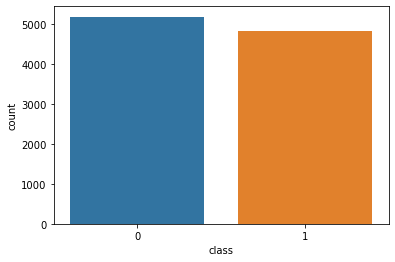

In [154]:
import seaborn as sns

sns.countplot(data=sample1, x="class")

In [158]:
sample = []

for i in range(10):
    
    tmp = new_intera.sample(n=10000, random_state=40+i)
    tmp.reset_index(drop=True, inplace=True)
    
    sample.append(tmp)
    
len(sample)

10

In [159]:
sample[0]

,uniprot_id,isomeric_smiles,can_smi,class
0,P11309,Cc1nc2cccc(-c3cc4c(CCNC4=O)[nH]3)c2nc1N[C@@H]1...,Cc1nc2cccc(-c3cc4c([nH]3)CCNC4=O)c2nc1NC1CC(O)C1,1
1,P28482,CN1CC[C@@H]1C(=O)N1CC[C@@](C)(C1)N1CCc2c1nc(nc...,CN1CCC1C(=O)N1CCC(C)(N2CCc3c(-c4cnc(N)nc4)nc(N...,0
2,P24385,CS(=O)(=O)N1CCC(CC1)N1CC(CC#N)(C1)n1cc(cn1)-c1...,CS(=O)(=O)N1CCC(N2CC(CC#N)(n3cc(-c4ccnc5[nH]cc...,0
3,P42338,COc1ncc-2cc1NS(=O)(=O)c1ccc(F)c(c1)C(=O)NCc1cc...,COc1ncc2cc1NS(=O)(=O)c1ccc(F)c(c1)C(=O)NCc1ccc...,1
4,O60674,NC(=O)c1cn(nc1Nc1ccc(cc1)C#N)[C@H]1COCC[C@@H]1C#N,N#Cc1ccc(Nc2nn(C3COCCC3C#N)cc2C(N)=O)cc1,1
...,...,...,...,...
9995,Q07343,COc1ccc(-c2nc(C(=O)N3CCC(O)(CC3)c3ccccc3)c(CN)...,COc1ccc(-c2nc(C(=O)N3CCC(O)(c4ccccc4)CC3)c(CN)...,1
9996,P03372,CN([C@@H]1CCN(C1)c1ncnc2[nH]ccc12)c1ncc(cc1[N+...,CN(c1ncc(C#N)cc1[N+](=O)[O-])C1CCN(c2ncnc3[nH]...,0
9997,P12931,COc1cc(Nc2c(cnc3cc(sc23)-c2csc(CN3CCN(C)CC3)c2...,COc1cc(Nc2c(C#N)cnc3cc(-c4csc(CN5CCN(C)CC5)c4)...,1
9998,P36897,CC(C)OC(=O)N1CCC(C1)c1cc(Nc2ncc(s2)C(=O)Nc2c(C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(C2CCN(C...,0


In [168]:
sample[0]["Name"]=sample[0]["isomeric_smiles"]

In [183]:
ecfp_df["isomeric_smiles"] = new_intera["isomeric_smiles"]
ecfp_df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,isomeric_smiles
0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...
1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...
2,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1
3,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...
4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268342,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCNC(=O)CN1[C@H]2CCC[C@@H]1C[C@H](C2)N(C)c1nc(...
268343,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
268344,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,CCCC[C@]12Cc3c(ccc4nn[nH]c34)C1=C(Br)C(=O)CC2
268345,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,O=C(CC#N)N1CCC[C@H](C1)n1c2nc(Nc3ccc[nH]c3=O)n...


In [187]:
tmp = pd.merge(sample[1]["isomeric_smiles"], ecfp_df, on="isomeric_smiles", how="left")
tmp.drop_duplicates(subset=["isomeric_smiles"],inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp

,isomeric_smiles,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CCn1c(CO)nn(-c2cc3c(cn(-c4c(C)n[nH]c4Cl)c(=O)c...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Cc1cc(ccn1)-c1n[nH]c2cc(NC(=O)NCCc3cn[nH]c3)ncc12,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,COc1cc2cc(cnc2cc1OC)-c1ccc(CC(=O)Nc2cc(n[nH]2)...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCCNC(=O)c1ccc2n3CC[C@H]4[C@H]([C@H](c5cccc(Cl...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,COc1ccccc1NC(=O)Nc1cc(ccc1O)S(N)(=O)=O,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9506,NC(=O)c1cccc2c(NCc3ccc(Cl)c(c3)C(F)(F)F)ncnc12,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9507,CCCOc1ccccc1-c1cc(no1)C(=O)NC12CC3CC(CC(C3)C1)C2,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9508,CNc1cc(Nc2cccc(n2)N2CCCC2)nc2c(cnn12)C(=O)NC1CC1,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9509,Cc1ccc(nc1)C(=O)Nc1ccc(NC(=O)Nc2cc(on2)C(C)(C)...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [190]:
new_intera.to_csv("dataset/interactions_df.csv", index=False)

# Ignore Below

In [191]:
import pubchempy as pcp

In [193]:
cids = [3675,107812,61833,6468,6251,26757,1123,4914,903,156391,4034,135398641,6197,6912,449459]
name = ["Phenelzine","hypotaurine","DOLOMITE","PHENCYCLIDINE","D-mannitol","selegiline","taurine","procaine","N-Acetyl-5-hydroxytryptamine","NAPROXEN","meclizine","inosine","cycloheximide","xylitol","4-Hydroxytamoxifen"]

In [195]:
# Loop over the CIDs and retrieve the SMILES strings
can_smi = []
for cid in tqdm(cids):
    compound = pcp.get_compounds(cid)[0]
    smiles = compound.canonical_smiles
    can_smi.append(smiles)

  0%|          | 0/15 [00:00<?, ?it/s]

In [200]:
adme_df = pd.DataFrame({
    "can_smi": can_smi,
    "name": name,
})
adme_df

,can_smi,name
0,C1=CC=C(C=C1)CCNN,Phenelzine
1,C(CS(=O)O)N,hypotaurine
2,C(=O)([O-])[O-].C(=O)([O-])[O-].[Mg+2].[Ca+2],DOLOMITE
3,C1CCC(CC1)(C2=CC=CC=C2)N3CCCCC3,PHENCYCLIDINE
4,C(C(C(C(C(CO)O)O)O)O)O,D-mannitol
5,CC(CC1=CC=CC=C1)N(C)CC#C,selegiline
6,C(CS(=O)(=O)O)N,taurine
7,CCN(CC)CCOC(=O)C1=CC=C(C=C1)N,procaine
8,CC(=O)NCCC1=CNC2=C1C=C(C=C2)O,N-Acetyl-5-hydroxytryptamine
9,CC(C1=CC2=C(C=C1)C=C(C=C2)OC)C(=O)O,NAPROXEN


In [201]:
adme_df.to_csv("dataset/adme_df.txt", sep=" ", header=False, index=False)